# Detección de anomalías

## Autores:
* Pedro Hernández
* Aaron Lara
* Benjamin López

En esta libreta de Jupyter se realizará una detección de anomalías mediante tres métodos diferentes para comparar los resultados de cada uno. Los algoritmos que se probarán son: *Método 1*, *Método 2* y *Método 3*.

El conjunto de datos sobre el que se trabajará fue extraído de la [base de datos climatológica nacional (sistema CLICOM)](http://clicom-mex.cicese.mx/) donde se recopilan los datos de las estaciones climáticas superficiales de México. En esta ocasión, se trabajará específicamente sobre las lecturas climatológicas realizadas en las estaciones del estado de Sonora desde 1960 hasta 2019.


## Importación de las Librerías

In [1]:
# Para el manejo eficiente del conjunto de datos
import pandas as pd 
import numpy as np
from scipy import stats
# Para construir los elementos gráficos
import seaborn as sns 
import matplotlib.pyplot as plt
# Para la visualización de los valores nulos
import missingno as msno
from sklearn.neighbors import LocalOutlierFactor

## Extracción de los datos

El sistema CLICOM carece de una API para la extracción de sus datos. Por este motivo se han descargado manualmente los archivos csv correspondientes a cada variable y a cada estación climatológica del estado de Sonora. Los csvs originales se encuentran comprimidos en el archivo [datos/clicom_mex_cicese_sonora.zip]().

Para unir todos los datos en un solo archivo se construyó el script [joinData.py](). Este programa une y comprime los datos; el resultado se encuentra almacenado en el archivo [datos/datos_sonora.zip]()

## Limpieza de datos

### Se cargan los datos desde el archivo comprimido

In [2]:
df = pd.read_csv("datos/datos_hermosillo.zip", low_memory=False)

In [3]:
df.head(3)

Fecha  IdEstacion     NombreEstacion                CoordGeoEstacion  \
0  1974-07-01       26179  BAHIA DE KINO-SON  28.8227777778N -111.948888889W   
1  1974-07-02       26179  BAHIA DE KINO-SON  28.8227777778N -111.948888889W   
2  1974-07-03       26179  BAHIA DE KINO-SON  28.8227777778N -111.948888889W   

   Temp Mínima (oC)  Temp Máxima (oC)  Temp Promedio (oC)  \
0              22.0              35.0               28.50   
1              22.5              34.0               28.25   
2              21.0              31.5               26.25   

   Unidades Calor (oD)  Evaporación (mm)  Precipitación (mm)  
0                17.13               7.3                 0.0  
1                17.21              10.5                 0.0  
2                16.01              13.6                 0.0

In [4]:
df.tail(3)

Fecha  IdEstacion           NombreEstacion  \
49671  2016-09-28       26139  HERMOSILLO II (DGE)-SON   
49672  2016-09-29       26139  HERMOSILLO II (DGE)-SON   
49673  2016-09-30       26139  HERMOSILLO II (DGE)-SON   

                     CoordGeoEstacion  Temp Mínima (oC)  Temp Máxima (oC)  \
49671  29.0988888889N -110.965833333W              22.0              35.0   
49672  29.0988888889N -110.965833333W              24.0              37.5   
49673  29.0988888889N -110.965833333W              24.5              37.0   

       Temp Promedio (oC)  Unidades Calor (oD)  Evaporación (mm)  \
49671                 NaN                17.13               NaN   
49672                 NaN                18.21               NaN   
49673                 NaN                18.37               NaN   

       Precipitación (mm)  
49671                 0.0  
49672                 0.0  
49673                 0.0

In [5]:
print("Número de renglones y columnas:", df.shape)

Número de renglones y columnas: (49674, 10)


### Ajuste de los tipos de datos y nombres de las variables

In [6]:
df.dtypes

Fecha                   object
IdEstacion               int64
NombreEstacion          object
CoordGeoEstacion        object
Temp Mínima (oC)       float64
Temp Máxima (oC)       float64
Temp Promedio (oC)     float64
Unidades Calor (oD)    float64
Evaporación (mm)       float64
Precipitación (mm)     float64
dtype: object

Como podemos observar, Pandas toma la fecha como una variable tipo `object` (`str`). Además, los nombres de las columnas contienen las unidades pero podemos prescindir de éstas. Necesitamos corregir estos detalles para manejar los datos de manera adecuada.

In [7]:
# Renombrando las columnas
nuevas_columnas = {'NombreEstacion':'Estacion', 'Temp Mínima (oC)':'Tmin', 'Temp Máxima (oC)':'Tmax', 
                   'Temp Promedio (oC)':'Tprom', 'Unidades Calor (oD)':'UCalor', 
                   'Evaporación (mm)':'Evap', 'Precipitación (mm)':'Precip'
                  }
df.rename(columns=nuevas_columnas, inplace=True)

In [8]:
# Corrección del tipo de datos de la fecha
df.Fecha = pd.to_datetime(df.Fecha)

In [9]:
# Verificación de los cambios
df.dtypes

Fecha               datetime64[ns]
IdEstacion                   int64
Estacion                    object
CoordGeoEstacion            object
Tmin                       float64
Tmax                       float64
Tprom                      float64
UCalor                     float64
Evap                       float64
Precip                     float64
dtype: object

In [10]:
df.describe()

IdEstacion          Tmin          Tmax         Tprom        UCalor  \
count  49674.000000  39833.000000  39839.000000  14213.000000  39423.000000   
mean   26155.521540     16.011566     31.108823     21.392750     12.577707   
std       19.302324      7.074931      6.896338      6.448302      5.144609   
min    26138.000000     -4.000000      0.000000      3.000000      0.000000   
25%    26139.000000     10.000000     26.000000     16.000000      8.040000   
50%    26139.000000     15.000000     32.000000     20.750000     13.200000   
75%    26179.000000     22.500000     37.000000     27.500000     17.450000   
max    26179.000000     32.000000     49.000000     37.250000     20.000000   

               Evap        Precip  
count  25014.000000  40264.000000  
mean       7.137907      0.816119  
std        3.395388      4.986201  
min        0.080000      0.000000  
25%        4.500000      0.000000  
50%        6.800000      0.000000  
75%        9.500000      0.000000  
max       18.000000    152.600000

### Revisión de valores faltantes

In [11]:
df.isnull().sum()

Fecha                   0
IdEstacion              0
Estacion                0
CoordGeoEstacion        0
Tmin                 9841
Tmax                 9835
Tprom               35461
UCalor              10251
Evap                24660
Precip               9410
dtype: int64

Podemos notar que existen muchos valores faltantes. Algunas gráficas y porcentajes nos ayudarán a darnos una mejor idea del comportamiento de los datos nulos

<AxesSubplot:>

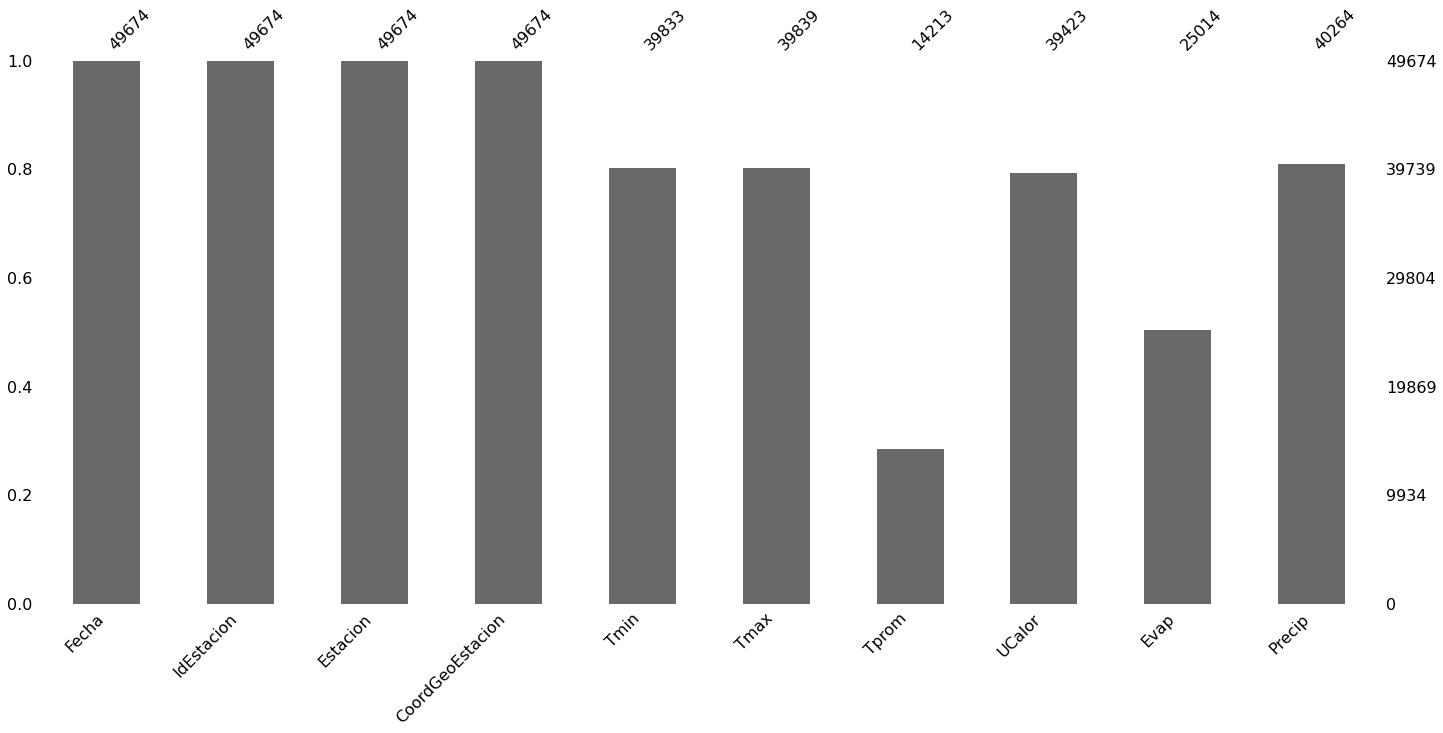

In [12]:
msno.bar(df)

<AxesSubplot:>

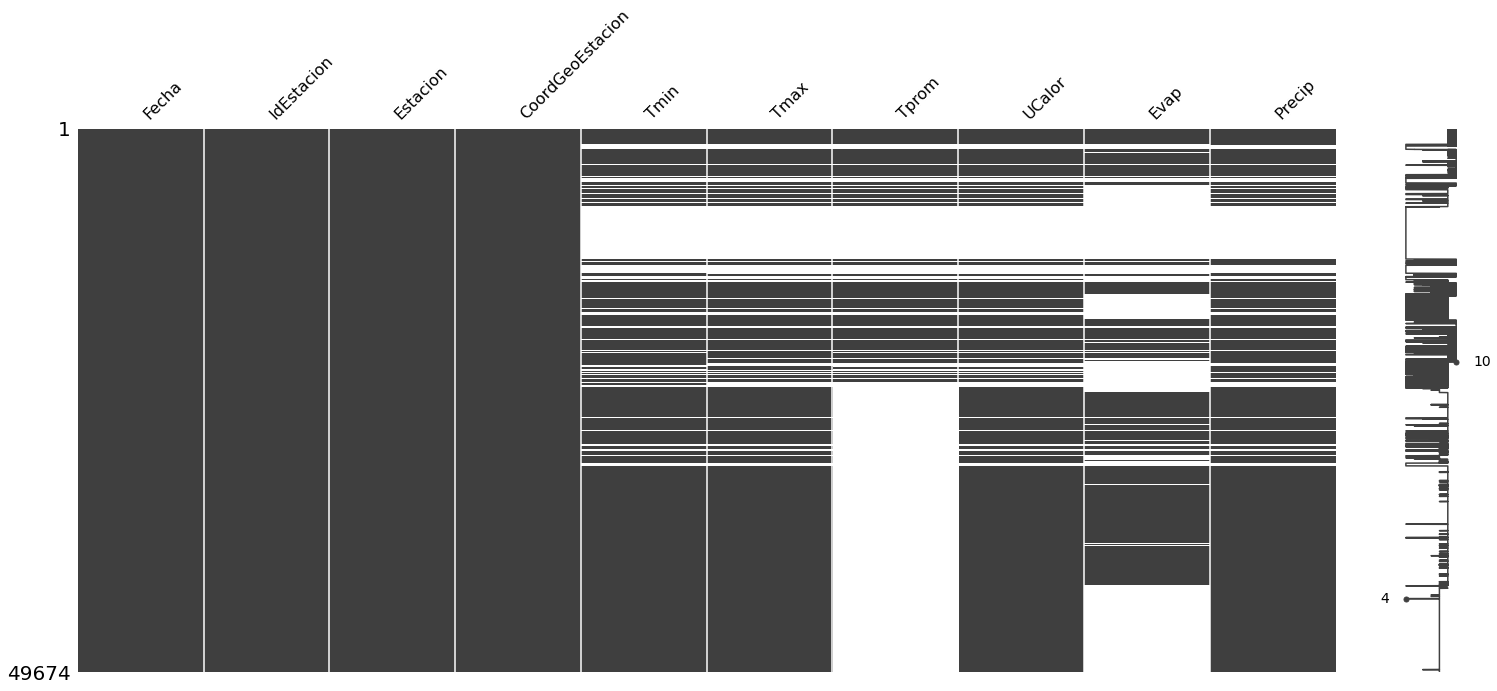

In [13]:
msno.matrix(df)

In [14]:
print("Porcentaje de valores nulos por columna\n")
total_rows = len(df)
for c in df.columns:
    num_nans = df[c].isna().sum()
    print(f"{c}: {num_nans} -> ({str(num_nans/total_rows*100)[:5]}%)")

Porcentaje de valores nulos por columna

Fecha: 0 -> (0.0%)
IdEstacion: 0 -> (0.0%)
Estacion: 0 -> (0.0%)
CoordGeoEstacion: 0 -> (0.0%)
Tmin: 9841 -> (19.81%)
Tmax: 9835 -> (19.79%)
Tprom: 35461 -> (71.38%)
UCalor: 10251 -> (20.63%)
Evap: 24660 -> (49.64%)
Precip: 9410 -> (18.94%)


Todas las variables de interés (desde `Tmin` hasta `Precip`) tienen un alto porcentaje de valores nulos, por este motivo sería buena idea realizar imputaciones. 

Podemos realizar las imputaciones utilizando alguna medida de tendencia central (mediana o promedio) basándonos en las temperaturas observadas en una determinada región y un periodo de tiempo. Por ejemplo, las temperaturas mínimas en los meses de invierno son mucho más bajas que en los meses de verano; a su vez, las temperaturas, precipitaciones y evaporación al norte del estado son considerablemente diferentes a las del sur.

Para cumplir este objetivo se utilizará el siguiente algoritmo:
* Por cada año, mes y municipio:
    * Por cada variable con datos nulos:
        * Realizar una prueba de hipótesis para saber si la distribución de la 
          variable se asemeja a una distribución normal
        * Si la distribución se parece a una normal ($p-valor<=0.05$), imputar con el valor promedio
        * Si la distribución no se parece a una normal ($p-valor>0.05$), imputar con la mediana
            


#### Imputación de los valores nulos

Para identificar más fácilmente los municipios a los que pertenece cada estación, el nombre de éste se añadirá a cada observación en una columna nueva

In [15]:
df['Municipio'] = df.Estacion.apply(lambda estacion: estacion.split('-')[0])
df

Fecha  IdEstacion                 Estacion  \
0     1974-07-01       26179        BAHIA DE KINO-SON   
1     1974-07-02       26179        BAHIA DE KINO-SON   
2     1974-07-03       26179        BAHIA DE KINO-SON   
3     1974-07-04       26179        BAHIA DE KINO-SON   
4     1974-07-05       26179        BAHIA DE KINO-SON   
...          ...         ...                      ...   
49669 2016-09-26       26139  HERMOSILLO II (DGE)-SON   
49670 2016-09-27       26139  HERMOSILLO II (DGE)-SON   
49671 2016-09-28       26139  HERMOSILLO II (DGE)-SON   
49672 2016-09-29       26139  HERMOSILLO II (DGE)-SON   
49673 2016-09-30       26139  HERMOSILLO II (DGE)-SON   

                     CoordGeoEstacion  Tmin  Tmax  Tprom  UCalor  Evap  \
0      28.8227777778N -111.948888889W  22.0  35.0  28.50   17.13   7.3   
1      28.8227777778N -111.948888889W  22.5  34.0  28.25   17.21  10.5   
2      28.8227777778N -111.948888889W  21.0  31.5  26.25   16.01  13.6   
3      28.8227777778N -111.948888889W  28.0  41.0  34.50   19.66  10.7   
4      28.8227777778N -111.948888889W  28.0  35.0  31.50   19.53  10.9   
...                               ...   ...   ...    ...     ...   ...   
49669  29.0988888889N -110.965833333W  24.0  36.0    NaN   18.09   NaN   
49670  29.0988888889N -110.965833333W  21.0  35.5    NaN   16.75   NaN   
49671  29.0988888889N -110.965833333W  22.0  35.0    NaN   17.13   NaN   
49672  29.0988888889N -110.965833333W  24.0  37.5    NaN   18.21   NaN   
49673  29.0988888889N -110.965833333W  24.5  37.0    NaN   18.37   NaN   

       Precip            Municipio  
0         0.0        BAHIA DE KINO  
1         0.0        BAHIA DE KINO  
2         0.0        BAHIA DE KINO  
3         0.0        BAHIA DE KINO  
4         0.0        BAHIA DE KINO  
...       ...                  ...  
49669     5.2  HERMOSILLO II (DGE)  
49670     0.0  HERMOSILLO II (DGE)  
49671     0.0  HERMOSILLO II (DGE)  
49672     0.0  HERMOSILLO II (DGE)  
49673     0.0  HERMOSILLO II (DGE)  

[49674 rows x 11 columns]

#### ---------- NOTA IMPORTANTE ----------

El algoritmo de imputación es considerablemente costoso por lo que su tiempo de ejecución es de aproximadamente una hora. 
Los datos imputados ya se han calculado y están almacenados en el archivo `datos/datos_sonora_no_nans.zip`. Si deseas omitir
este procedimiento continúa a partir de la siguiente sección *"Análisis exploratorio de datos"*

In [16]:
# En este objeto grouby se almacenarán los "sub-dataframes" agrupados por año, mes y municipio
df_agrupado = df.groupby([df.Fecha.dt.year, df.Fecha.dt.month, 'Municipio'])

In [17]:
# Se importan las dependencias necesarias para realizar la prueba de hipótesis
from scipy.stats import skewtest
import math
# Se obtiene la cantidad de grupo s (año,mes,municipio)
n_groups = len(df_agrupado.indices.keys())
n_groups
i = 0 # Contador para saber cuánto le falta al proceso para terminar

# ----- COMIENZA EL ALGORITMO DE IMPUTACIÓN -----
# Cada elemento 'k' representa la lista de renglones correspondientes a cada grupo
for k in df_agrupado.indices.keys():
    # Se obtienen los índices correspondientes al grupo actual
    indices = df_agrupado.indices[k]
    # Se itera cada variable numérica para realizar la imputación
    # (4:Tmin, 5:Tmax, 6:Tprom, 7:UCalor, 8:Evap, 9:Precip)
    for column in [4,5,6,7,8,9]:
        # Se obtiene la porción del dataframe que corresponde al grupo y columna actual
        df_group = df.iloc[indices,column]
        # Primero se revisa si existen valores nulos en el grupo y columna que está 
        # siento revisada
        if df_group.isnull().values.any():
            # Si existen valores nulos se realiza un skew test para saber
            # si hay que imputar con la mediana o con la media.
            
            # En ocasiones las variables llegan a presentar valores nulos
            # en un mes completo. En este caso no tendríamos cómo
            # calcular una imputación, así que se imputará directamente con 0.
            # La necesidad del try-except radica en que para la prueba de hipótesis
            # necesita al menos 8 valores no nulos para poder calcular algo
            try:
                # Se obtiene el p-valor de la prueba de hipótesis
                pvalue = skewtest(df_group, nan_policy='omit')[1]
            except:
                # Si no se pudo realizar la prueba de hipótesis significa que la 
                # variable en cuestión presentó valores nulos por lo menos 22 días al mes.
                # (el método skewtest debe recibir por lo menos 8 valores).
                # En este caso se intenta imputar con la media. Si la media es nan, entonces
                # significa que no existen valores diferentes de nan en el mes completo. En ese
                # caso se imputa directamente con 0.
                mean = df_group.mean()
                if not math.isnan(mean):
                    df.iloc[indices, column] = df_group.fillna(mean)
                else:
                    df.iloc[indices, column] = df_group.fillna(0)
                continue
            
            # Si el pvalor es >.05 rechazamos la hipótesis de que los datos se 
            # distribuyen normalmente y se imputa con la mediana; en caso contrario, 
            # se imputa con la media
            if pvalue > .05:
                df.iloc[indices, column] = df_group.fillna(df_group.median())
            else:
                df.iloc[indices, column] = df_group.fillna(df_group.mean())
    i += 1
    print(f"{i}/{n_groups}",end='\r')
    

Revisemos que, en efecto, ya no existen valores nulos en nuestro conjunto de datos

In [18]:
df

Fecha  IdEstacion                 Estacion  \
0     1974-07-01       26179        BAHIA DE KINO-SON   
1     1974-07-02       26179        BAHIA DE KINO-SON   
2     1974-07-03       26179        BAHIA DE KINO-SON   
3     1974-07-04       26179        BAHIA DE KINO-SON   
4     1974-07-05       26179        BAHIA DE KINO-SON   
...          ...         ...                      ...   
49669 2016-09-26       26139  HERMOSILLO II (DGE)-SON   
49670 2016-09-27       26139  HERMOSILLO II (DGE)-SON   
49671 2016-09-28       26139  HERMOSILLO II (DGE)-SON   
49672 2016-09-29       26139  HERMOSILLO II (DGE)-SON   
49673 2016-09-30       26139  HERMOSILLO II (DGE)-SON   

                     CoordGeoEstacion  Tmin  Tmax  Tprom  UCalor  Evap  \
0      28.8227777778N -111.948888889W  22.0  35.0  28.50   17.13   7.3   
1      28.8227777778N -111.948888889W  22.5  34.0  28.25   17.21  10.5   
2      28.8227777778N -111.948888889W  21.0  31.5  26.25   16.01  13.6   
3      28.8227777778N -111.948888889W  28.0  41.0  34.50   19.66  10.7   
4      28.8227777778N -111.948888889W  28.0  35.0  31.50   19.53  10.9   
...                               ...   ...   ...    ...     ...   ...   
49669  29.0988888889N -110.965833333W  24.0  36.0   0.00   18.09   0.0   
49670  29.0988888889N -110.965833333W  21.0  35.5   0.00   16.75   0.0   
49671  29.0988888889N -110.965833333W  22.0  35.0   0.00   17.13   0.0   
49672  29.0988888889N -110.965833333W  24.0  37.5   0.00   18.21   0.0   
49673  29.0988888889N -110.965833333W  24.5  37.0   0.00   18.37   0.0   

       Precip            Municipio  
0         0.0        BAHIA DE KINO  
1         0.0        BAHIA DE KINO  
2         0.0        BAHIA DE KINO  
3         0.0        BAHIA DE KINO  
4         0.0        BAHIA DE KINO  
...       ...                  ...  
49669     5.2  HERMOSILLO II (DGE)  
49670     0.0  HERMOSILLO II (DGE)  
49671     0.0  HERMOSILLO II (DGE)  
49672     0.0  HERMOSILLO II (DGE)  
49673     0.0  HERMOSILLO II (DGE)  

[49674 rows x 11 columns]

<AxesSubplot:>

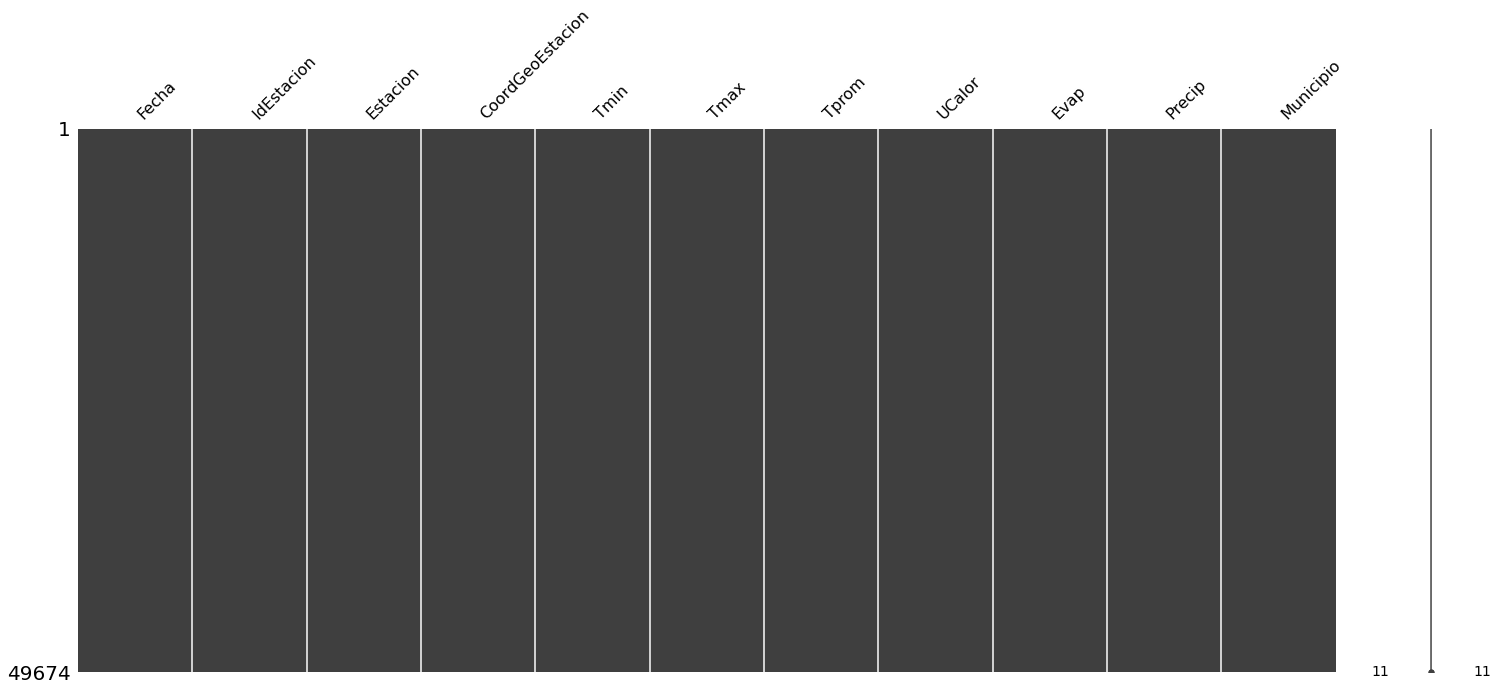

In [19]:
msno.matrix(df)

In [20]:
print("Porcentaje de valores nulos por columna\n")
total_rows = len(df)
for c in df.columns:
    num_nans = df[c].isna().sum()
    print(f"{c}: {num_nans} -> ({str(num_nans/total_rows*100)[:5]}%)")

Porcentaje de valores nulos por columna

Fecha: 0 -> (0.0%)
IdEstacion: 0 -> (0.0%)
Estacion: 0 -> (0.0%)
CoordGeoEstacion: 0 -> (0.0%)
Tmin: 0 -> (0.0%)
Tmax: 0 -> (0.0%)
Tprom: 0 -> (0.0%)
UCalor: 0 -> (0.0%)
Evap: 0 -> (0.0%)
Precip: 0 -> (0.0%)
Municipio: 0 -> (0.0%)


Debido a que el algoritmo de imputación es computacionalmente costoso se almacenarán los datos sin valores faltantes para que no sea necesario correr dicho algoritmo cada vez que la libreta se ejecute.

In [21]:
from zipfile import ZipFile, ZIP_DEFLATED
import os
# Se guarda el archivo de resultados
df.to_csv(f'datos/datos_sonora_no_nans.csv', index=False)
# Se comprimen los resultados
with ZipFile(f'datos/datos_sonora_no_nans.zip', 'w') as zip:
    zip.write(f'datos/datos_sonora_no_nans.csv', compress_type=ZIP_DEFLATED)
# Se elimina el csv
os.remove(f'datos/datos_sonora_no_nans.csv')

## Análisis exploratorio de datos

In [22]:
# Se lee el csv sin datos faltantes
df = pd.read_csv('datos/datos_sonora_no_nans.zip')

In [23]:
df.head()

Fecha  IdEstacion           Estacion                CoordGeoEstacion  \
0  1974-07-01       26179  BAHIA DE KINO-SON  28.8227777778N -111.948888889W   
1  1974-07-02       26179  BAHIA DE KINO-SON  28.8227777778N -111.948888889W   
2  1974-07-03       26179  BAHIA DE KINO-SON  28.8227777778N -111.948888889W   
3  1974-07-04       26179  BAHIA DE KINO-SON  28.8227777778N -111.948888889W   
4  1974-07-05       26179  BAHIA DE KINO-SON  28.8227777778N -111.948888889W   

   Tmin  Tmax  Tprom  UCalor  Evap  Precip      Municipio  
0  22.0  35.0  28.50   17.13   7.3     0.0  BAHIA DE KINO  
1  22.5  34.0  28.25   17.21  10.5     0.0  BAHIA DE KINO  
2  21.0  31.5  26.25   16.01  13.6     0.0  BAHIA DE KINO  
3  28.0  41.0  34.50   19.66  10.7     0.0  BAHIA DE KINO  
4  28.0  35.0  31.50   19.53  10.9     0.0  BAHIA DE KINO

In [24]:
df.tail()

Fecha  IdEstacion                 Estacion  \
49669  2016-09-26       26139  HERMOSILLO II (DGE)-SON   
49670  2016-09-27       26139  HERMOSILLO II (DGE)-SON   
49671  2016-09-28       26139  HERMOSILLO II (DGE)-SON   
49672  2016-09-29       26139  HERMOSILLO II (DGE)-SON   
49673  2016-09-30       26139  HERMOSILLO II (DGE)-SON   

                     CoordGeoEstacion  Tmin  Tmax  Tprom  UCalor  Evap  \
49669  29.0988888889N -110.965833333W  24.0  36.0    0.0   18.09   0.0   
49670  29.0988888889N -110.965833333W  21.0  35.5    0.0   16.75   0.0   
49671  29.0988888889N -110.965833333W  22.0  35.0    0.0   17.13   0.0   
49672  29.0988888889N -110.965833333W  24.0  37.5    0.0   18.21   0.0   
49673  29.0988888889N -110.965833333W  24.5  37.0    0.0   18.37   0.0   

       Precip            Municipio  
49669     5.2  HERMOSILLO II (DGE)  
49670     0.0  HERMOSILLO II (DGE)  
49671     0.0  HERMOSILLO II (DGE)  
49672     0.0  HERMOSILLO II (DGE)  
49673     0.0  HERMOSILLO II (DGE)

### Número de observaciones, valores faltantes y tipo de las variables

In [25]:
df.Fecha = pd.to_datetime(df.Fecha)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49674 entries, 0 to 49673
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha             49674 non-null  datetime64[ns]
 1   IdEstacion        49674 non-null  int64         
 2   Estacion          49674 non-null  object        
 3   CoordGeoEstacion  49674 non-null  object        
 4   Tmin              49674 non-null  float64       
 5   Tmax              49674 non-null  float64       
 6   Tprom             49674 non-null  float64       
 7   UCalor            49674 non-null  float64       
 8   Evap              49674 non-null  float64       
 9   Precip            49674 non-null  float64       
 10  Municipio         49674 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 4.2+ MB


### Estadísticas básicas

In [26]:
df.describe()

IdEstacion          Tmin          Tmax         Tprom        UCalor  \
count  49674.000000  49674.000000  49674.000000  49674.000000  49674.000000   
mean   26155.521540     13.381380     26.103782      7.065466     10.535437   
std       19.302324      8.751038     13.090010     10.804209      6.595957   
min    26138.000000     -4.000000      0.000000      0.000000      0.000000   
25%    26139.000000      7.000000     22.000000      0.000000      5.362750   
50%    26139.000000     13.000000     29.500000      0.000000     11.030000   
75%    26179.000000     21.000000     36.000000     16.000000     16.880000   
max    26179.000000     32.000000     49.000000     37.250000     20.000000   

               Evap        Precip  
count  49674.000000  49674.000000  
mean       3.815220      0.681650  
std        4.315742      4.505532  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        2.465000      0.000000  
75%        7.100000      0.000000  
max       18.000000    152.600000

### Distribución de las variables

#### Temperaturas

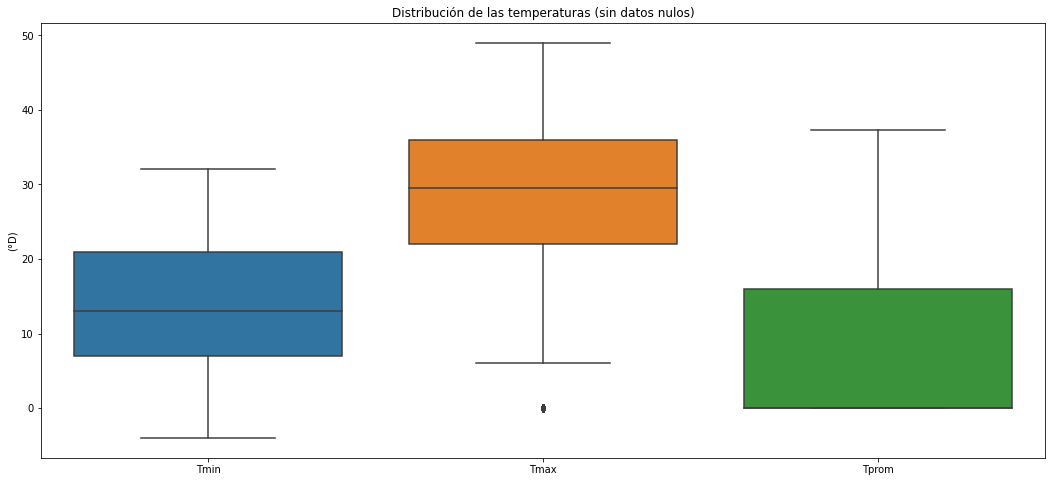

In [27]:
plt.figure(figsize = (18,8))
_ = sns.boxplot(x="variable", y="value", data=pd.melt(df.iloc[:,4:7])).set(title='Distribución de las temperaturas (sin datos nulos)', xlabel='', ylabel='(°D)')

#### Unidades de calor

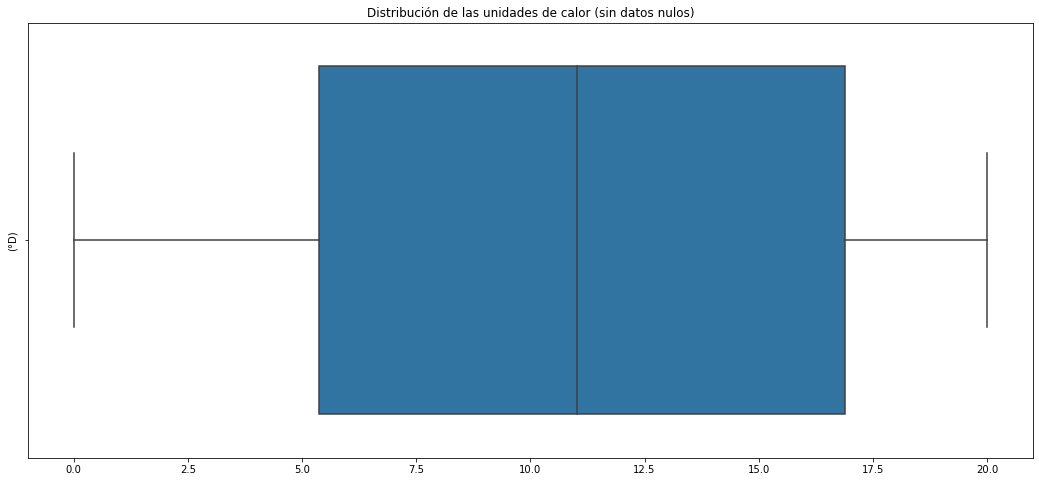

In [28]:
plt.figure(figsize = (18,8))
_ = sns.boxplot(x=df.UCalor).set(title='Distribución de las unidades de calor (sin datos nulos)', xlabel='', ylabel='(°D)')

#### Evaporación y precipitación

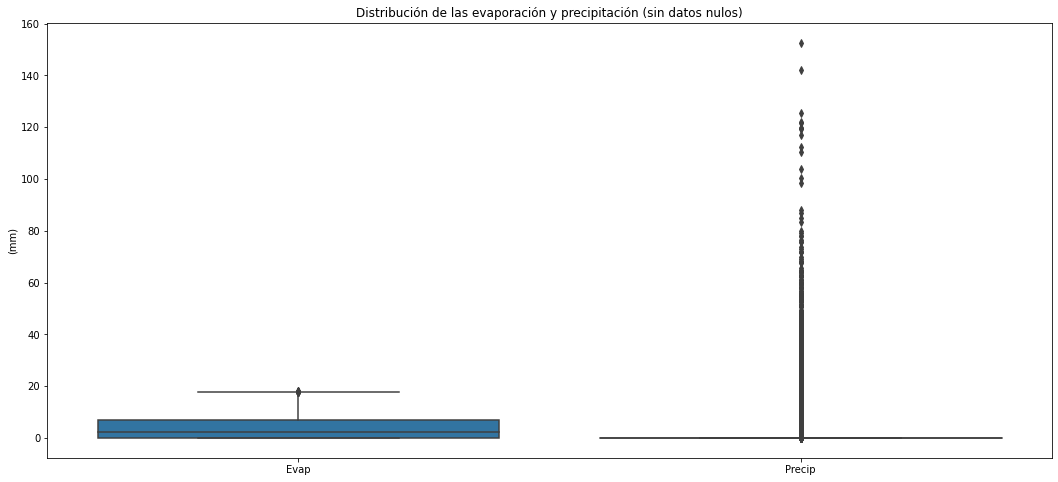

In [29]:
plt.figure(figsize = (18,8))
_ = sns.boxplot(x="variable", y="value", data=pd.melt(df.iloc[:,8:10])).set(title='Distribución de las evaporación y precipitación (sin datos nulos)', xlabel='', ylabel='(mm)')

### Distribución de las variables por año

In [30]:
def distribucionPorAnio(df, variable, titulo, etiqueta_x, etiqueta_y):
    plt.figure(figsize = (30,8))
    g = sns.boxplot(x=df.Fecha.dt.year, y=variable, data=df).set(title=titulo, xlabel=etiqueta_x, ylabel=etiqueta_y)
    _ = plt.xticks(rotation=45)

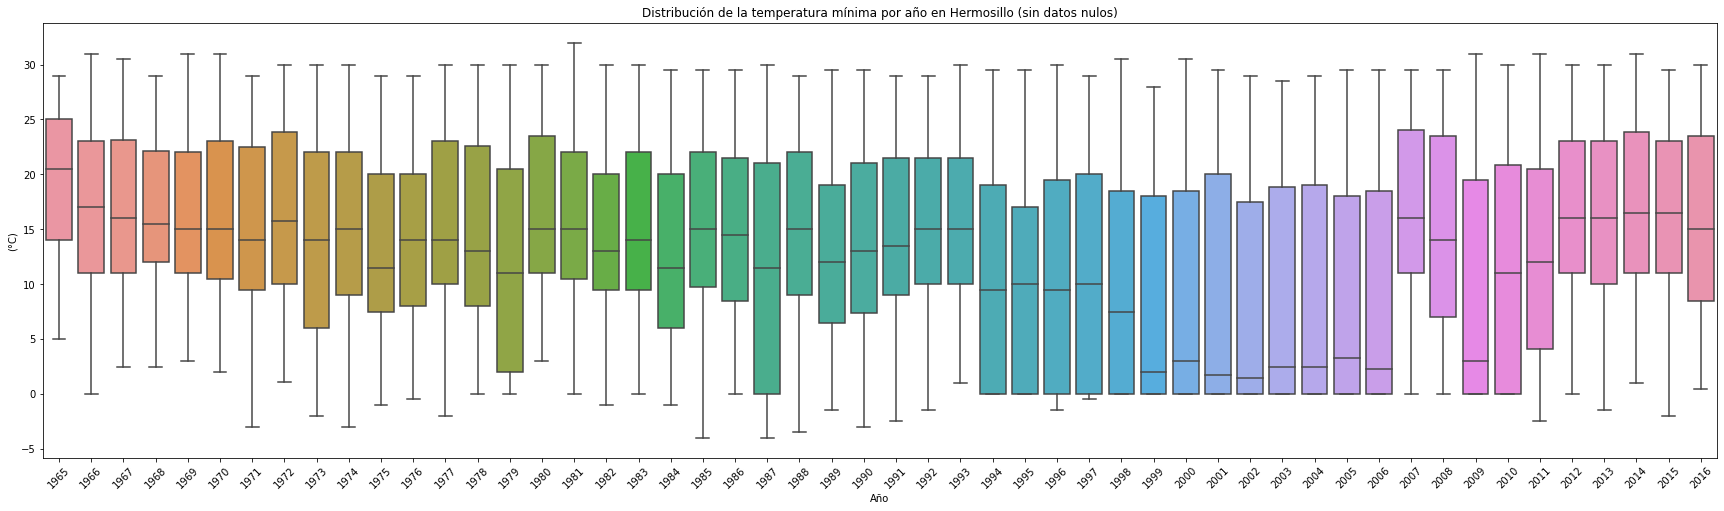

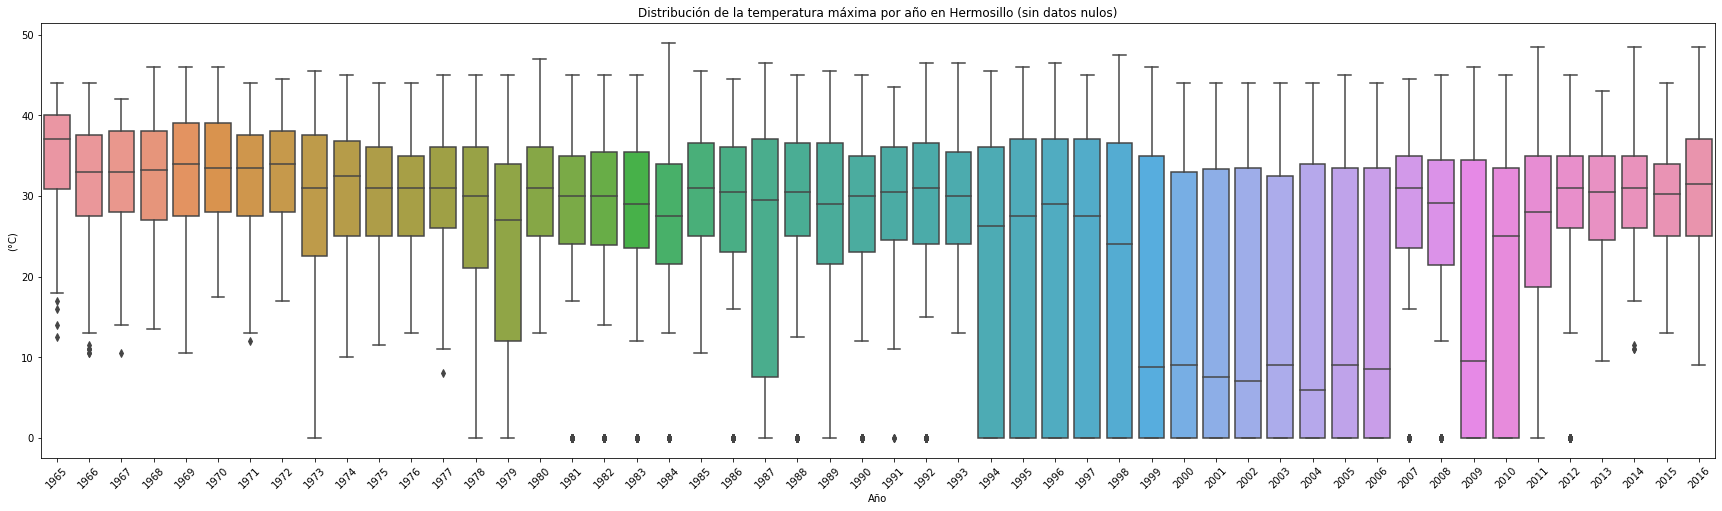

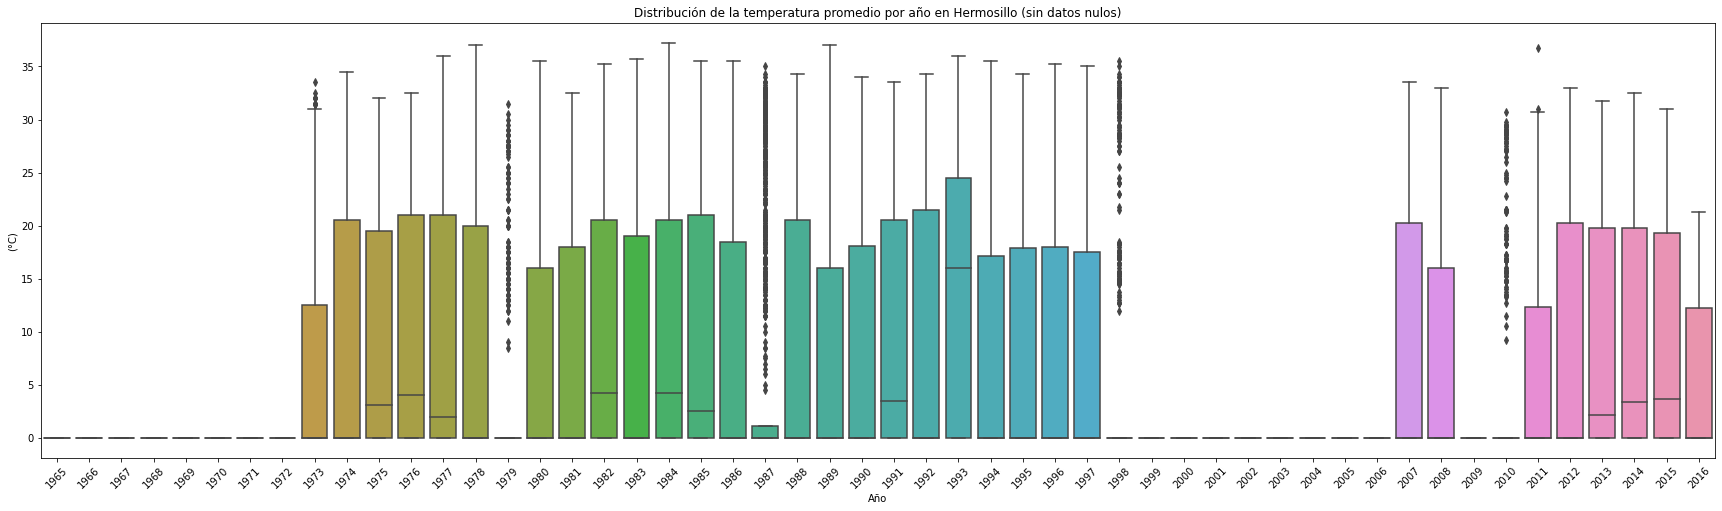

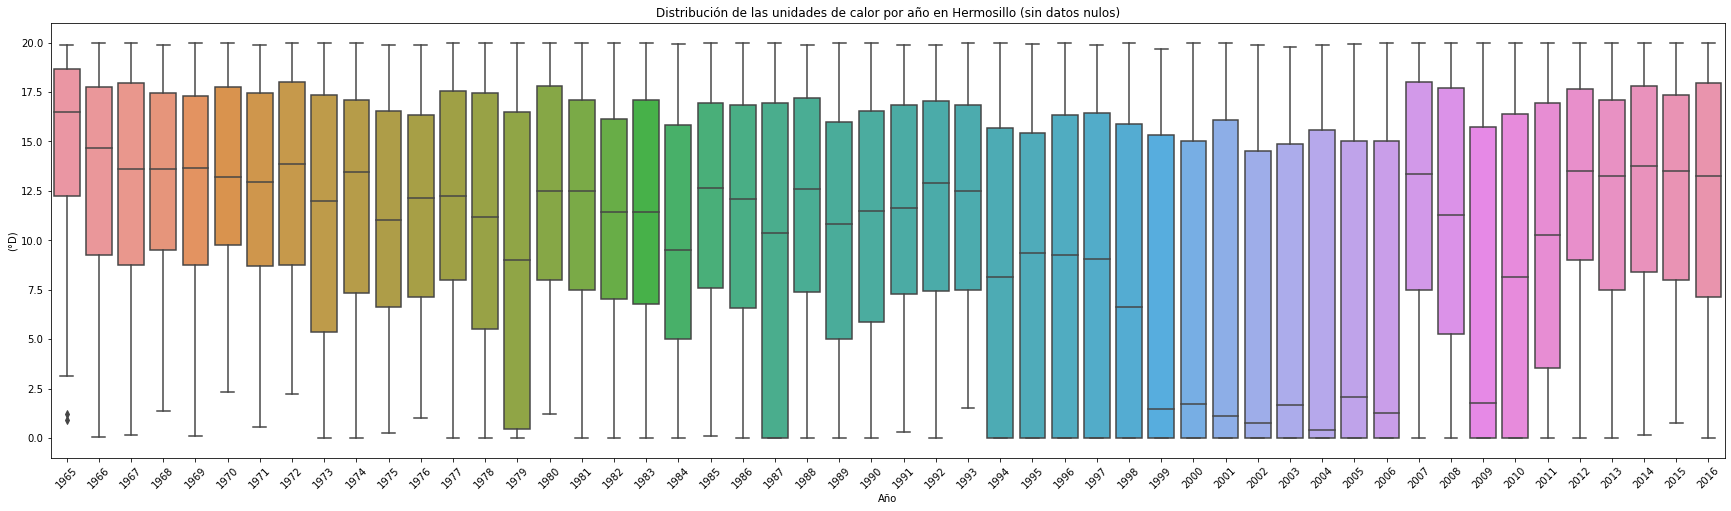

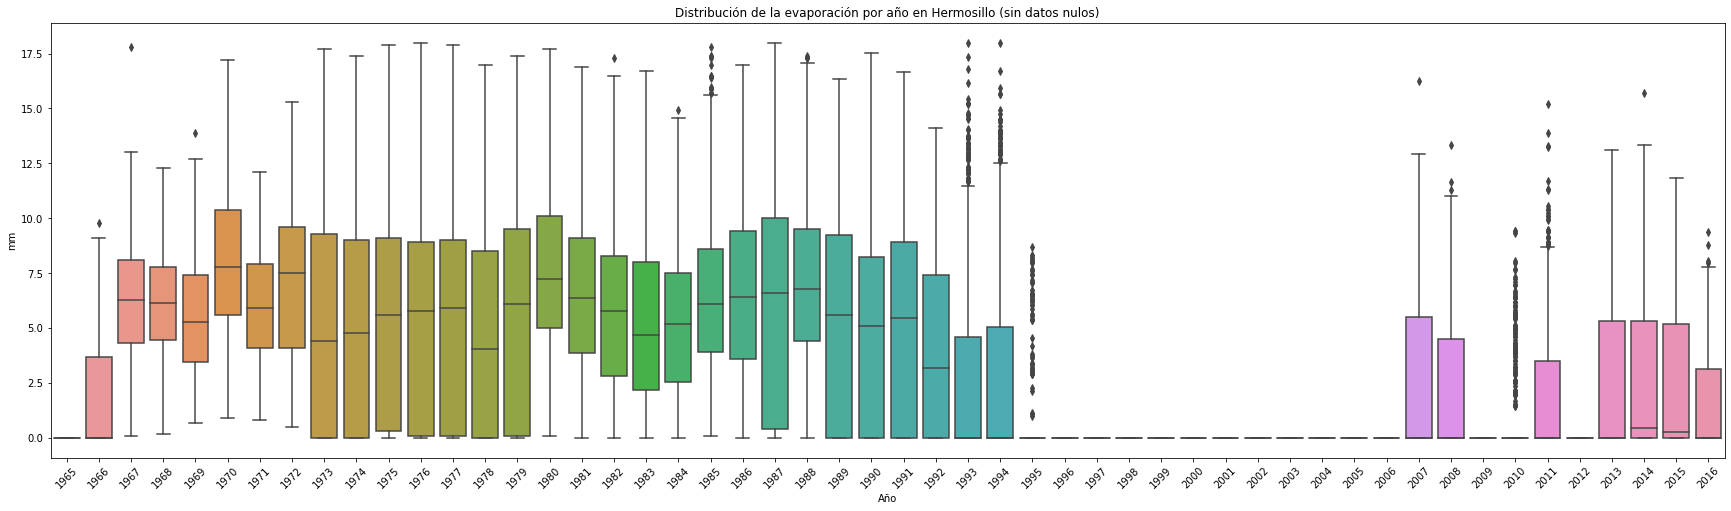

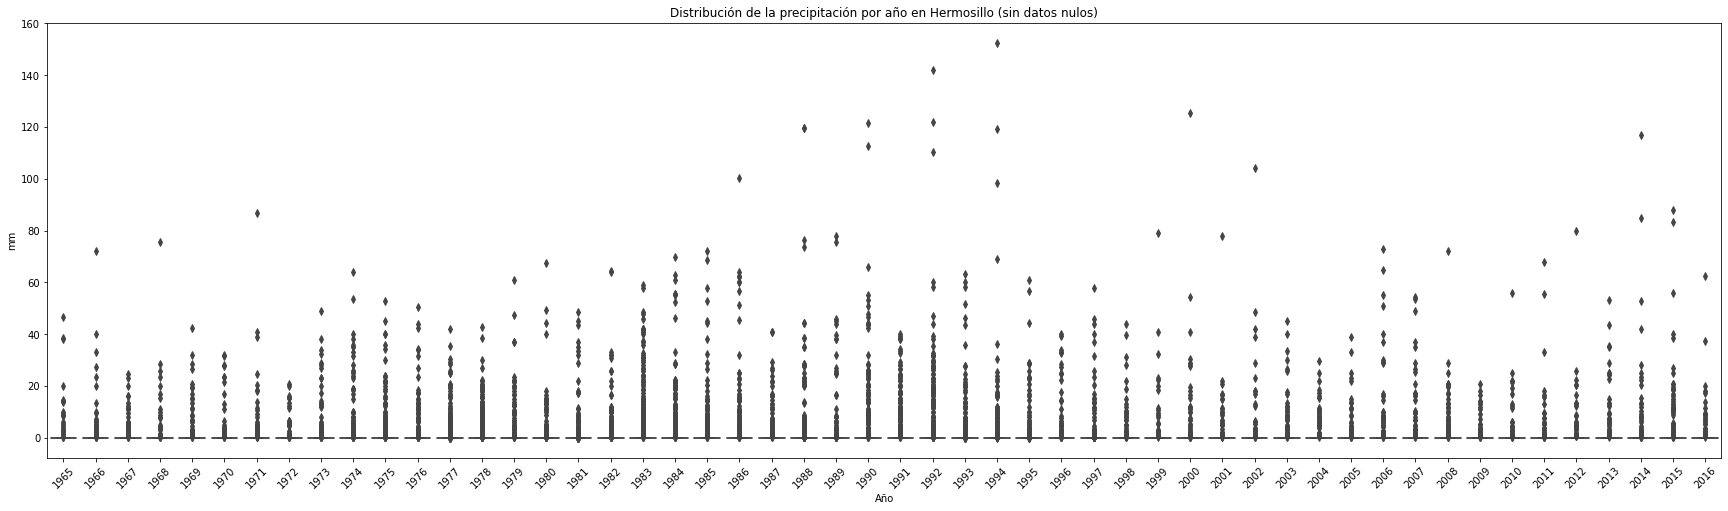

In [31]:
titulos = ['Distribución de la temperatura mínima',
           'Distribución de la temperatura máxima',
           'Distribución de la temperatura promedio',
           'Distribución de las unidades de calor',
           'Distribución de la evaporación',
           'Distribución de la precipitación'
           ]
ylabels = ['(°C)','(°C)','(°C)','(°D)', 'mm', 'mm']
variables = df.columns[4:10]

for i in range(6):
    distribucionPorAnio(df, variables[i], f"{titulos[i]} por año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

### Distribución de las variables por mes en cada año

In [32]:
def distribucionPorMes(df, variable, titulo, etiqueta_x, etiqueta_y):
    plt.figure(figsize = (30,8))
    g = sns.boxplot(x=df.Fecha.dt.year, y=variable, data=df).set(title=titulo, xlabel=etiqueta_x, ylabel=etiqueta_y)
    _ = plt.xticks(rotation=45)
    
def mapearMes(n):
    if n == 1:
        mes = 'enero'
    if n == 2:
        mes = 'febrero'
    if n == 3:
        mes = 'marzo'
    if n == 4:
        mes = 'abril'
    if n == 5:
        mes = 'mayo'
    if n == 6:
        mes = 'junio'
    if n == 7:
        mes = 'julio'
    if n == 8:
        mes = 'agosto'
    if n == 9:
        mes = 'septiembre'
    if n == 10:
        mes = 'octubre'
    if n == 11:
        mes = 'noviembre'
    if n == 12:
        mes = 'diciembre'
    return mes

titulos = ['Distribución de la temperatura mínima',
           'Distribución de la temperatura máxima',
           'Distribución de la temperatura promedio',
           'Distribución de las unidades de calor',
           'Distribución de la evaporación por año',
           'Distribución de la precipitación por año'
       ]
ylabels = ['(°C)','(°C)','(°C)','(°D)', 'mm', 'mm']
variables = df.columns[4:10]
dataframes_meses = {}

for i in range(1,13):
    dataframes_meses[mapearMes(i)] = df[df.Fecha.dt.month == i]

#### Enero

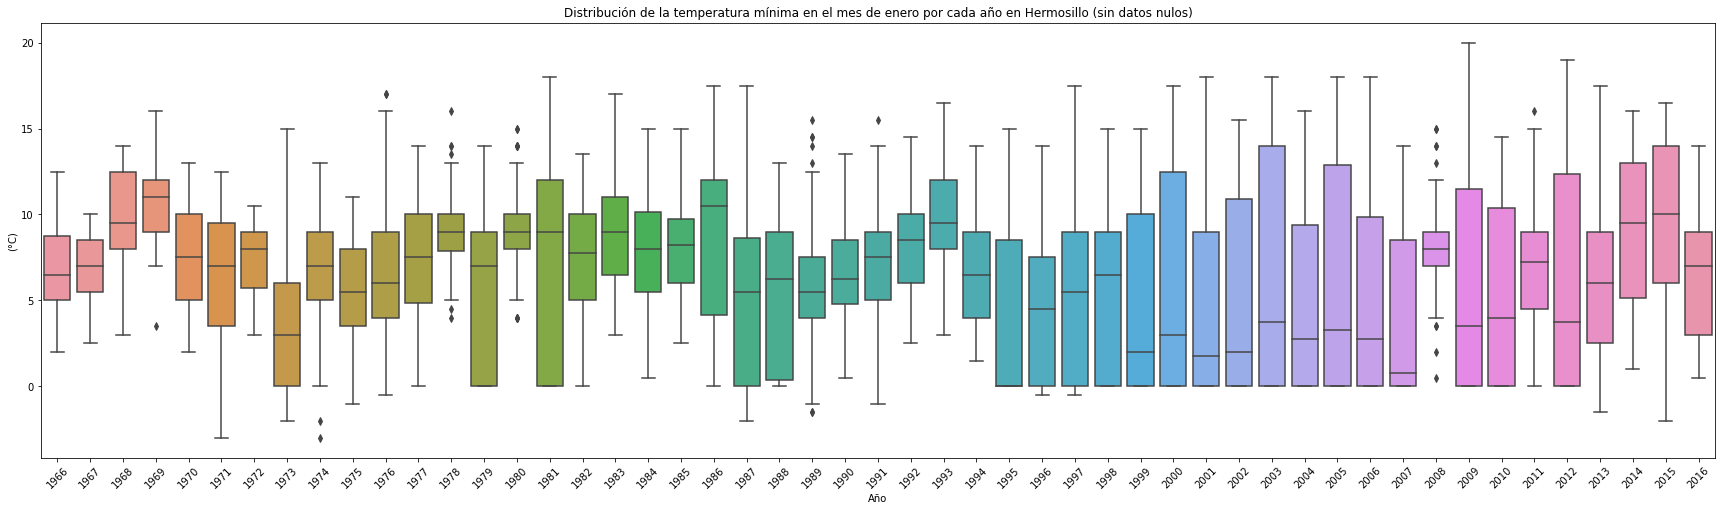

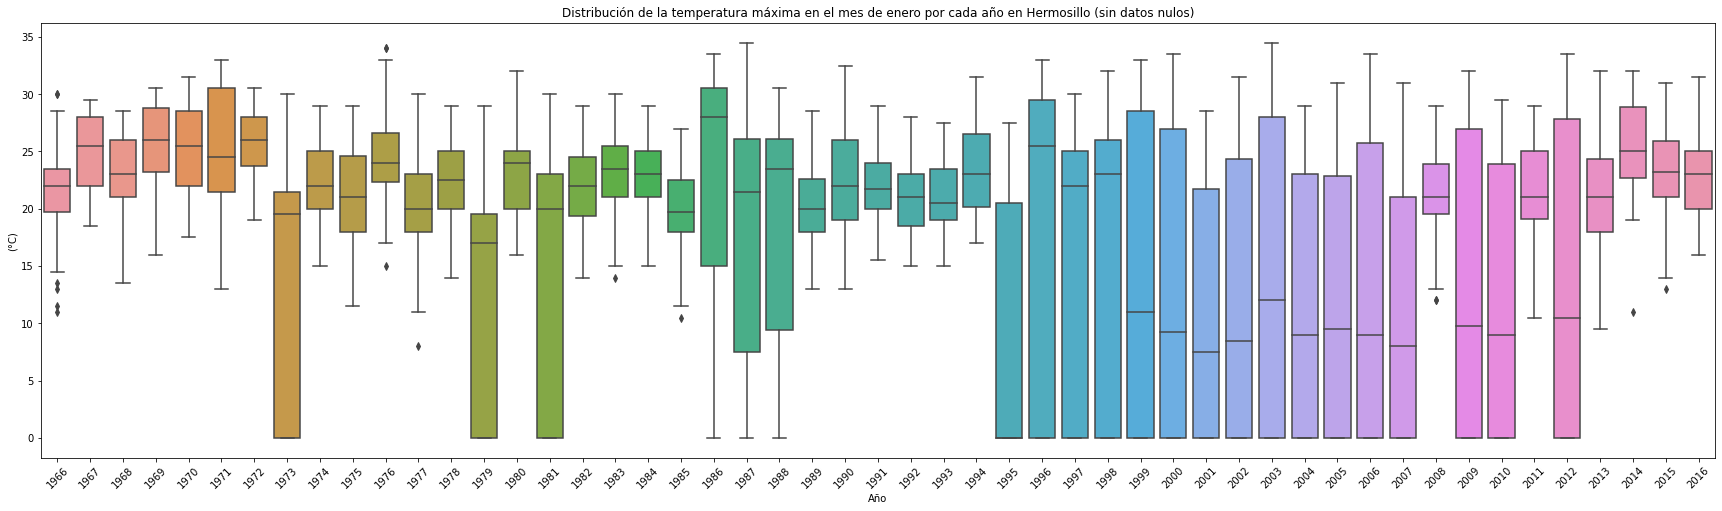

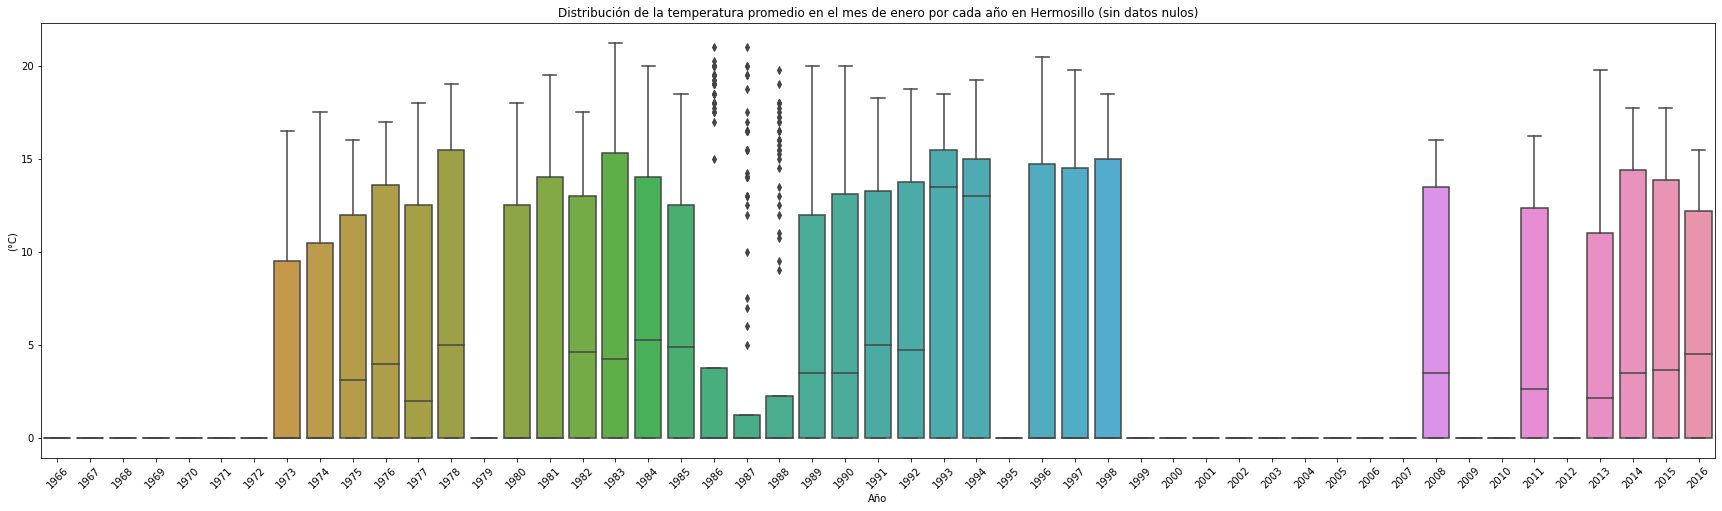

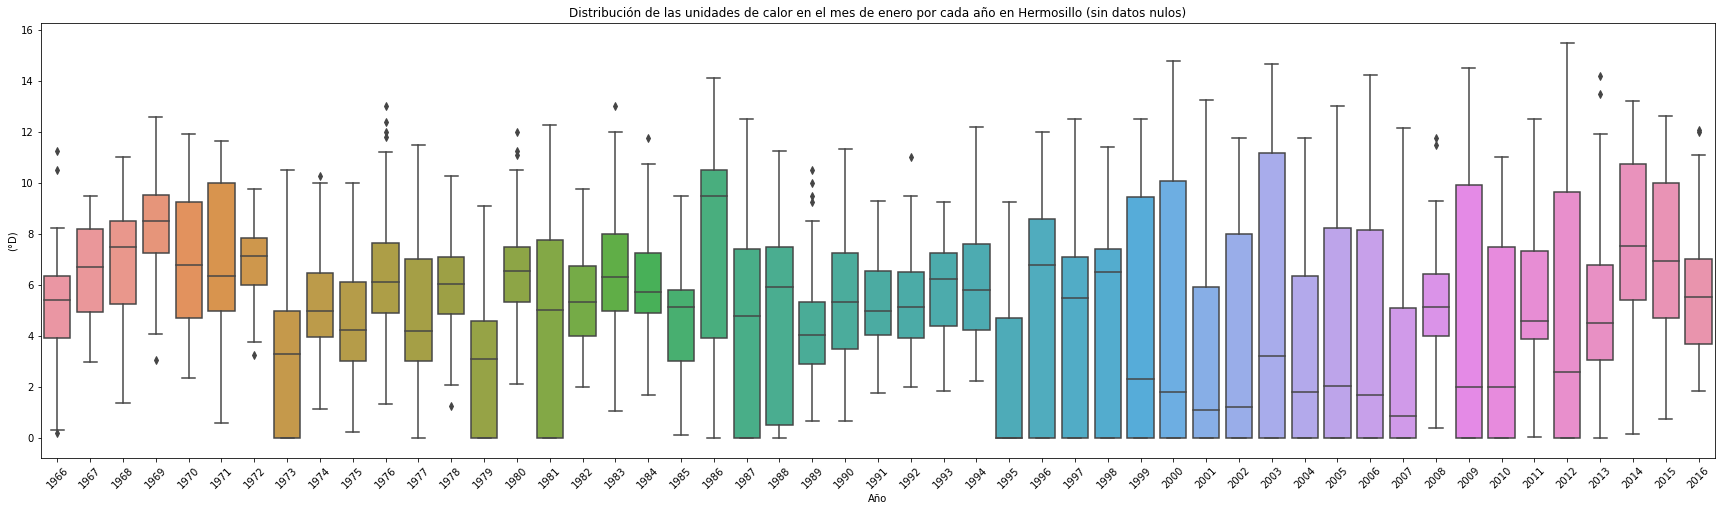

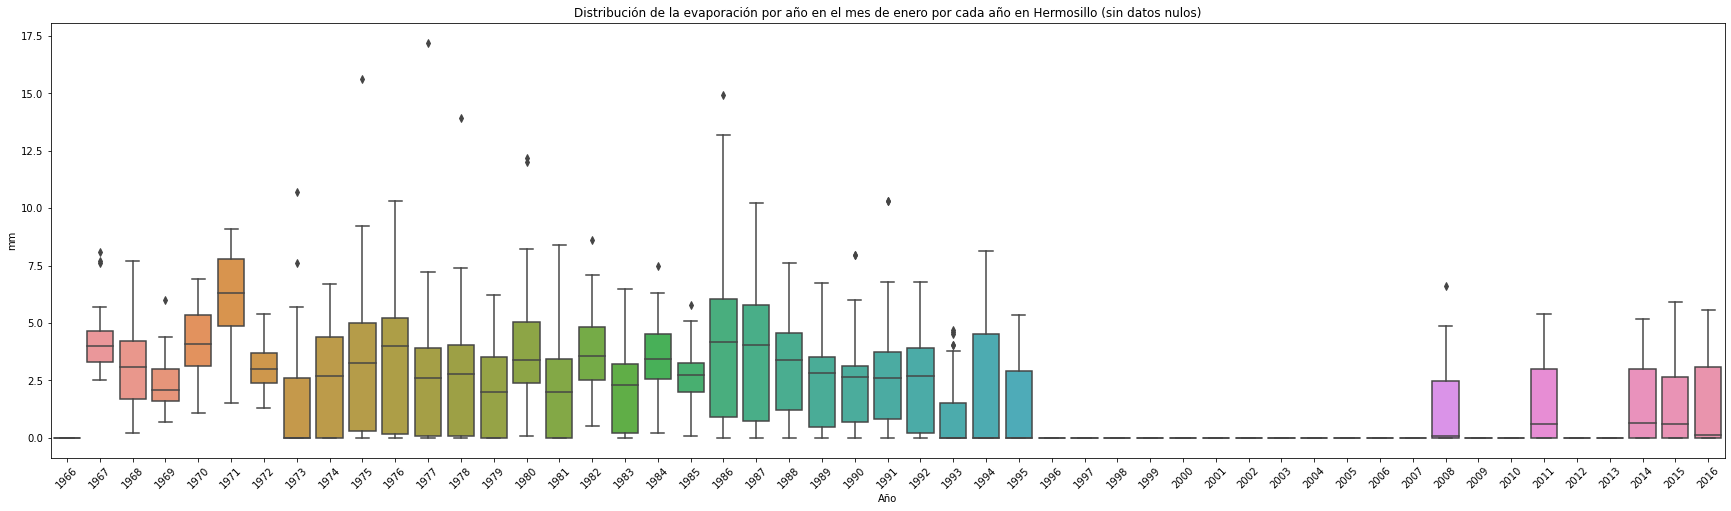

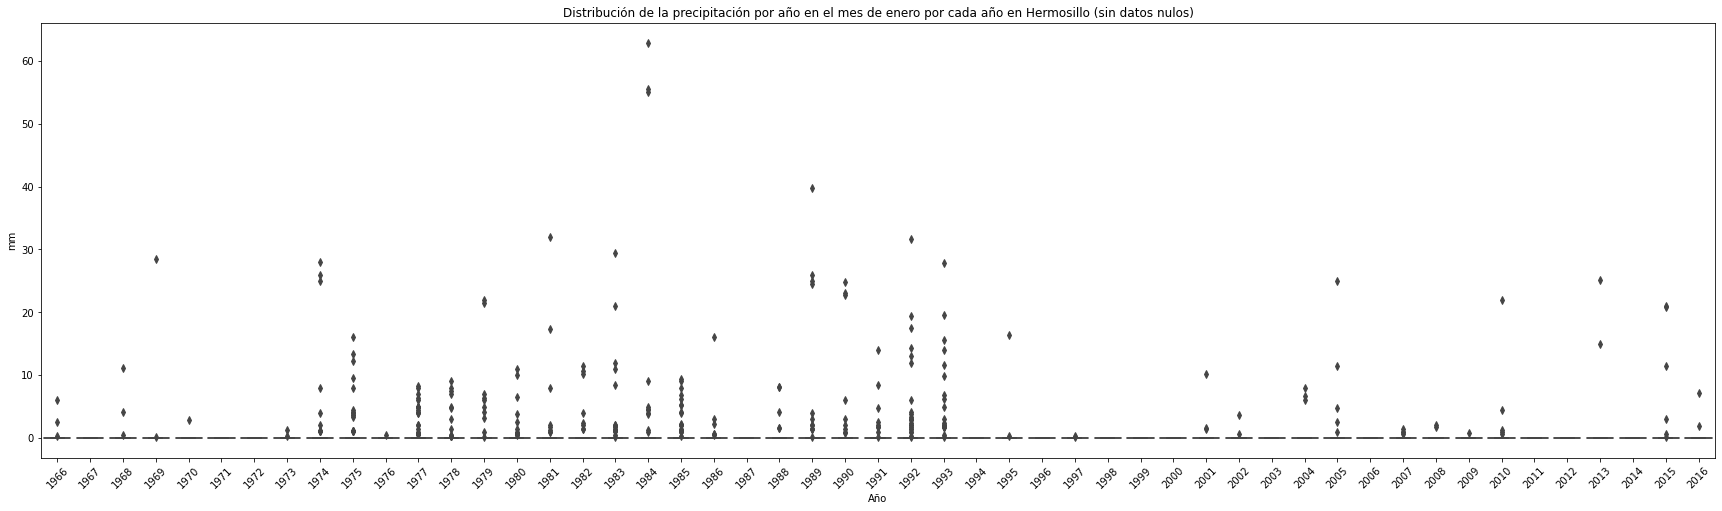

In [33]:
mes = 'enero'
for i in range(6):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Febrero

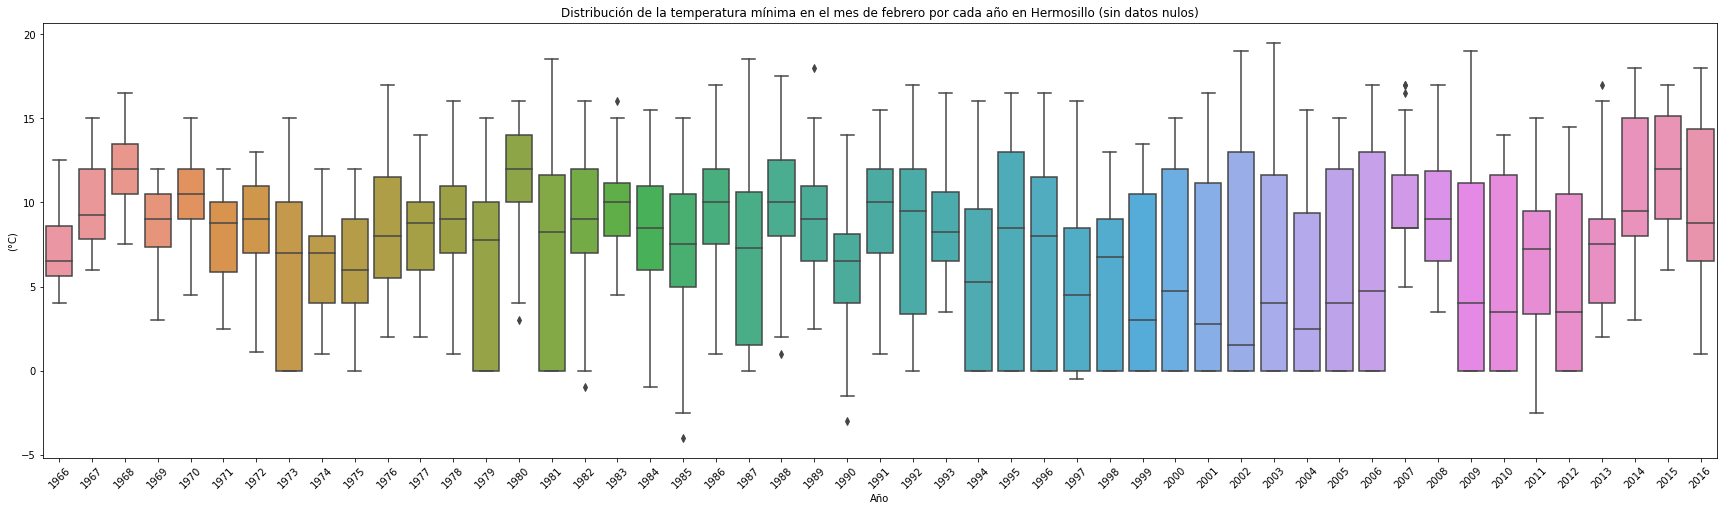

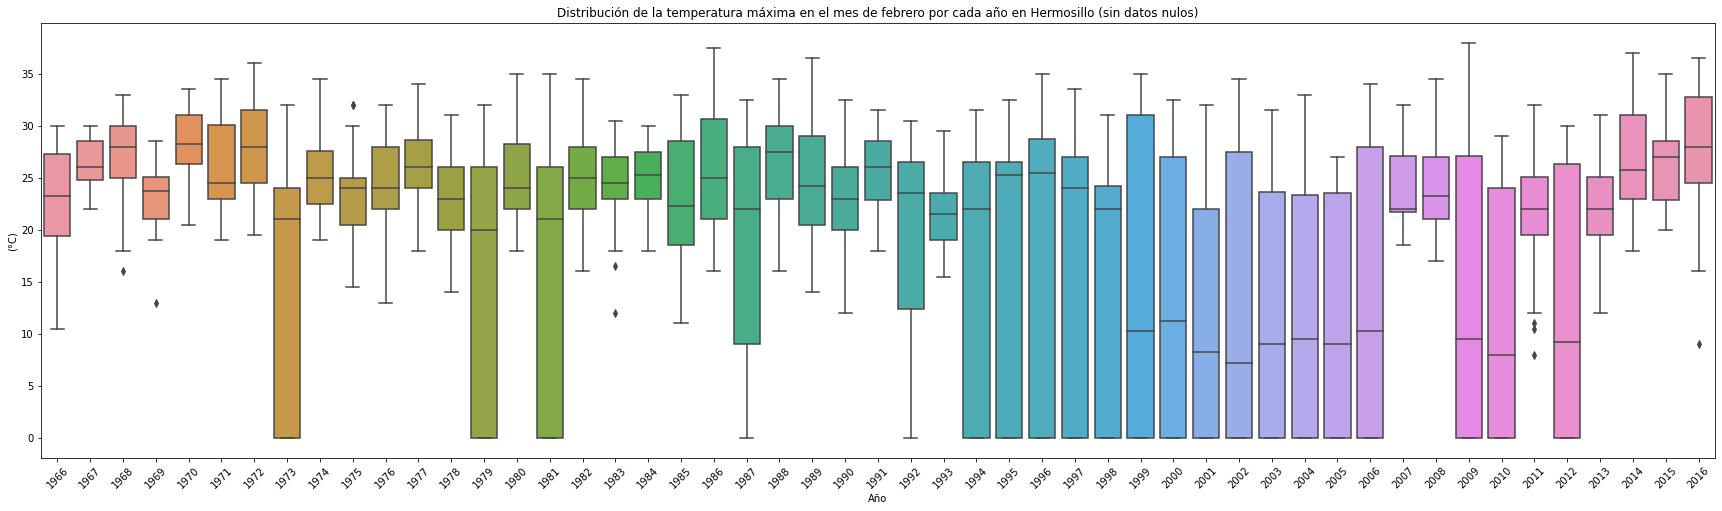

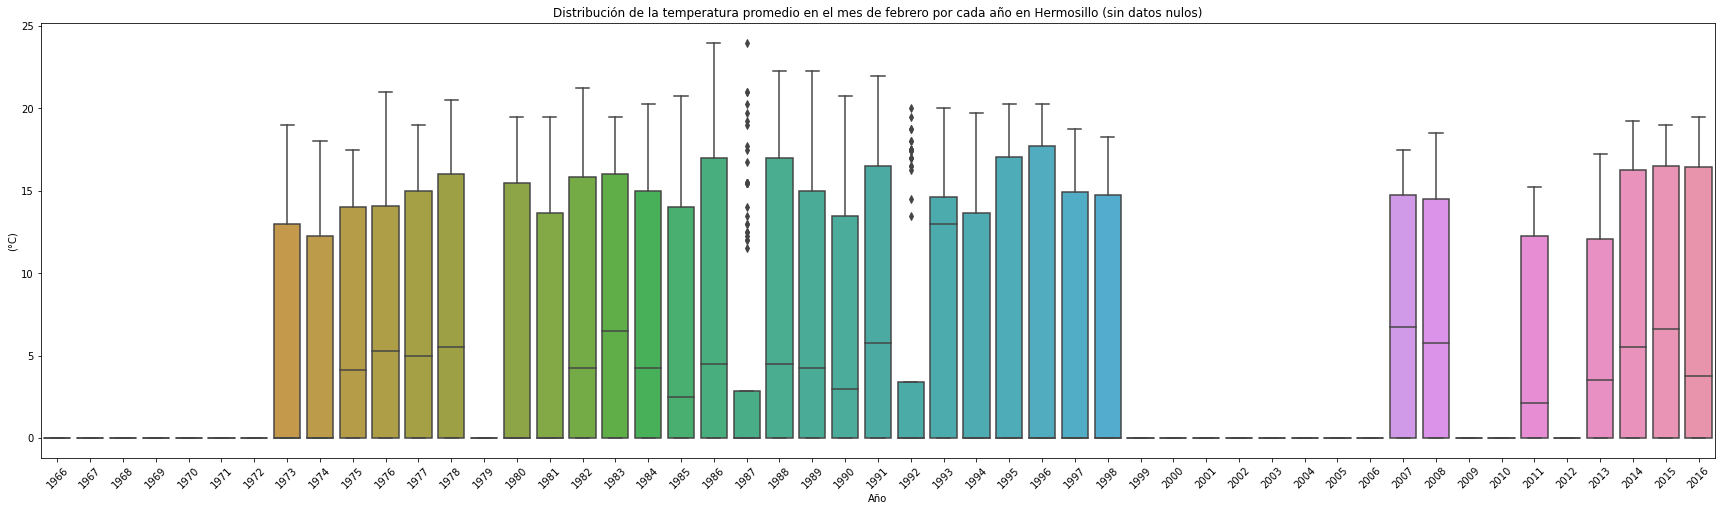

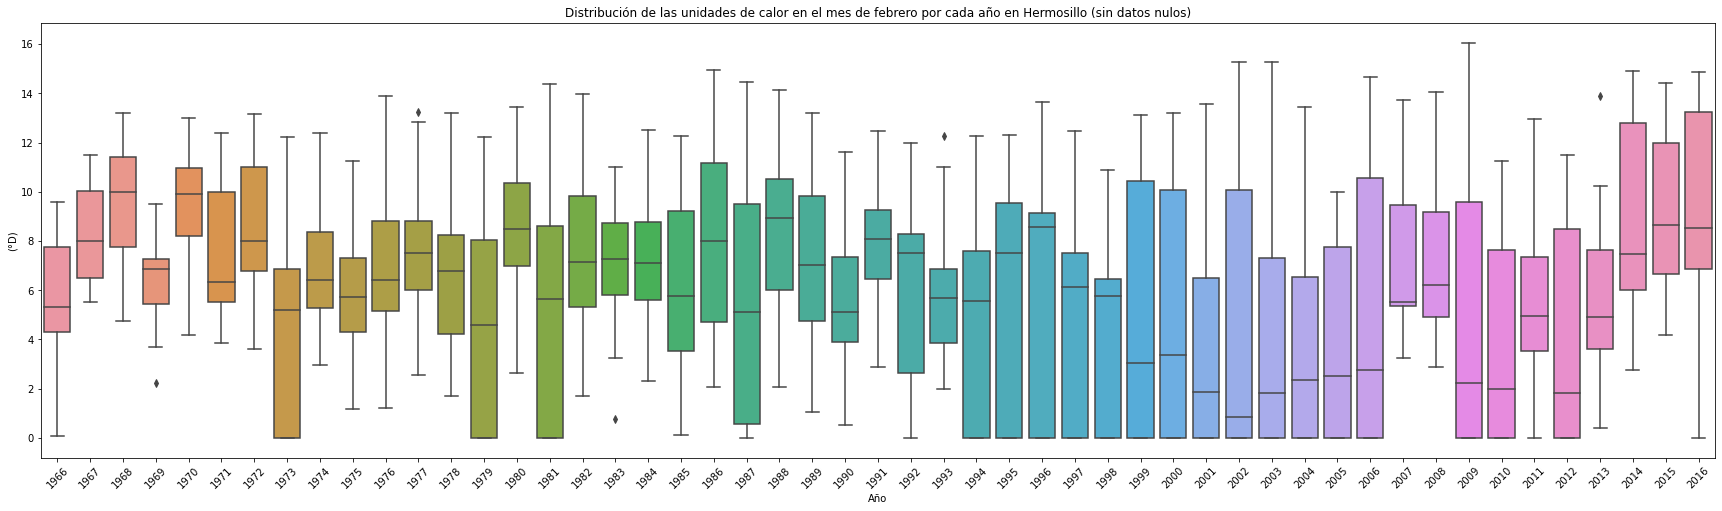

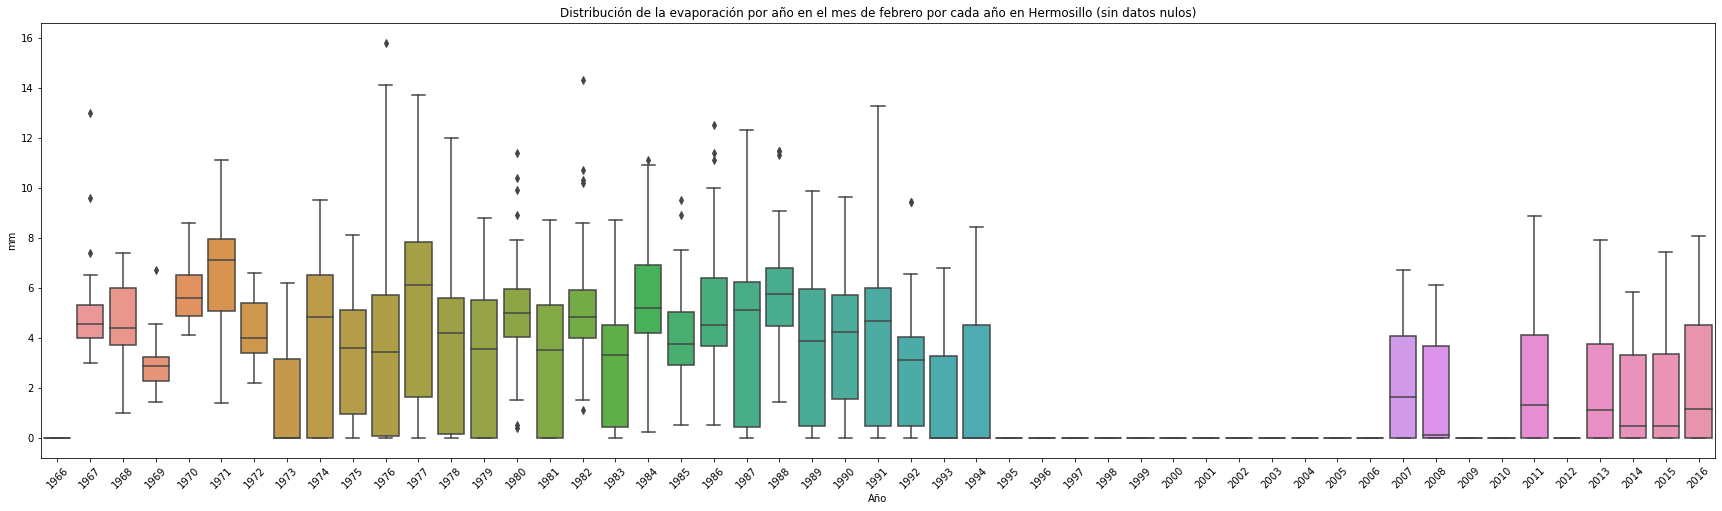

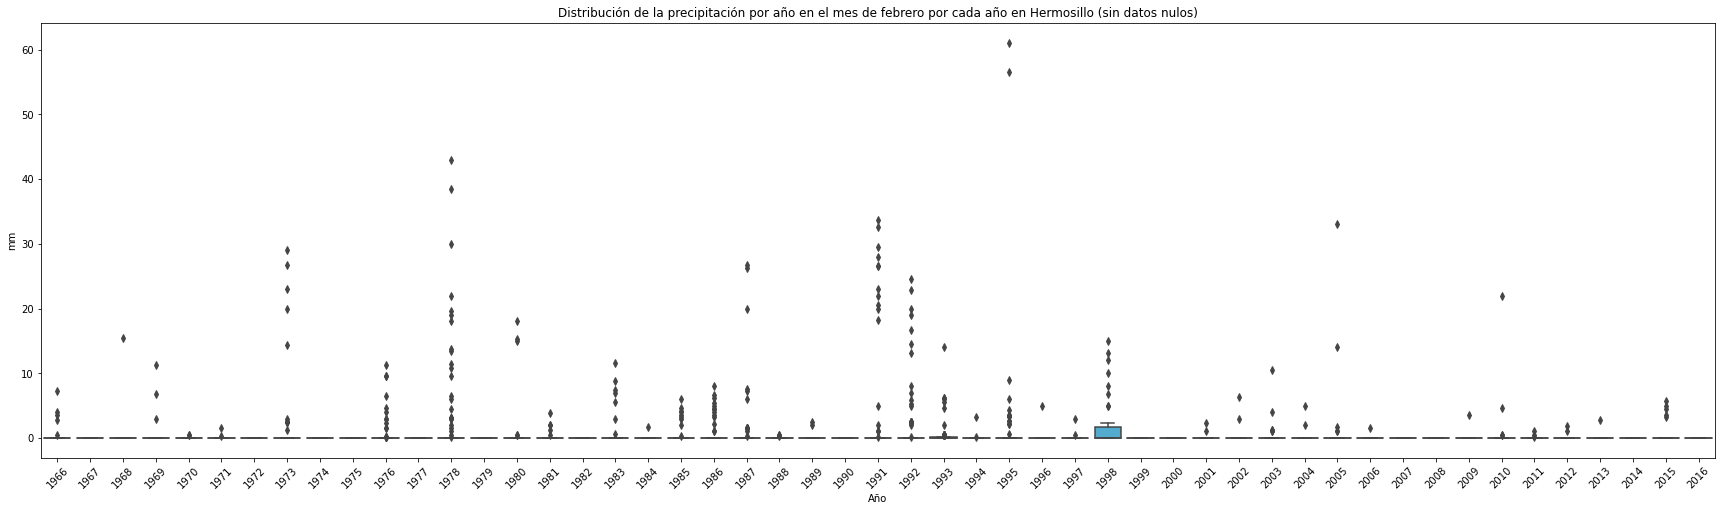

In [34]:
mes = 'febrero'
for i in range(6):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Marzo

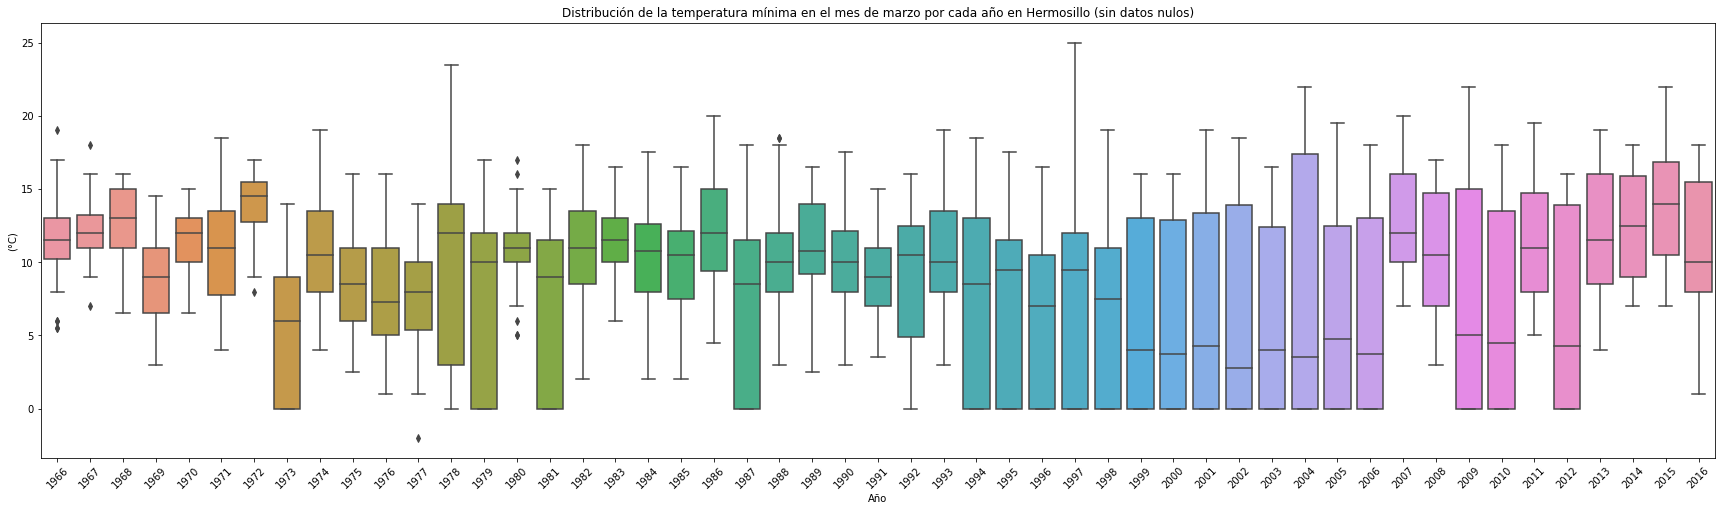

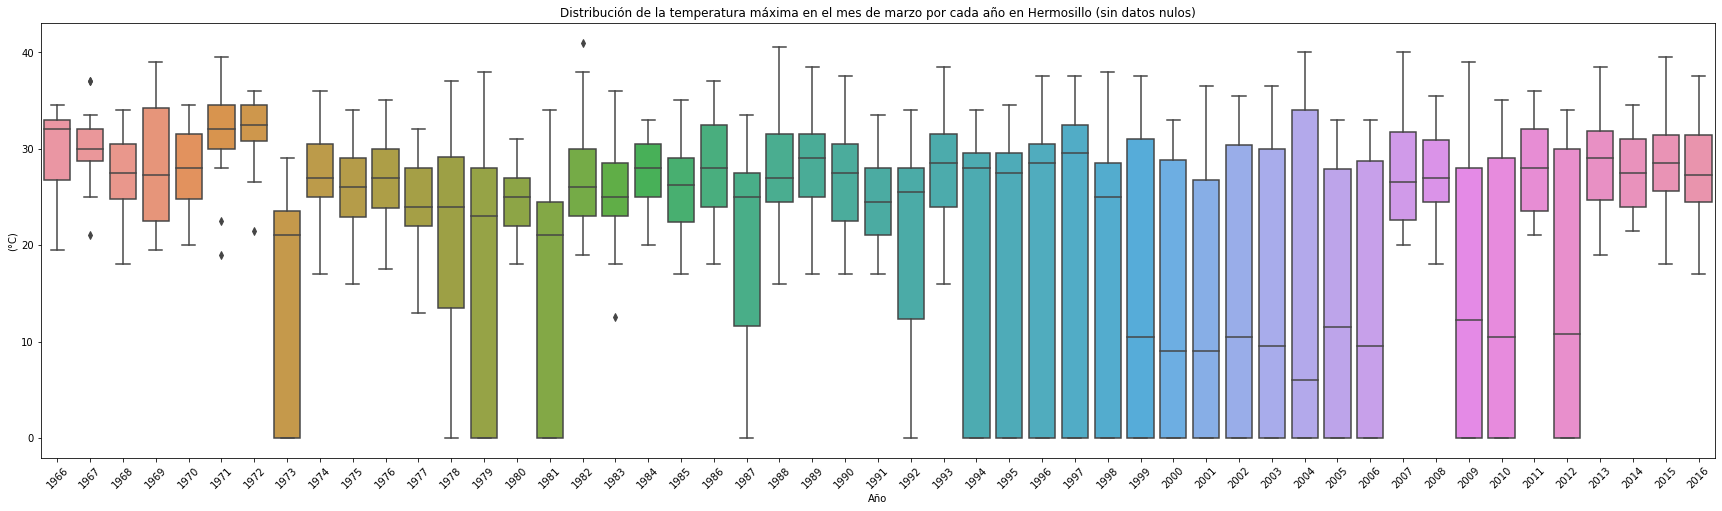

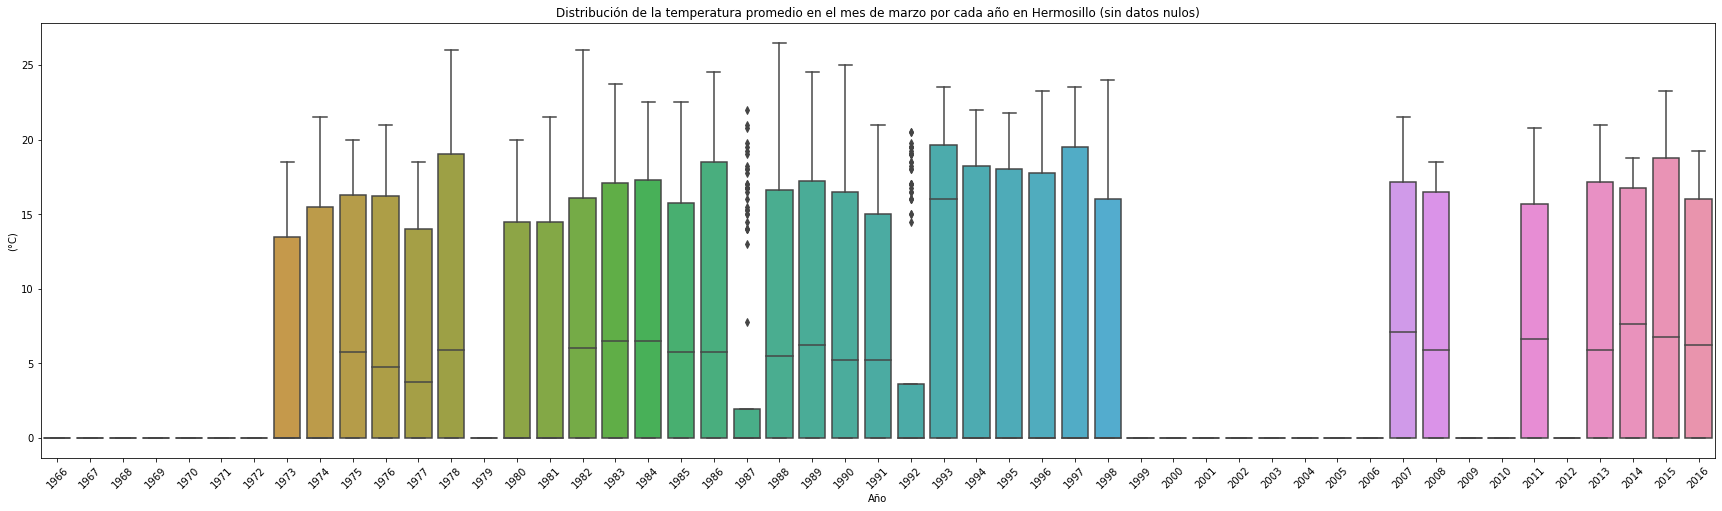

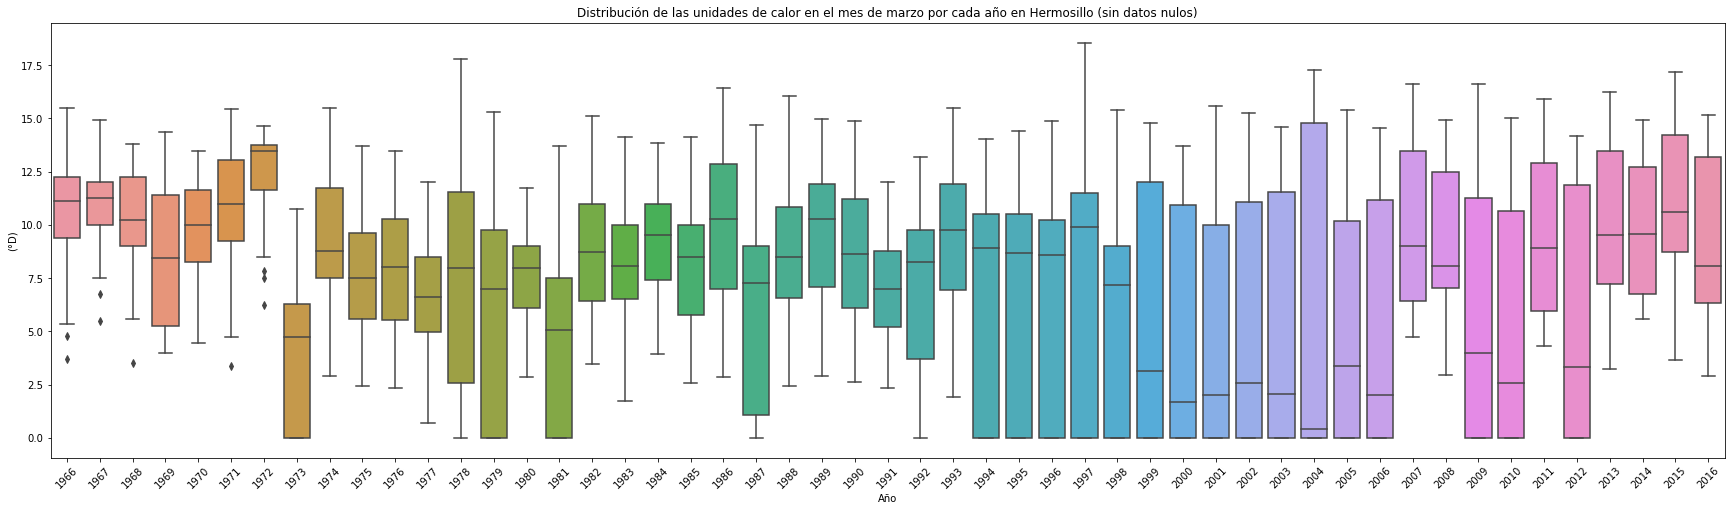

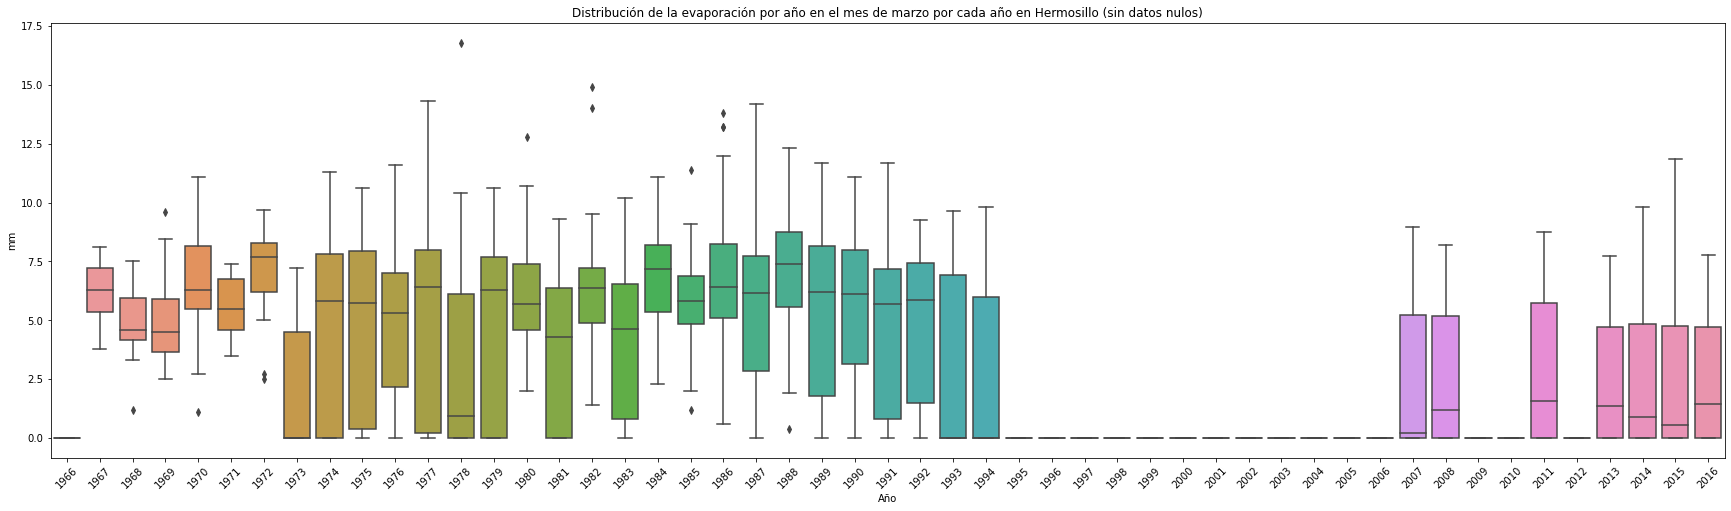

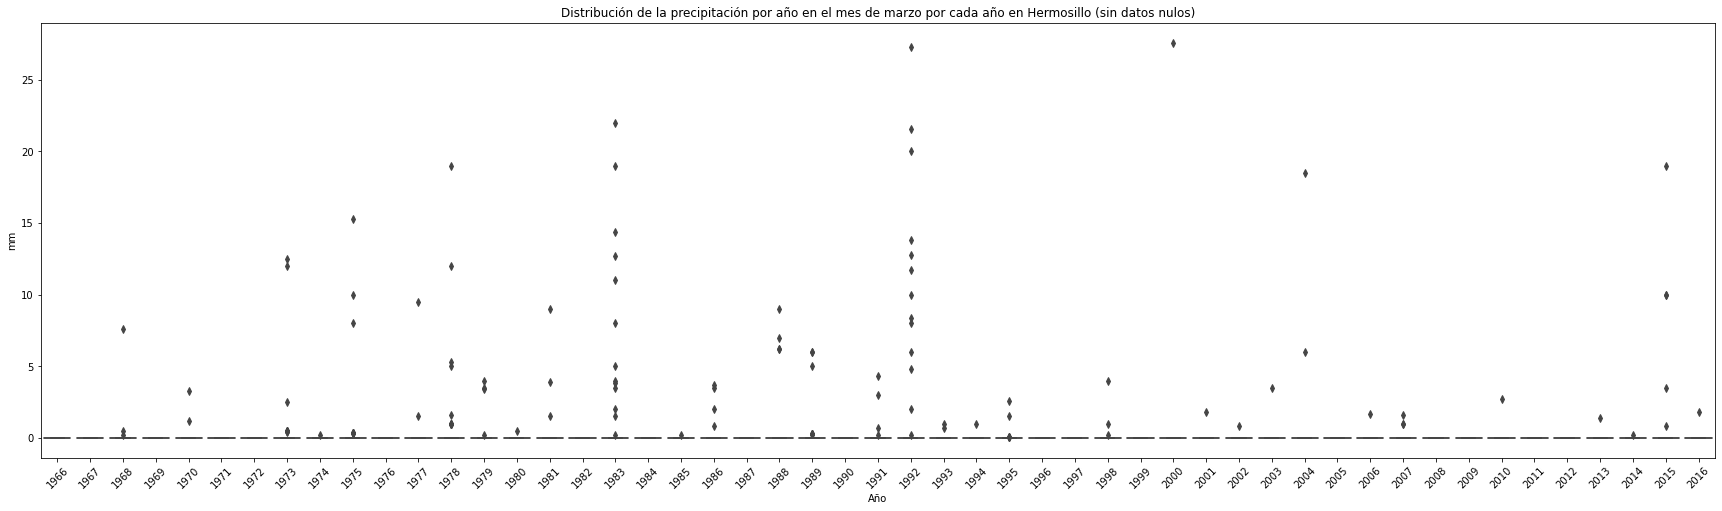

In [35]:
mes = 'marzo'
for i in range(6):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Abril

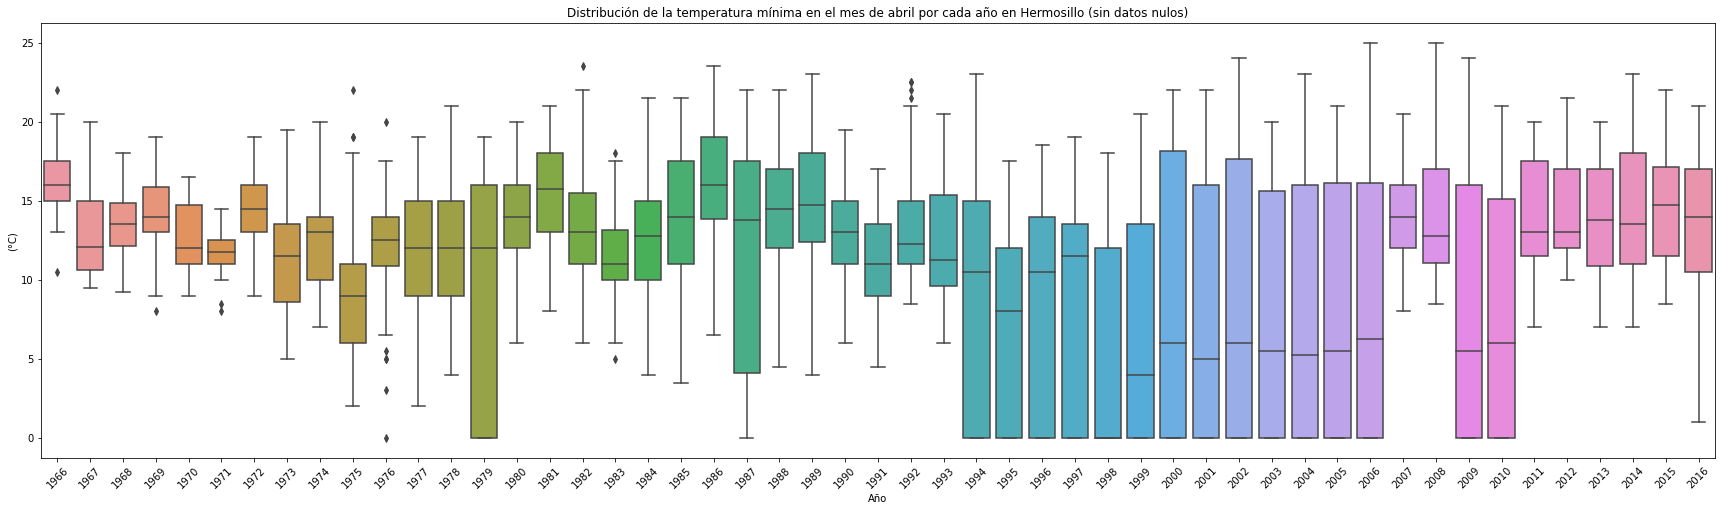

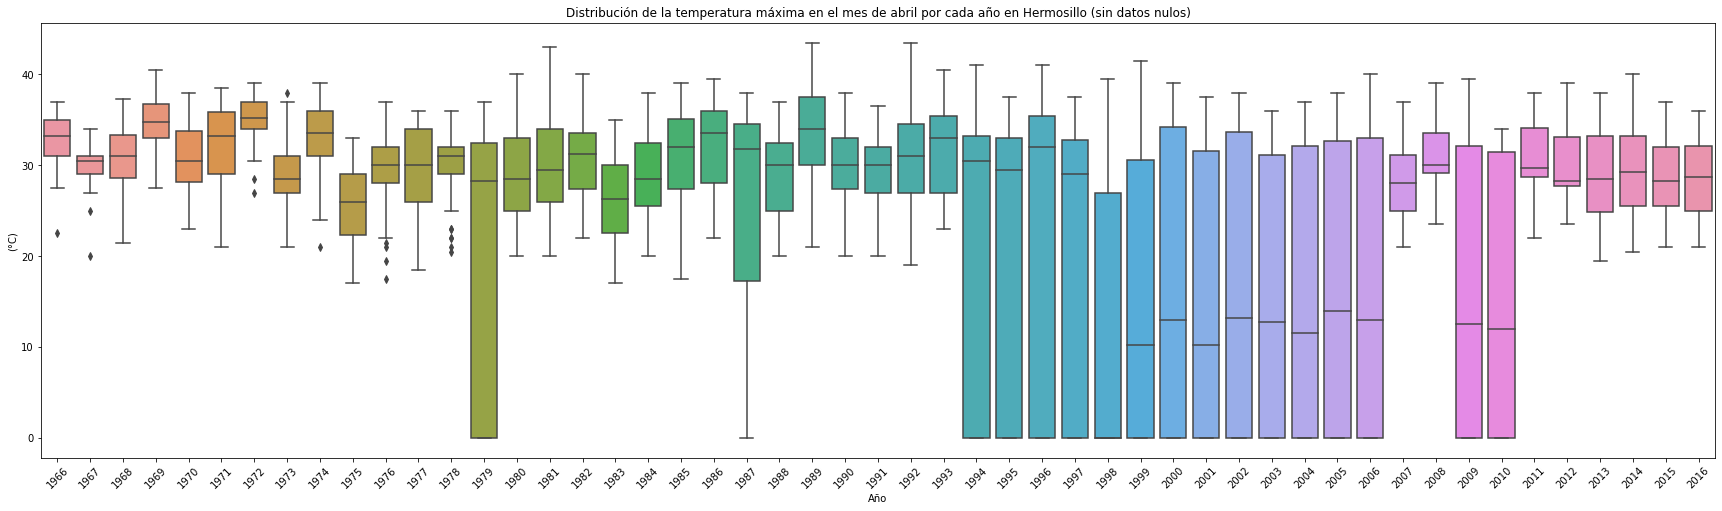

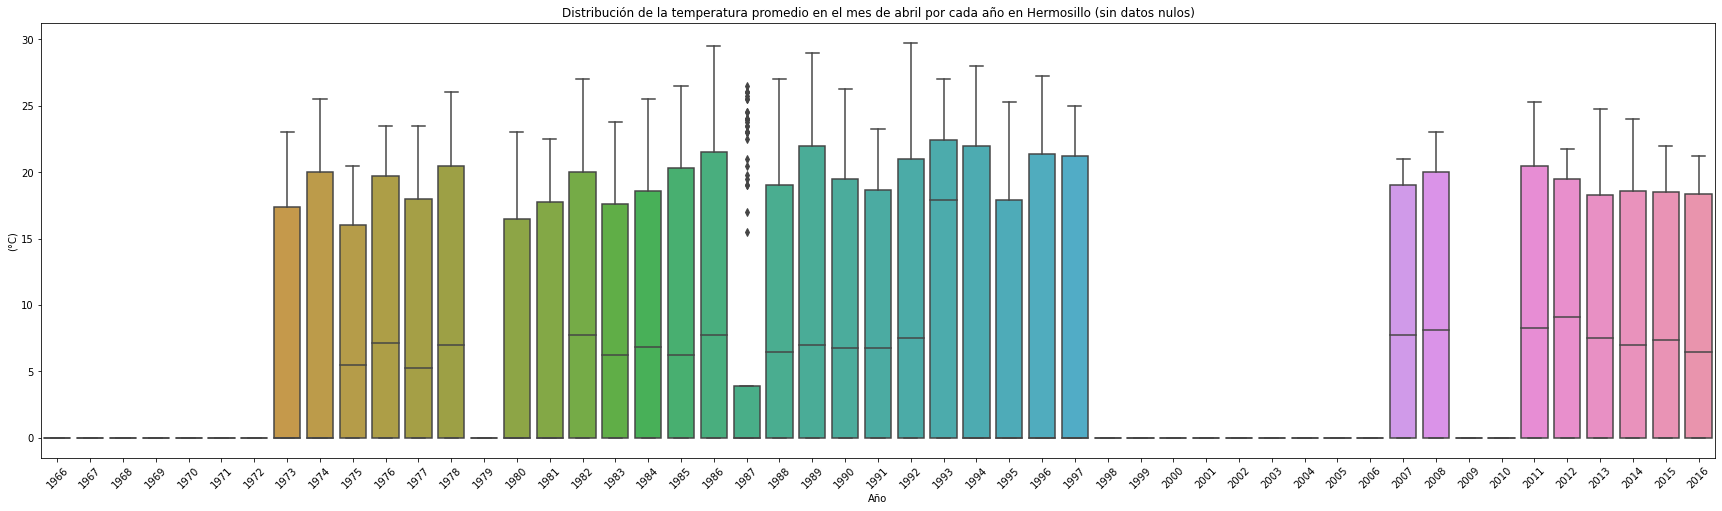

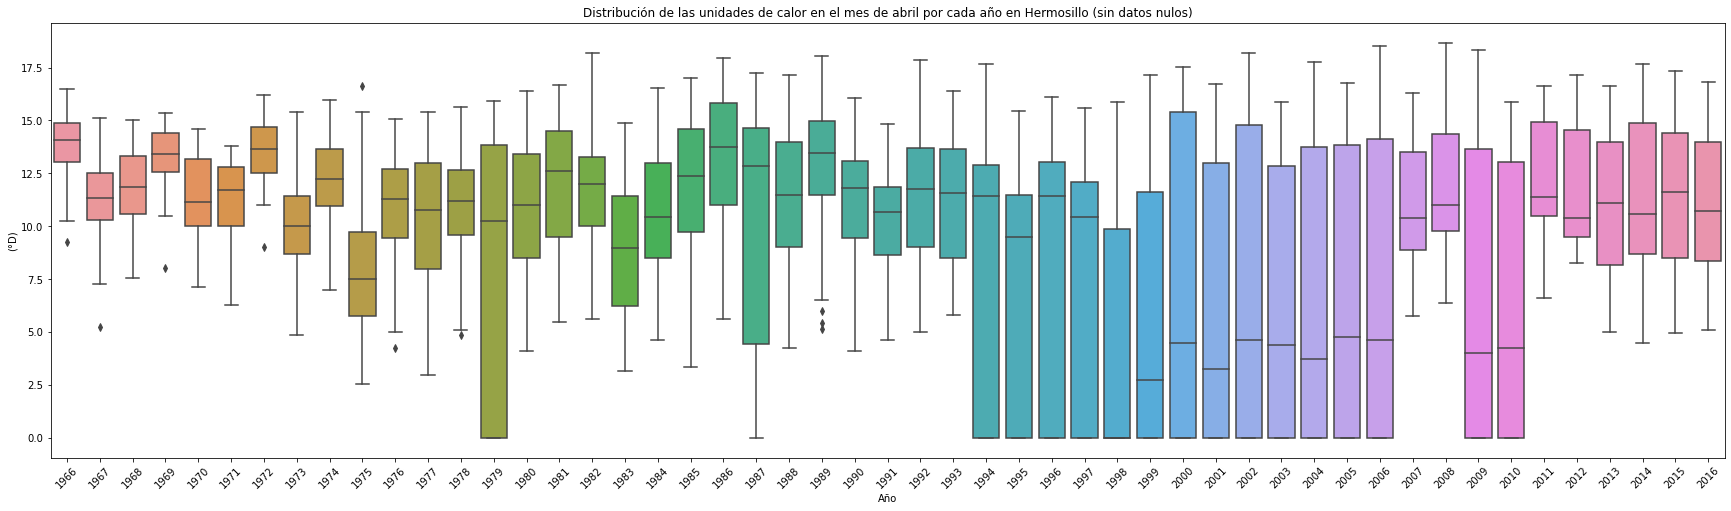

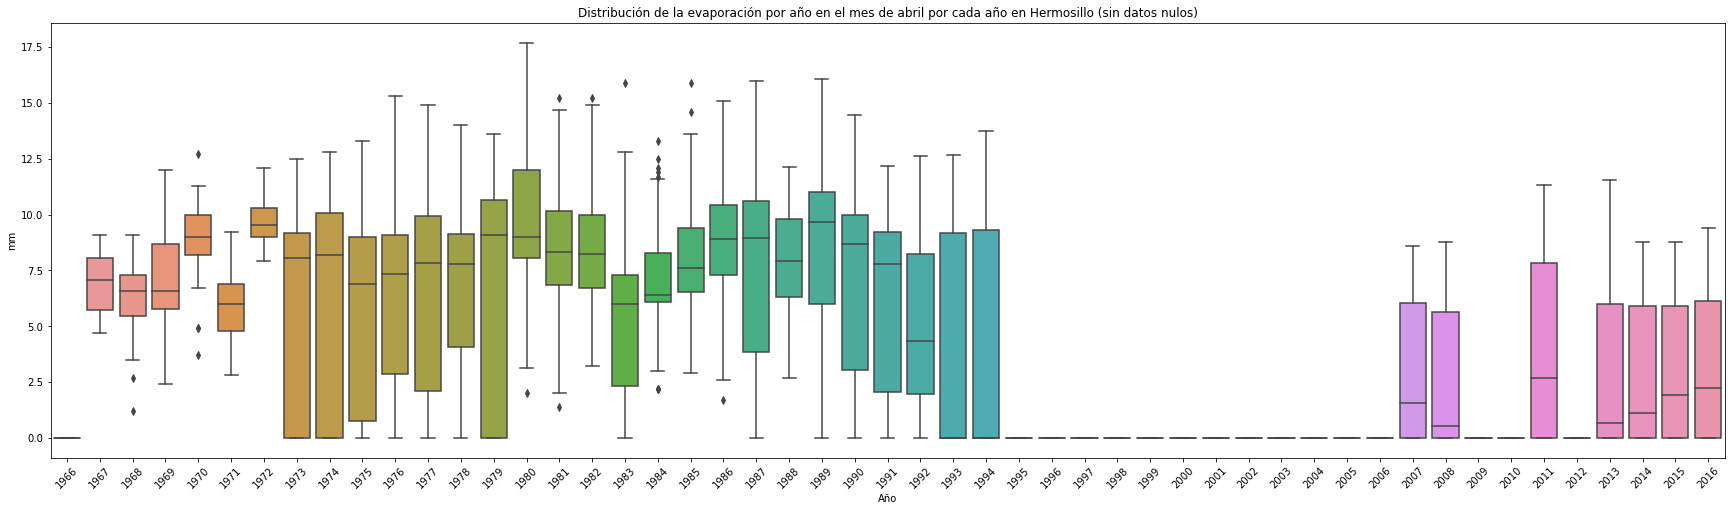

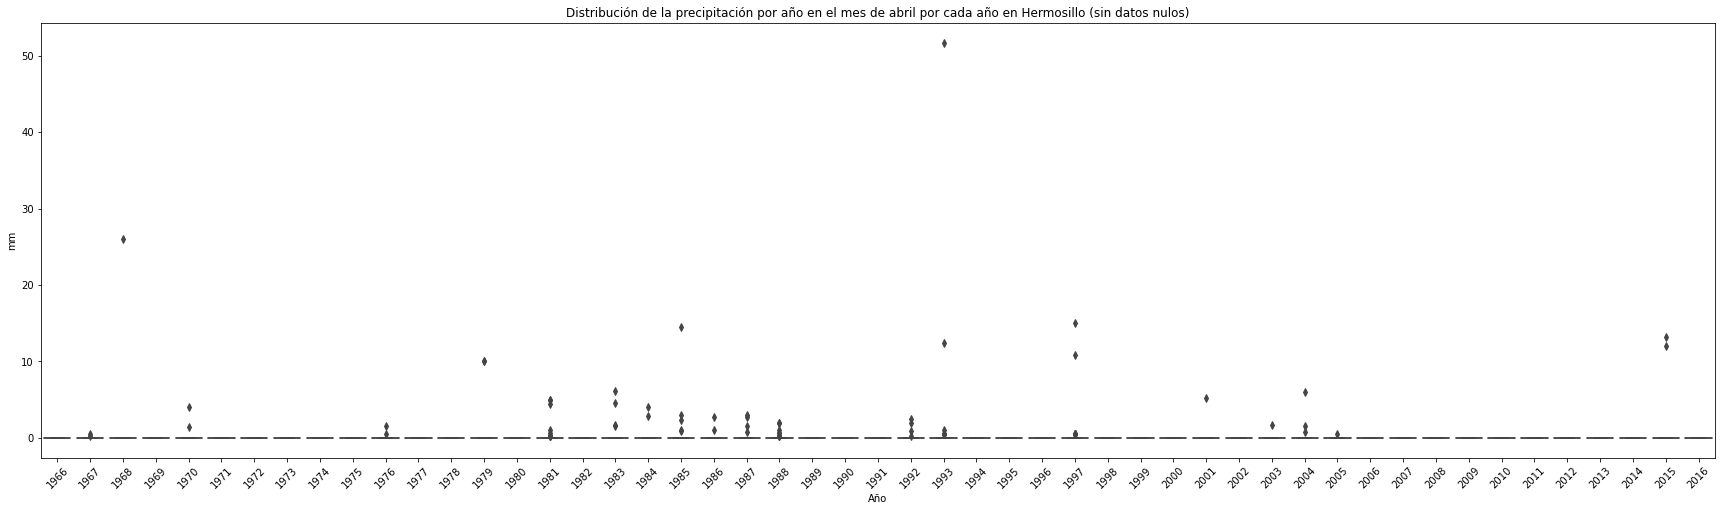

In [36]:
mes = 'abril'
for i in range(6):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Mayo

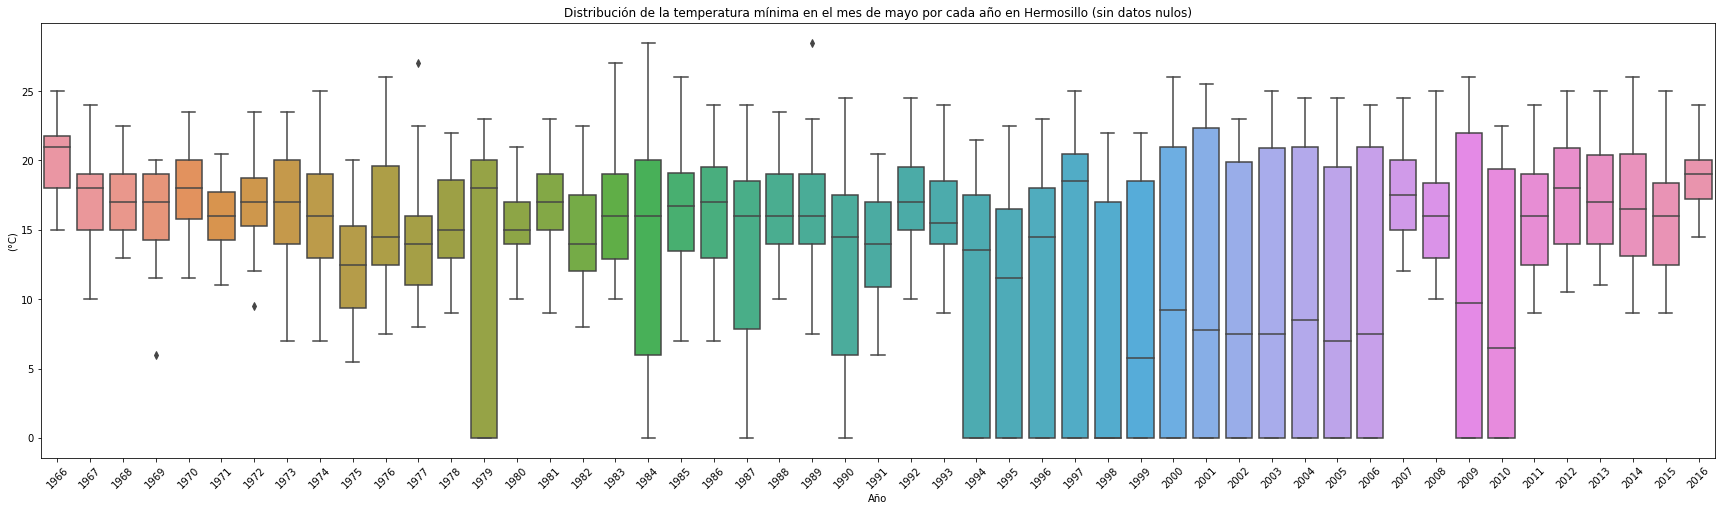

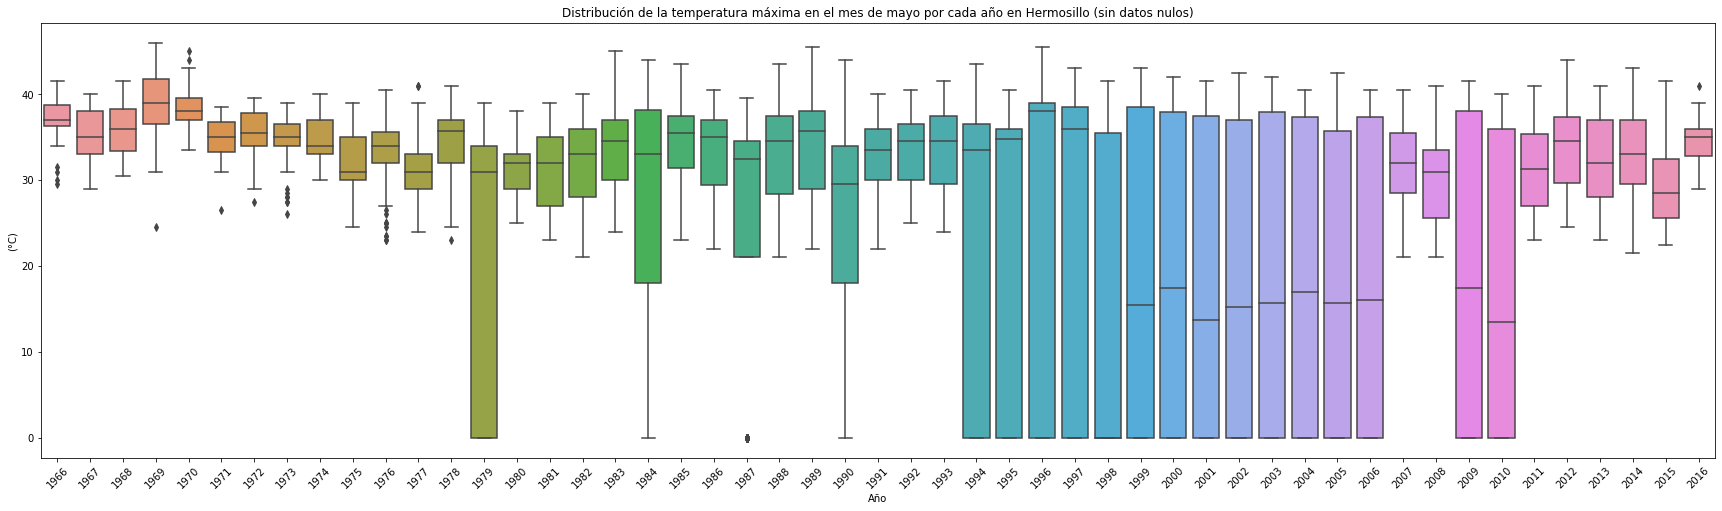

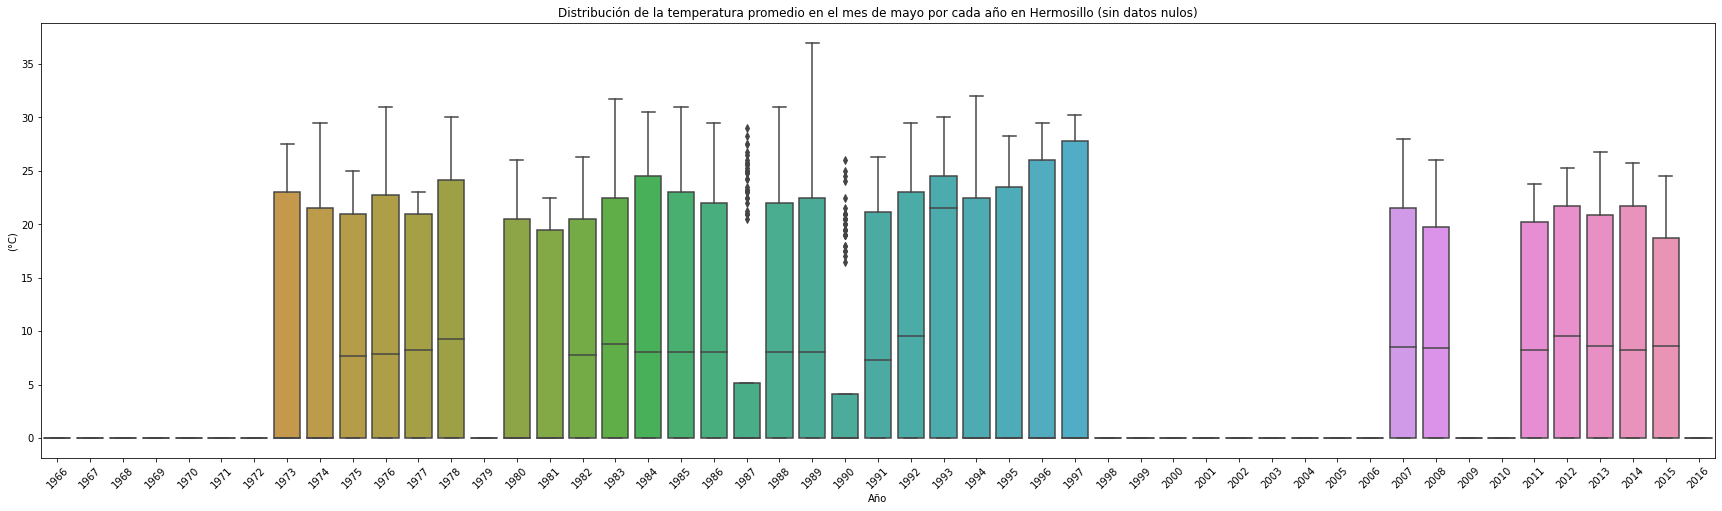

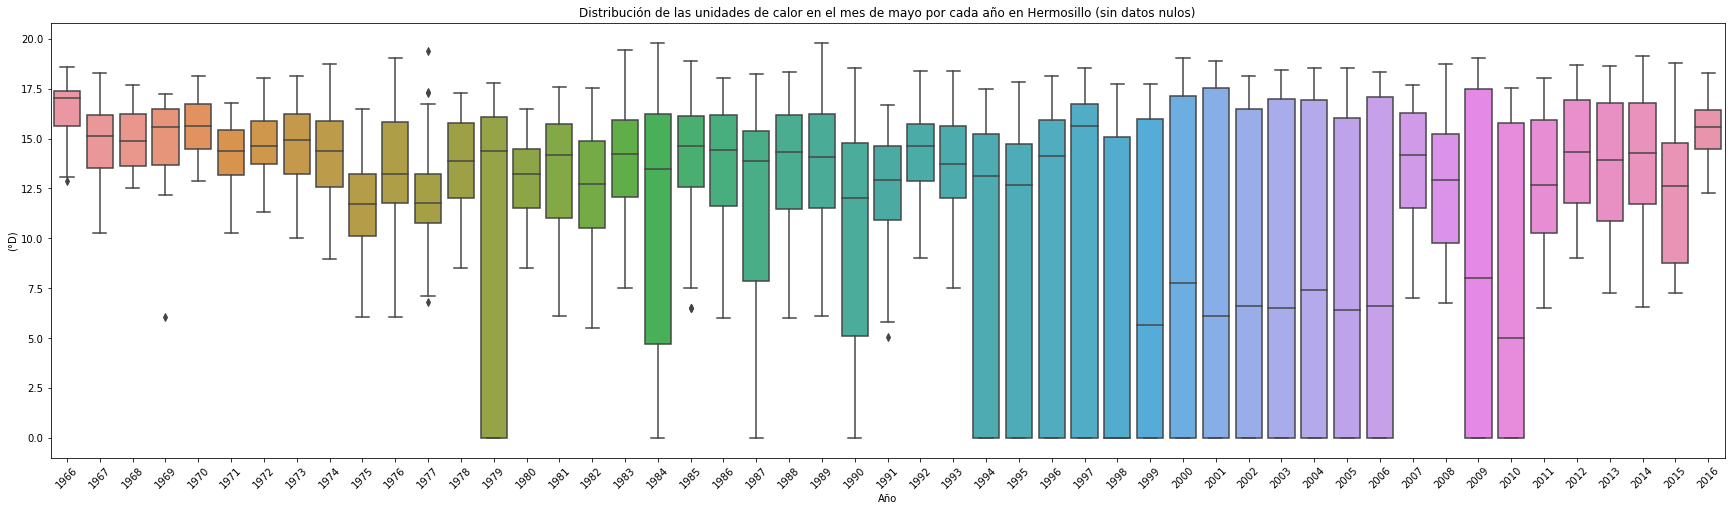

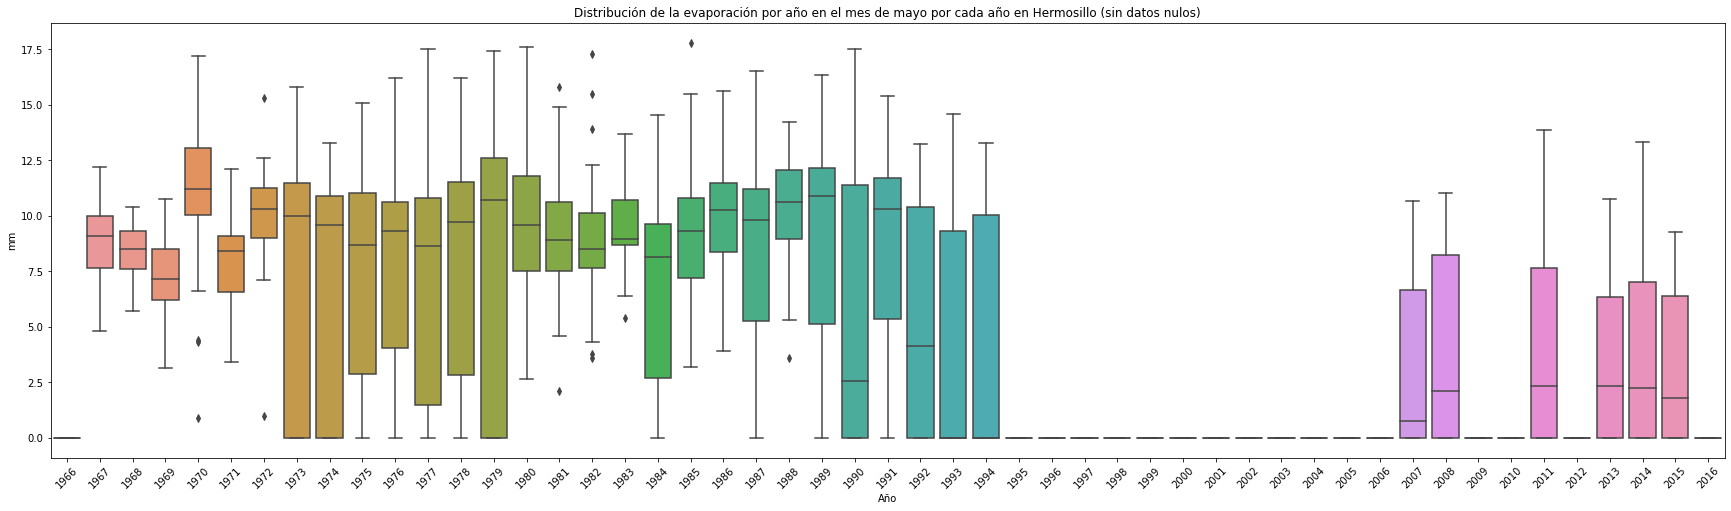

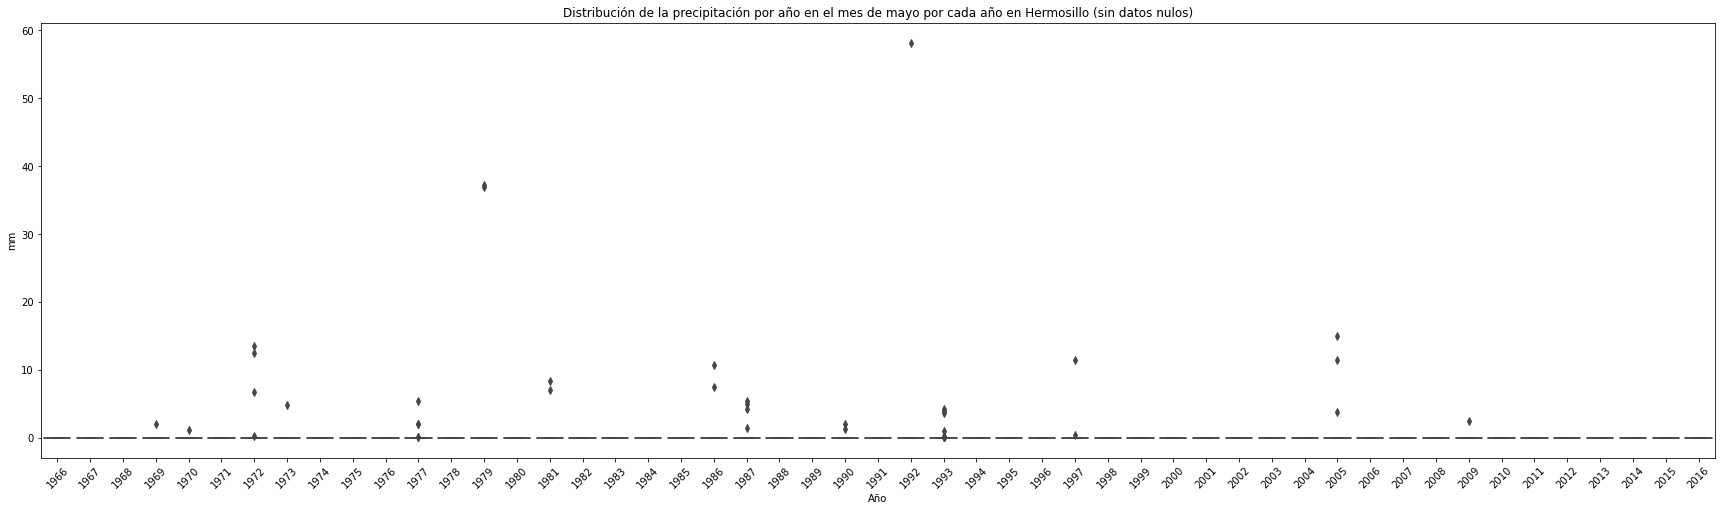

In [37]:
mes = 'mayo'
for i in range(6):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Junio

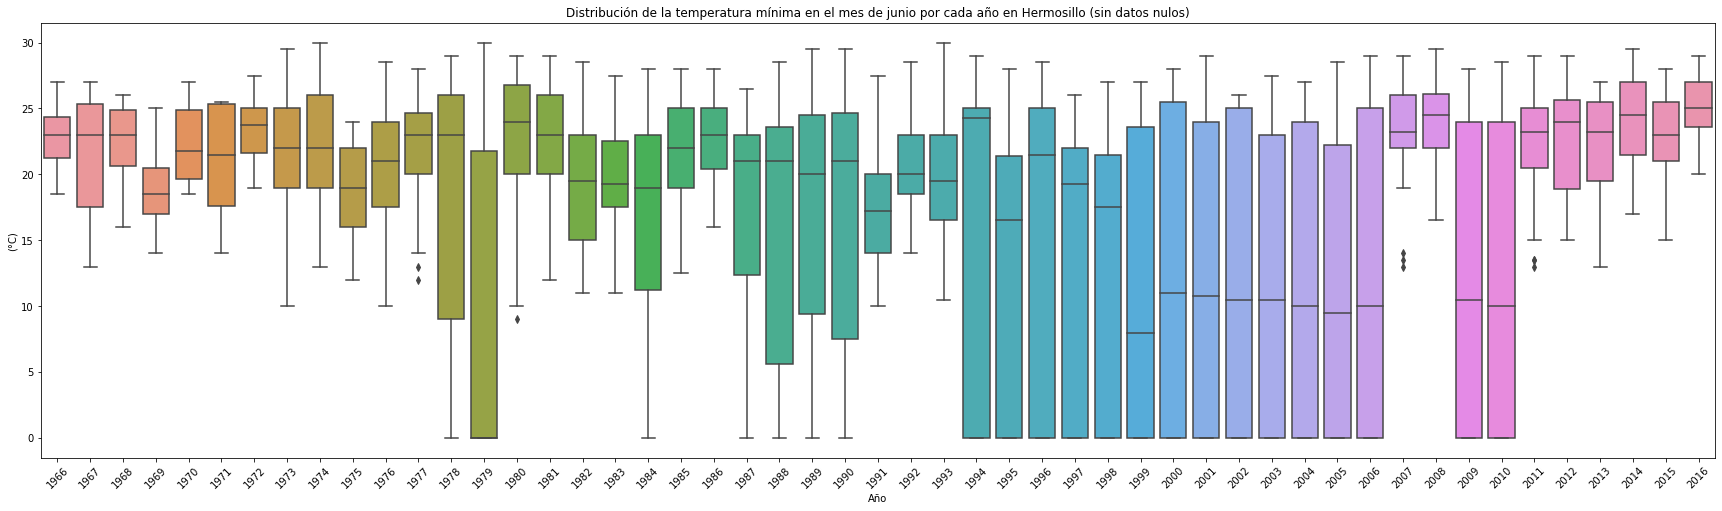

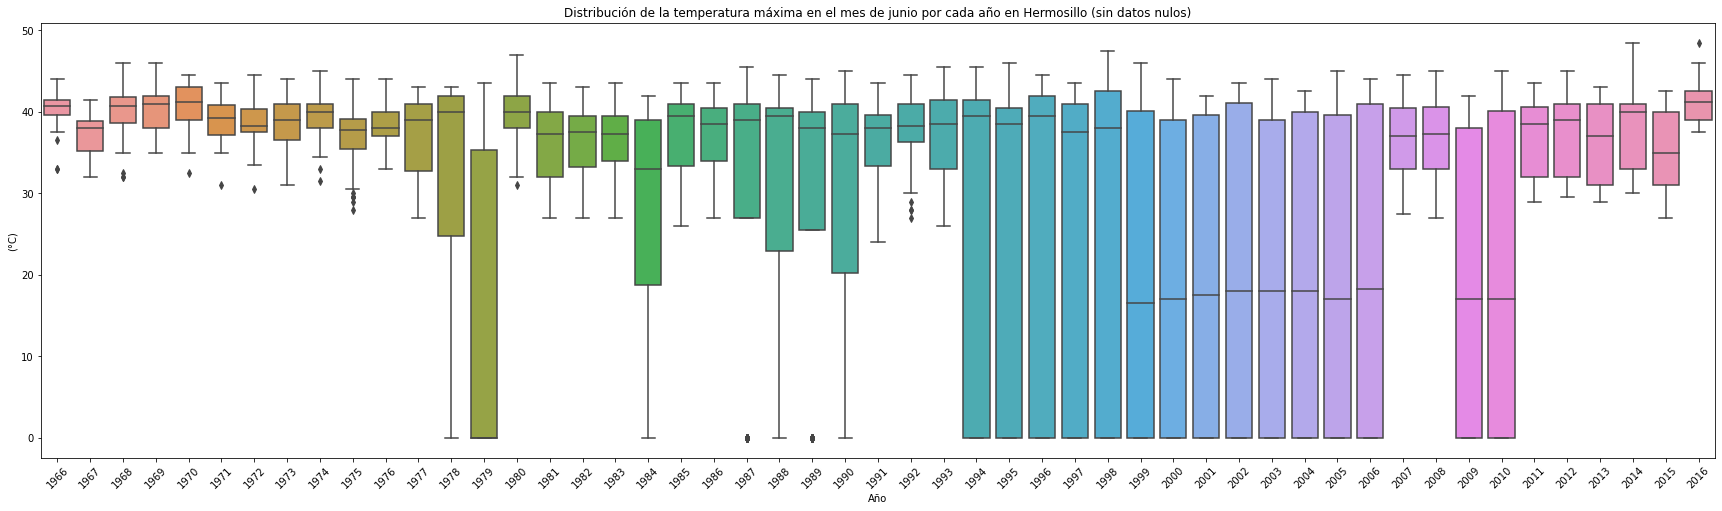

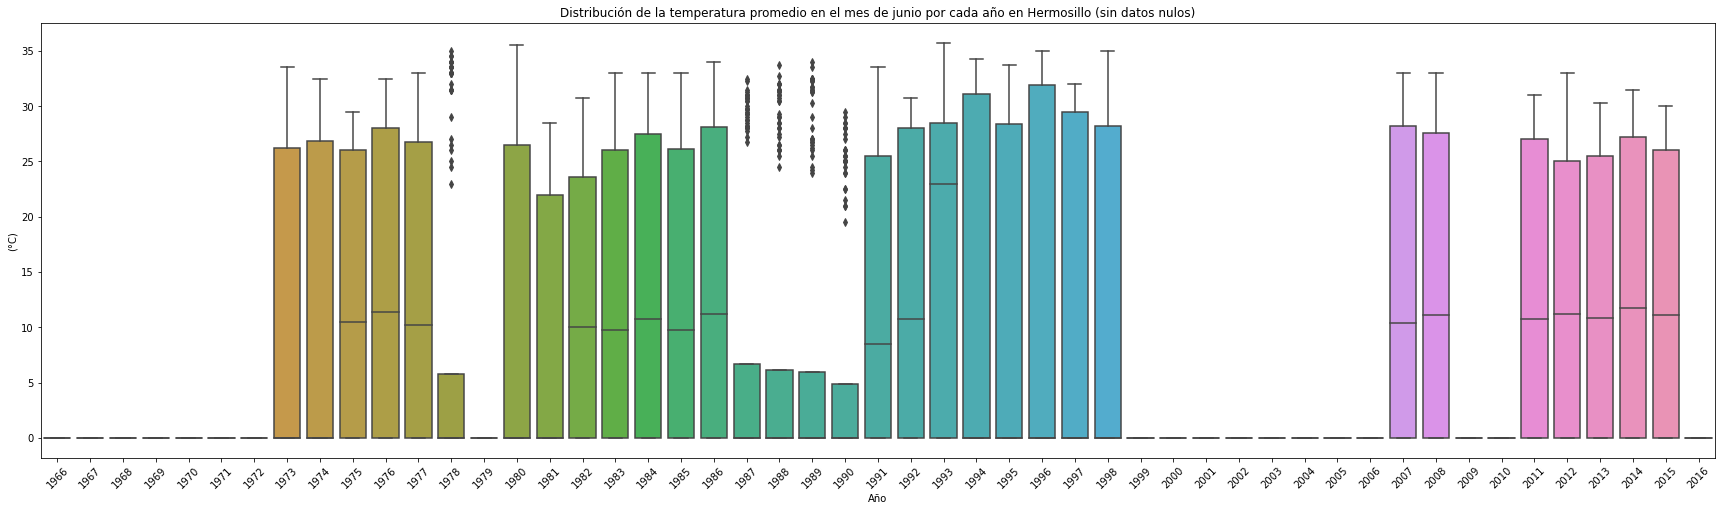

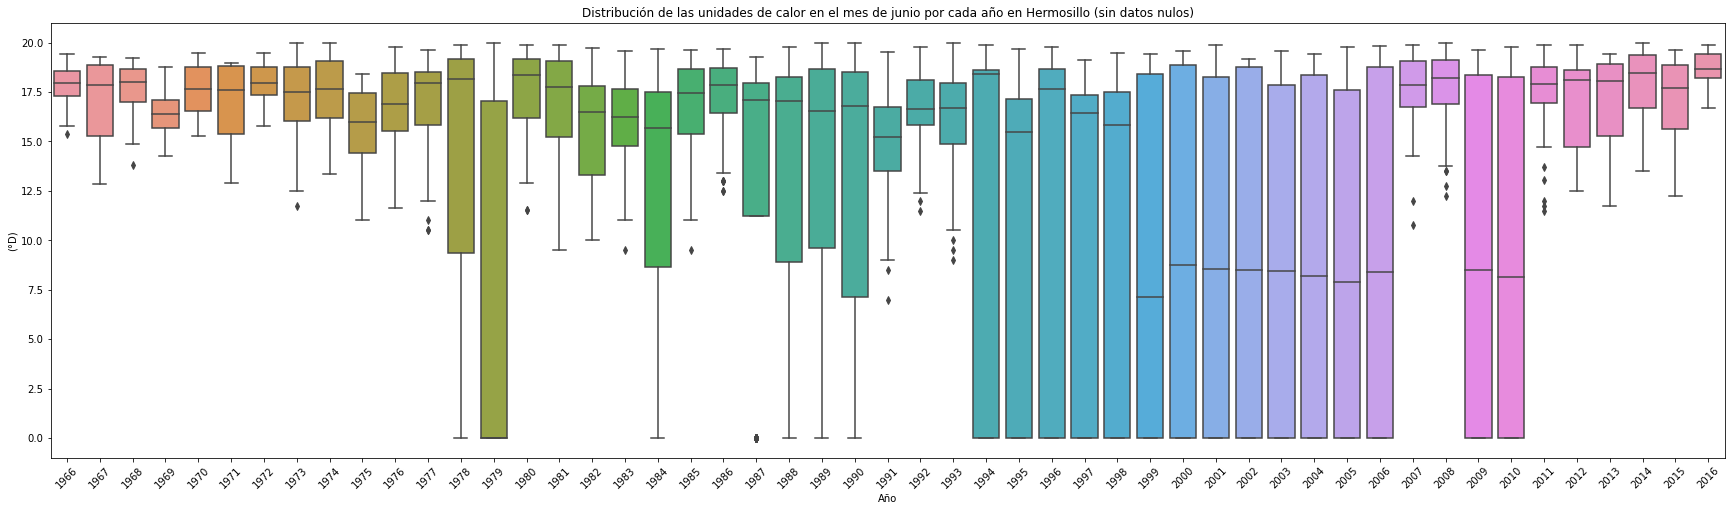

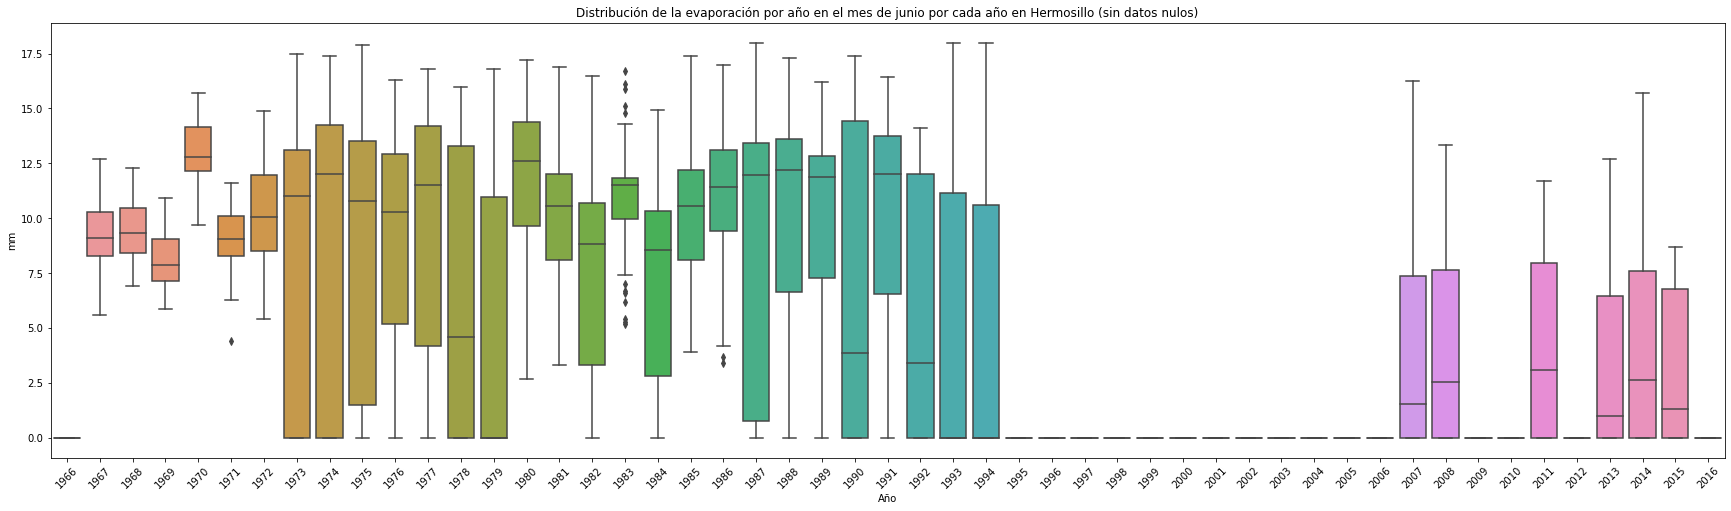

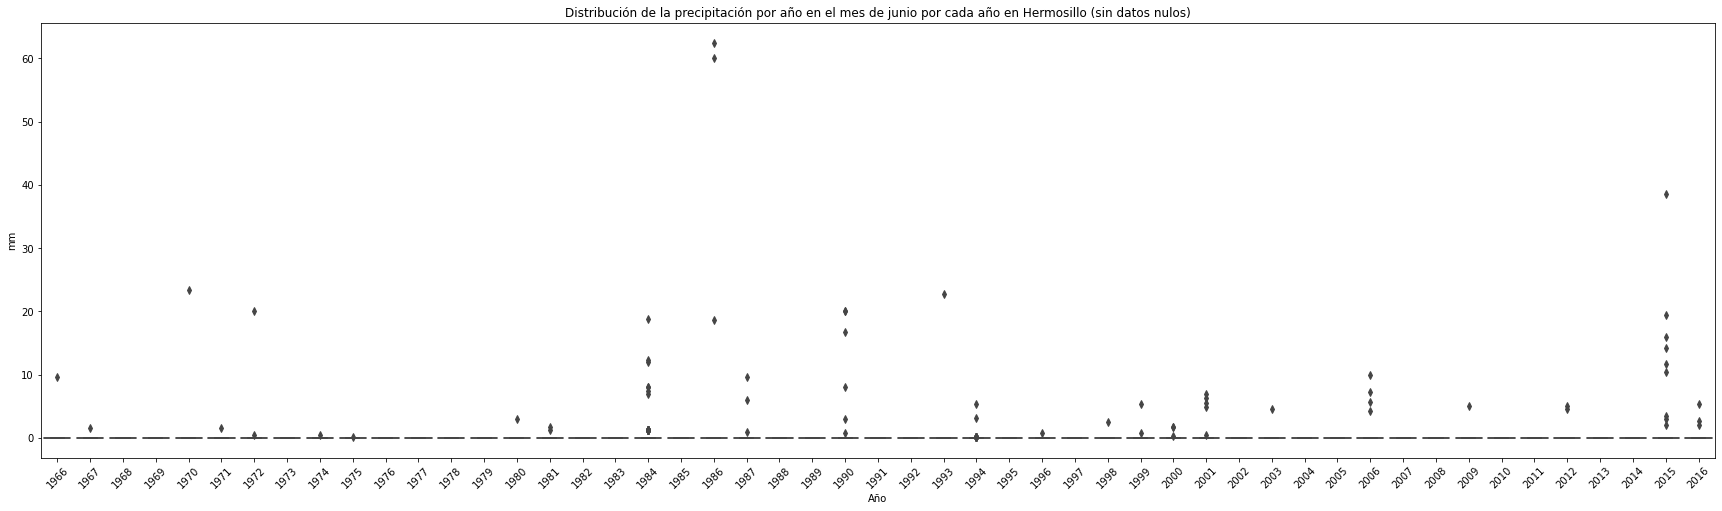

In [38]:
mes = 'junio'
for i in range(6):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Julio

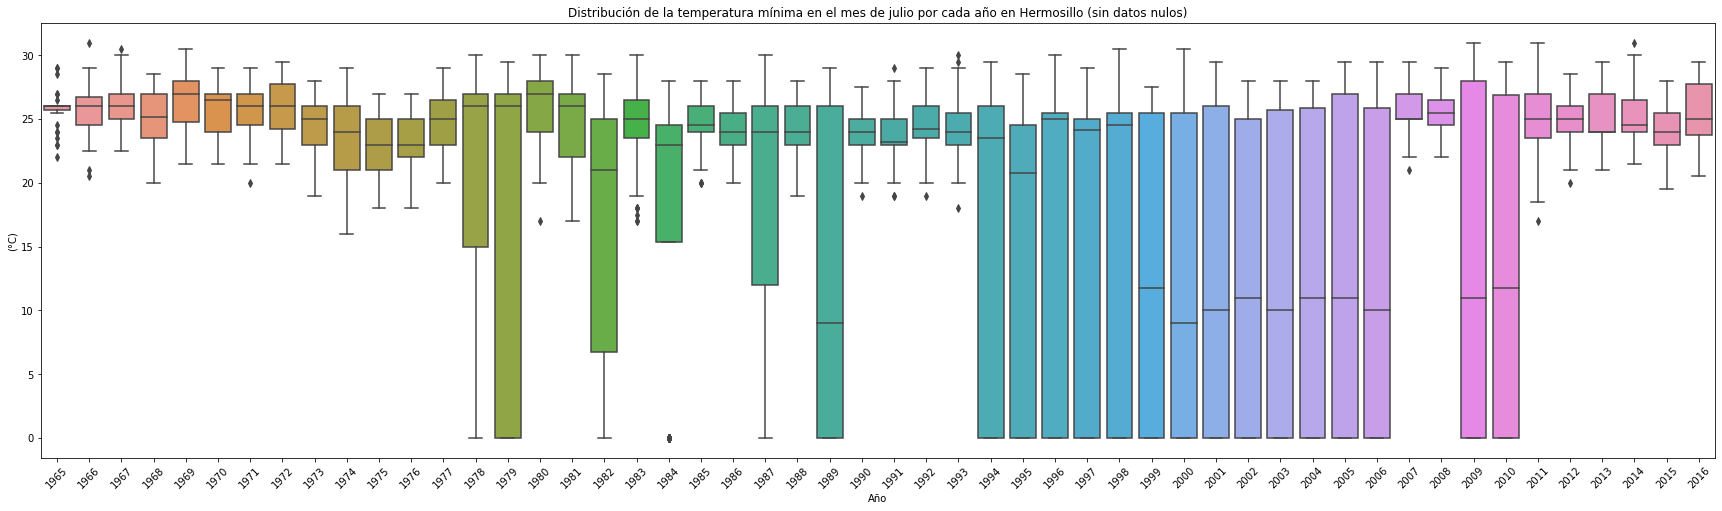

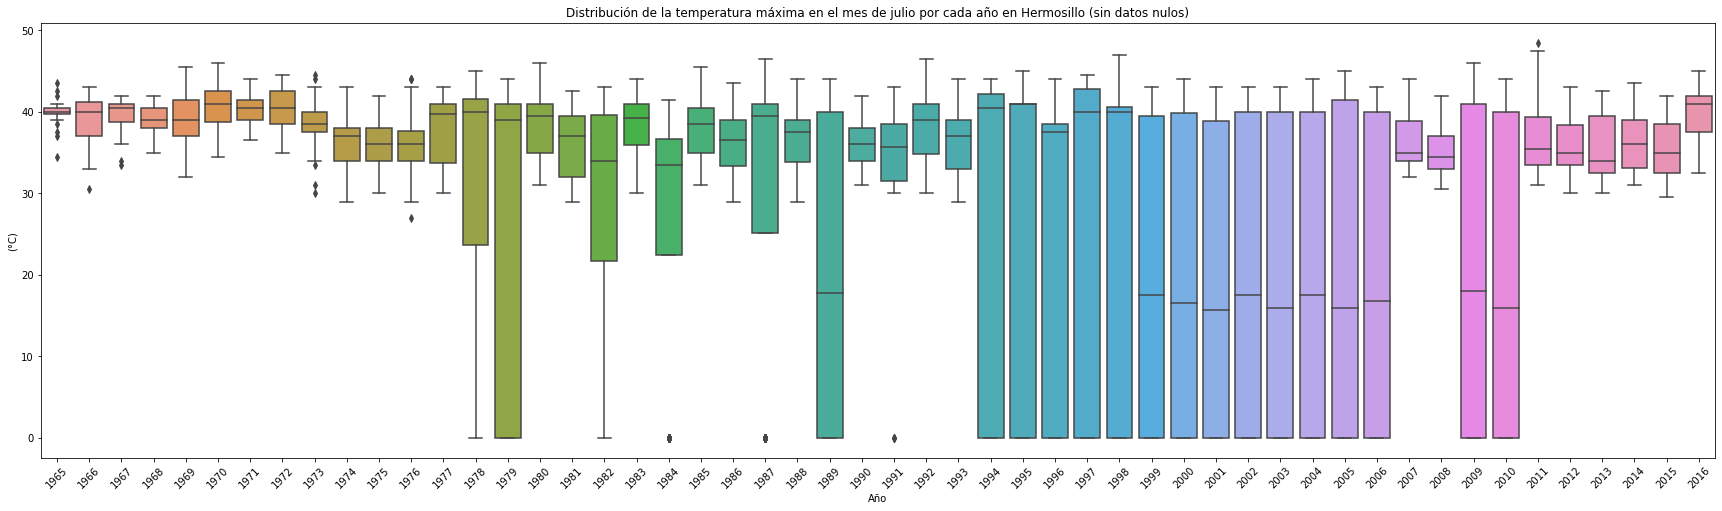

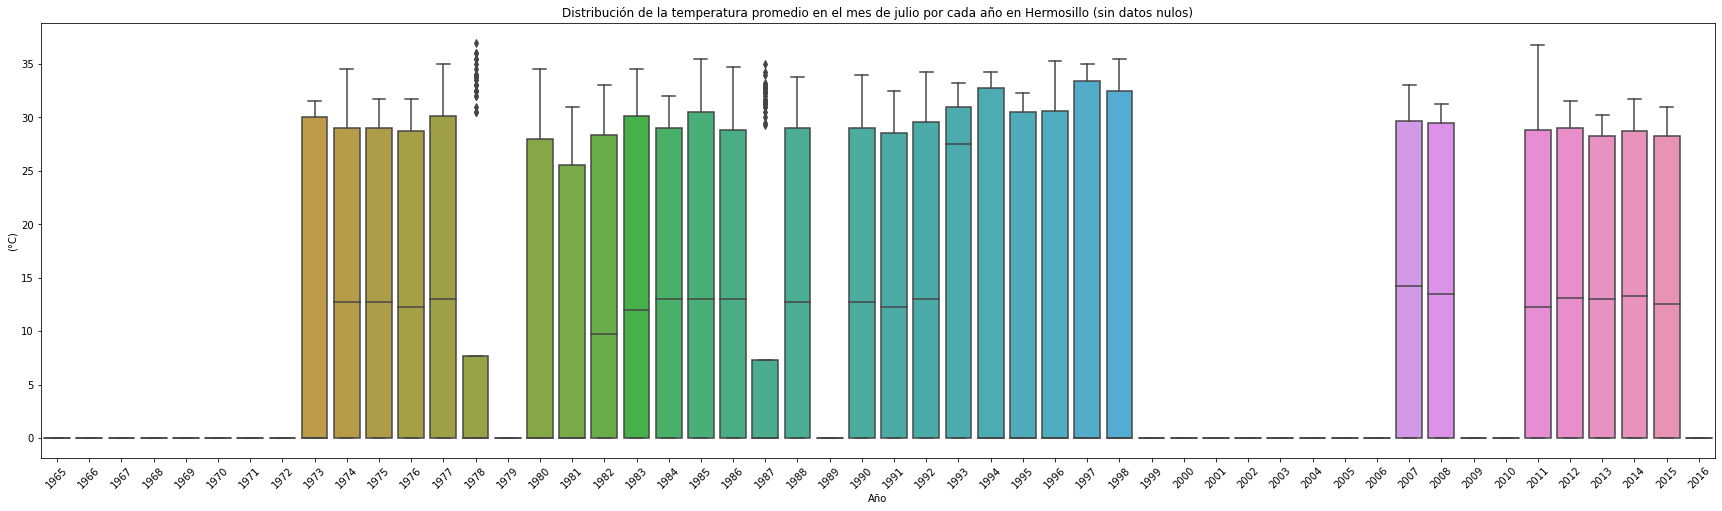

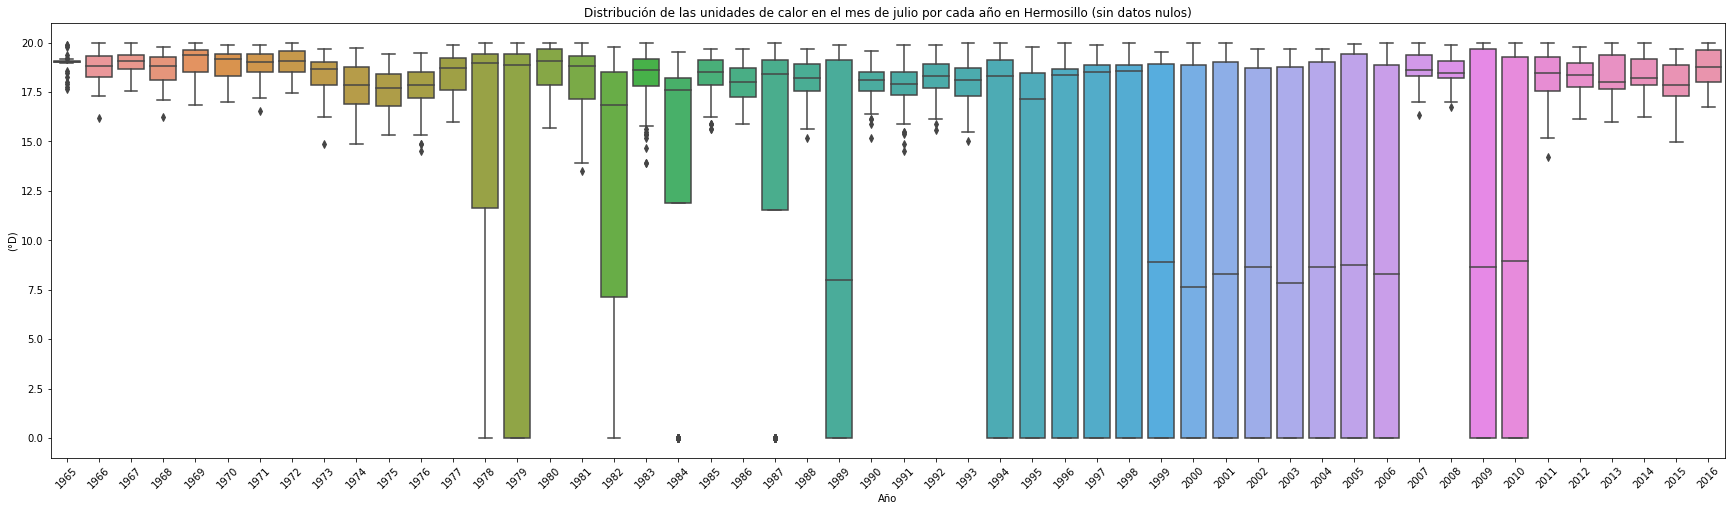

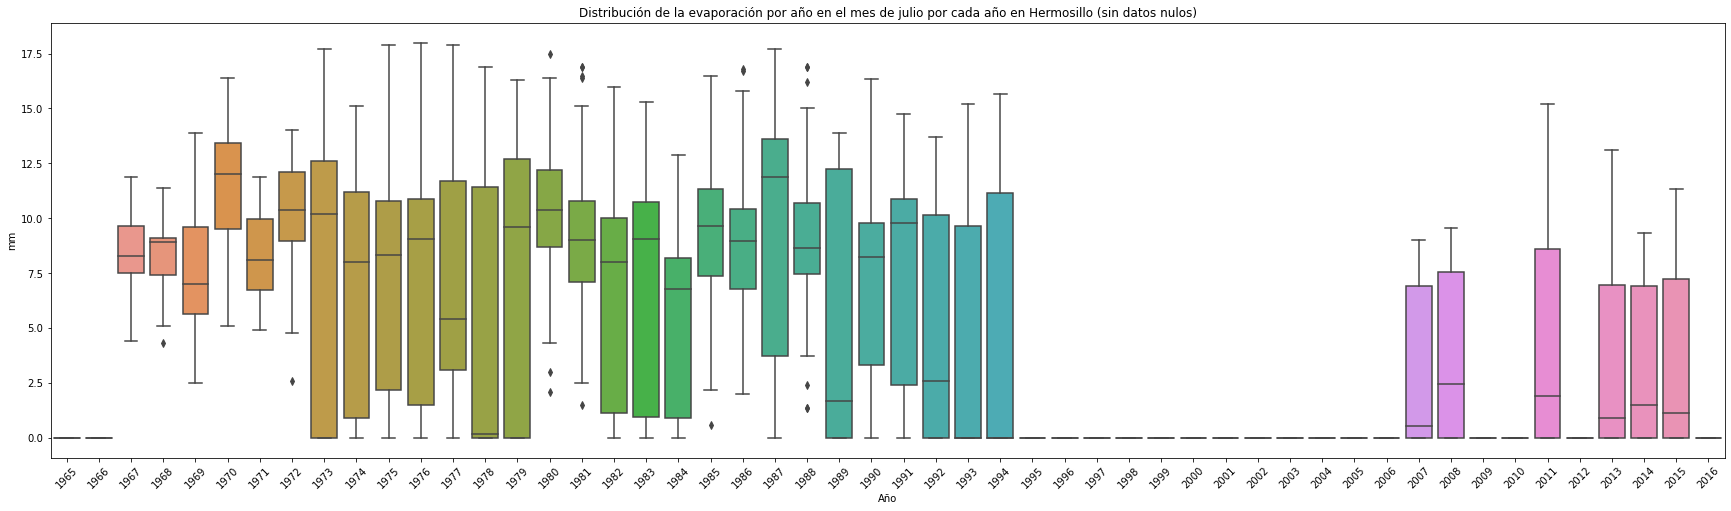

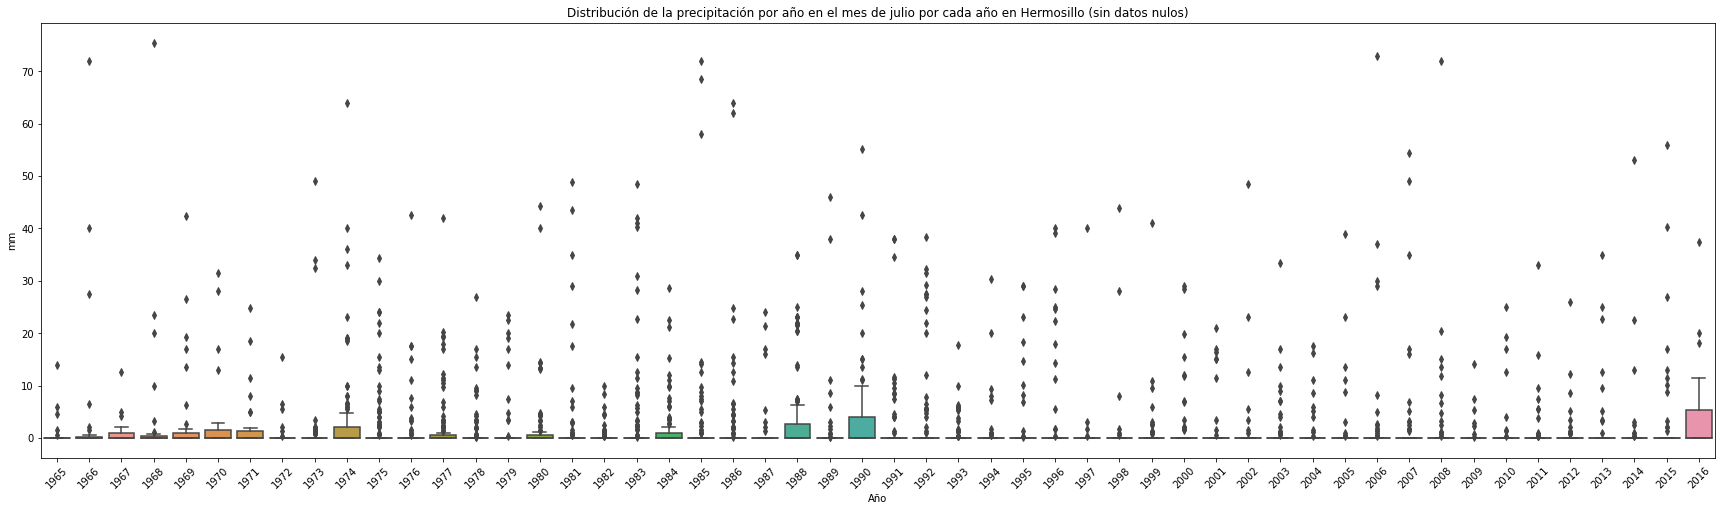

In [39]:
mes = 'julio'
for i in range(6):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Agosto

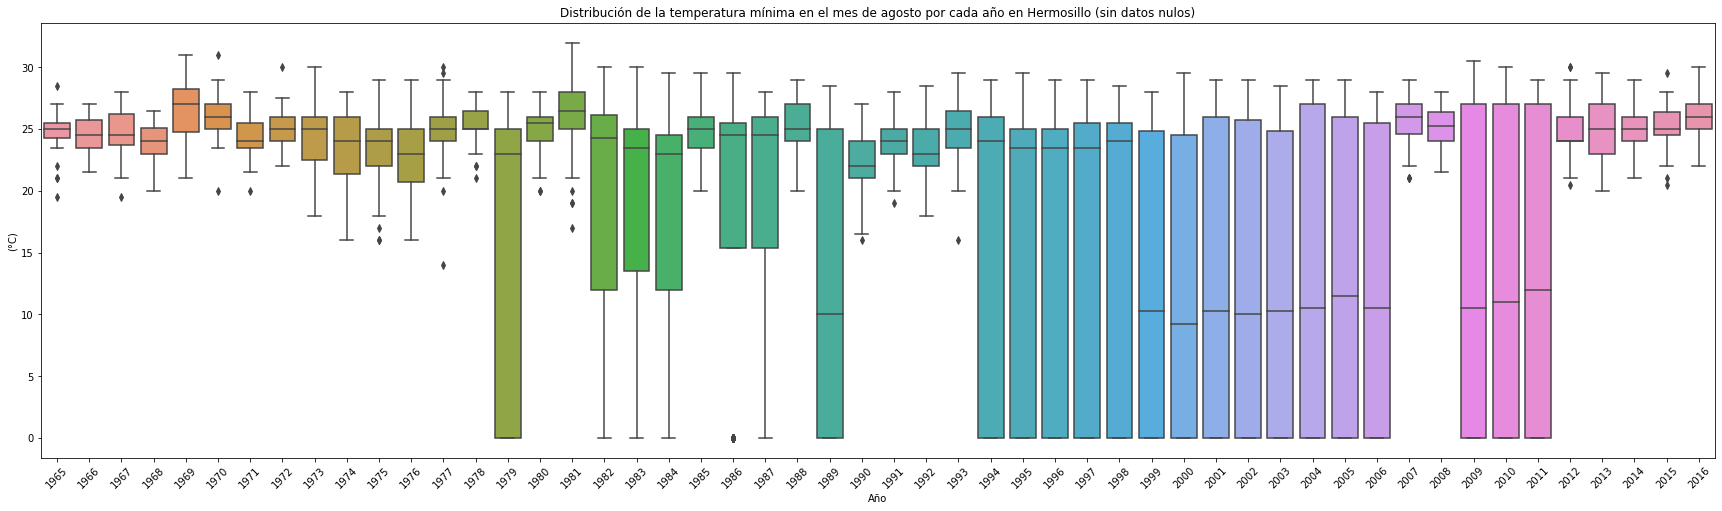

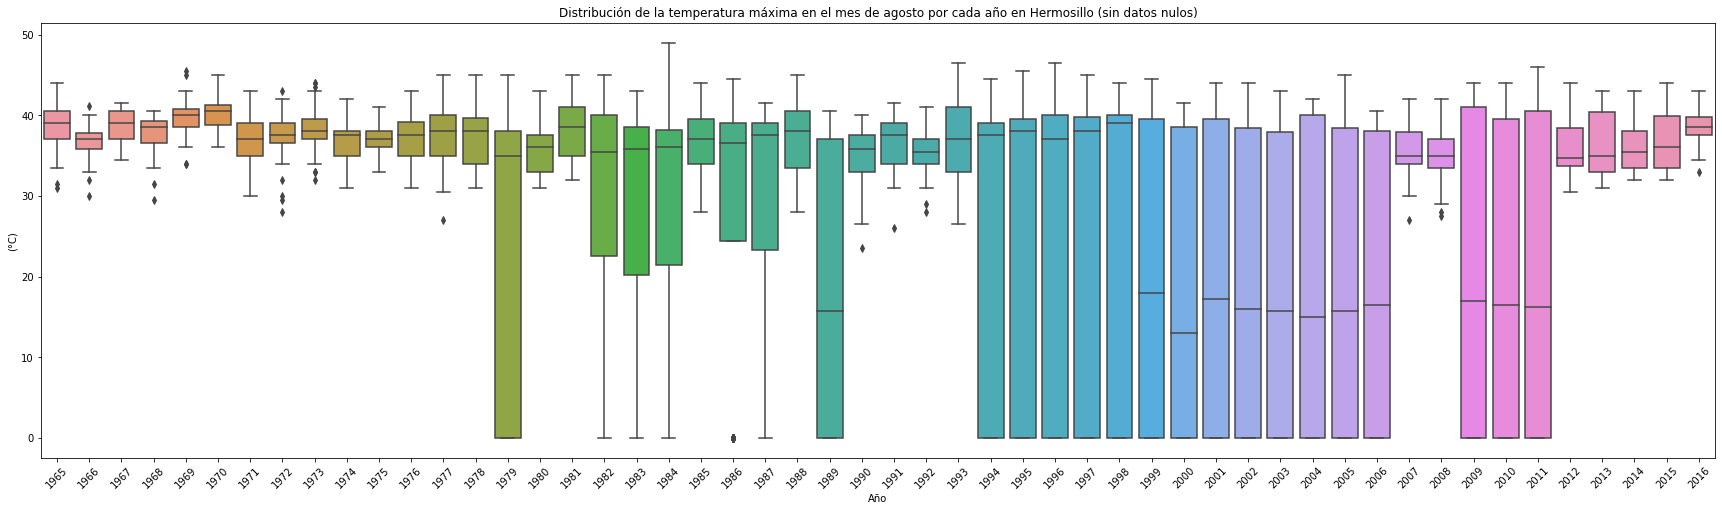

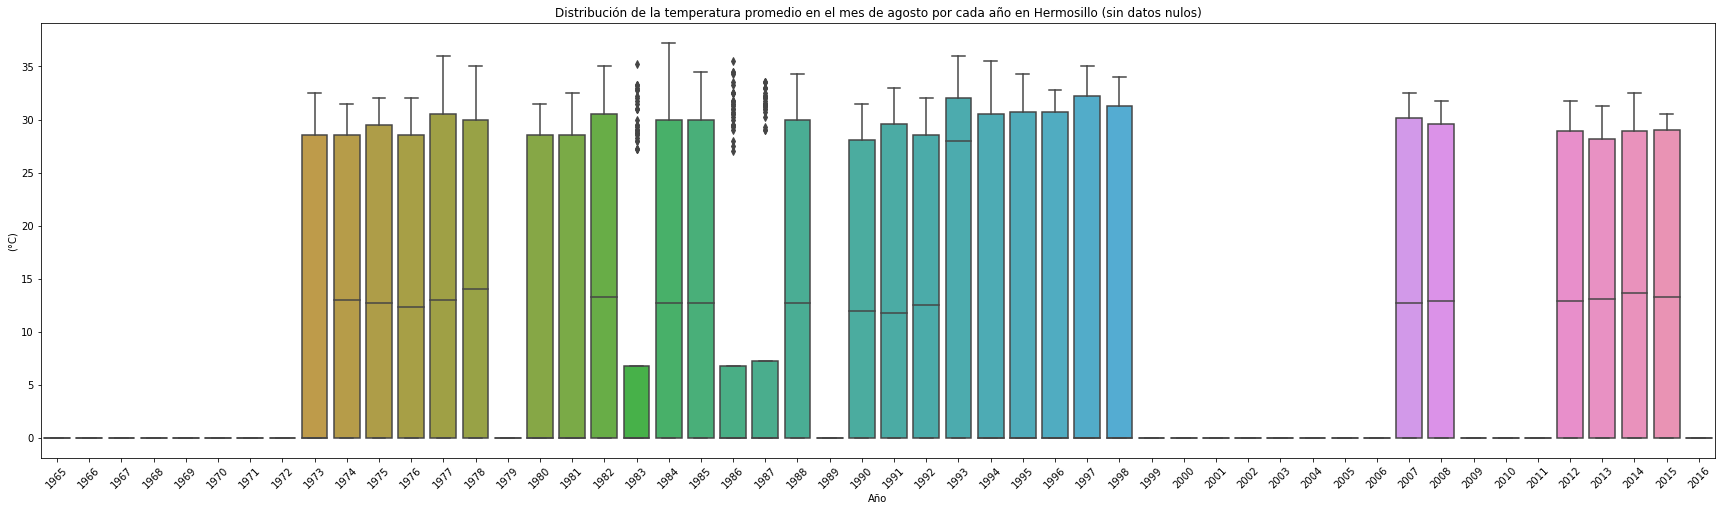

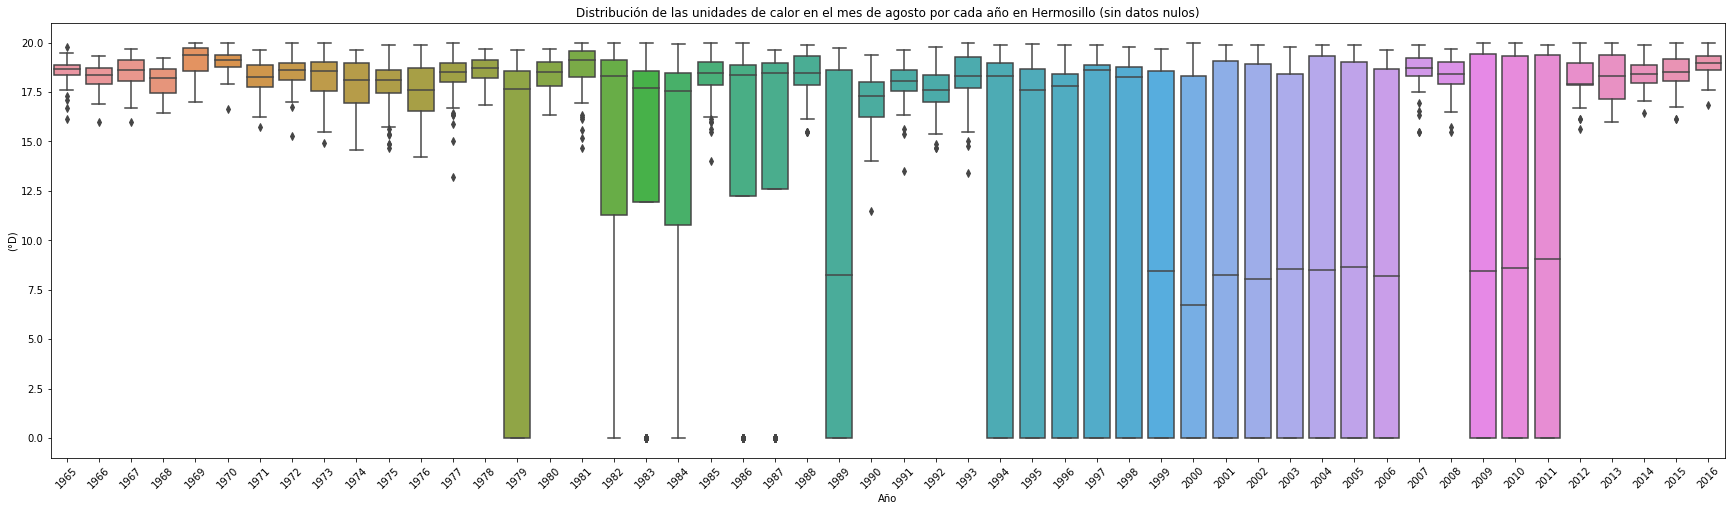

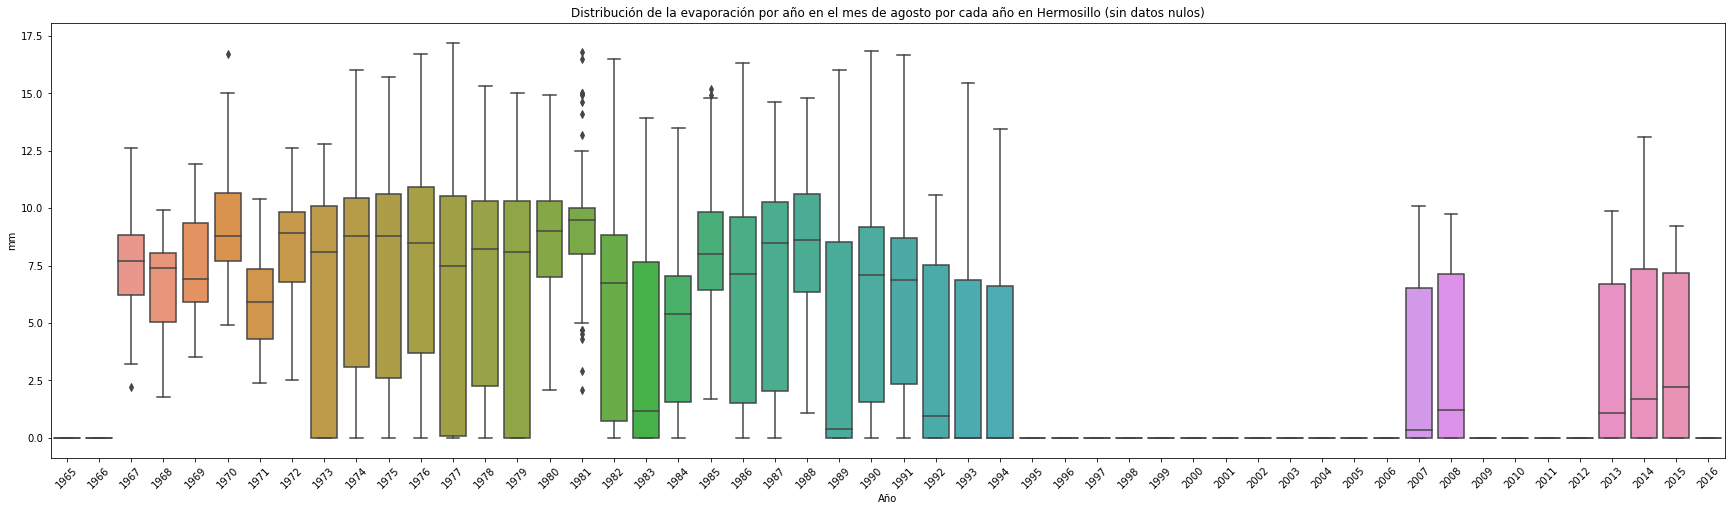

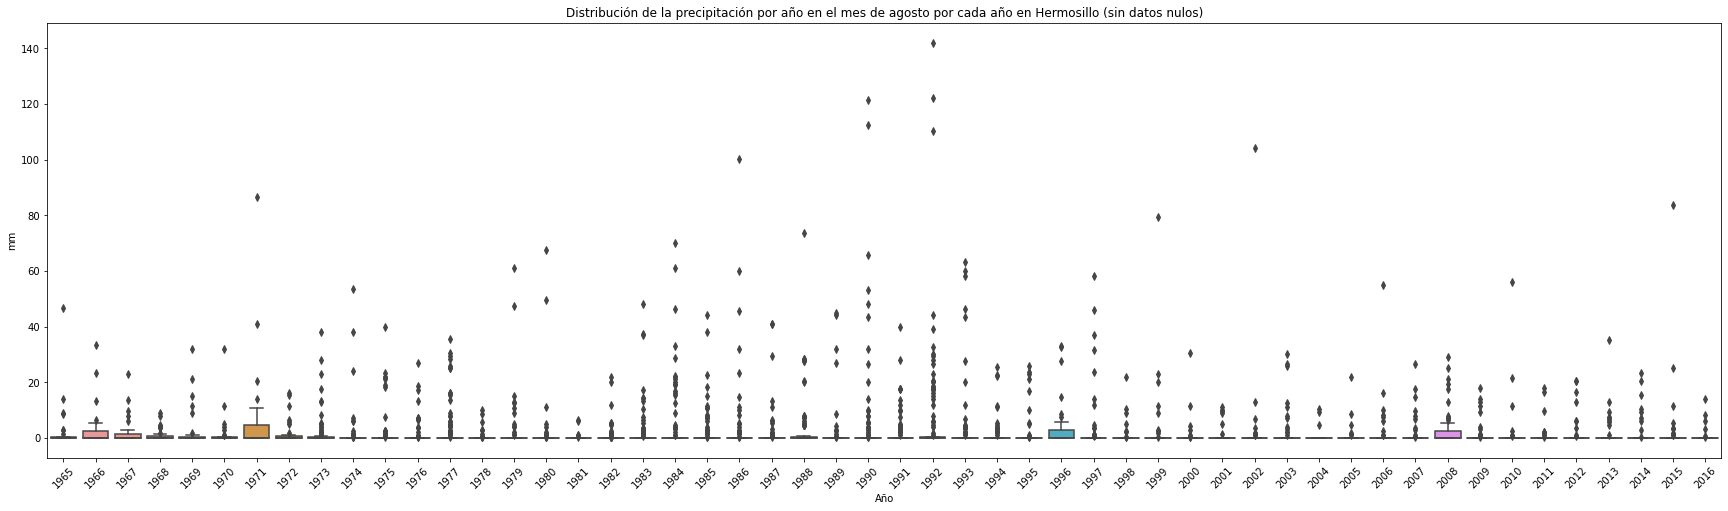

In [40]:
mes = 'agosto'
for i in range(6):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Septiembre

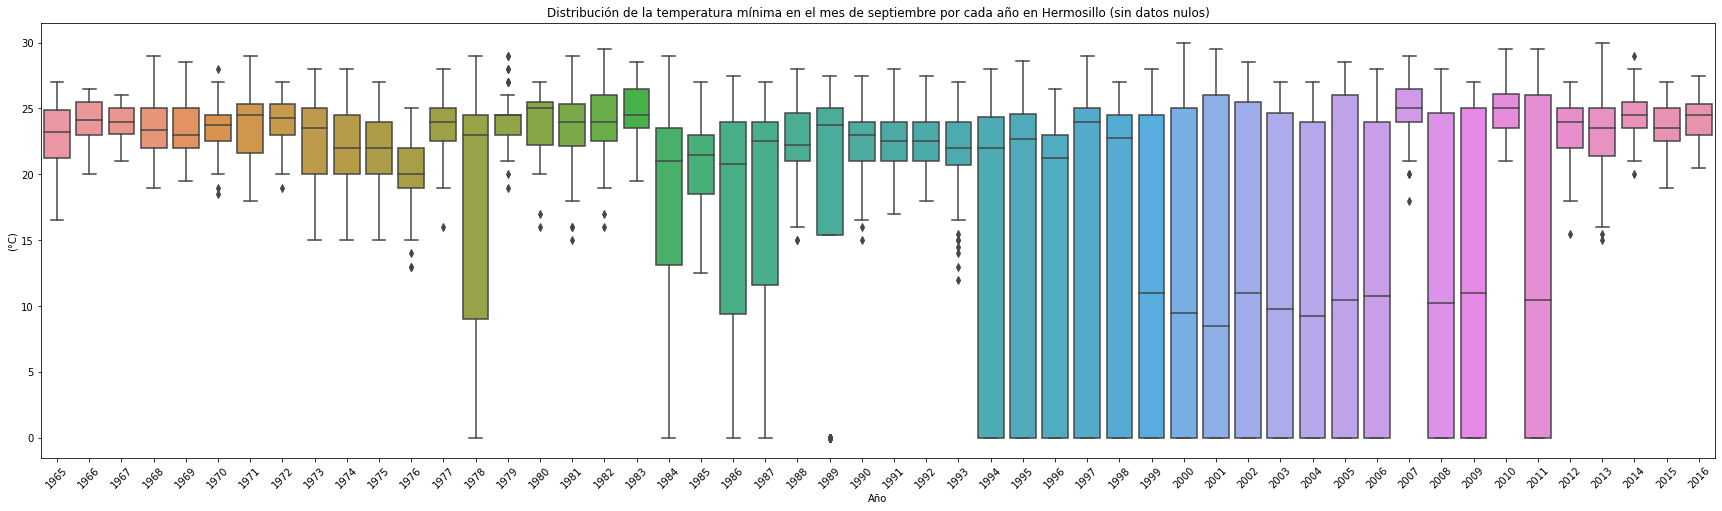

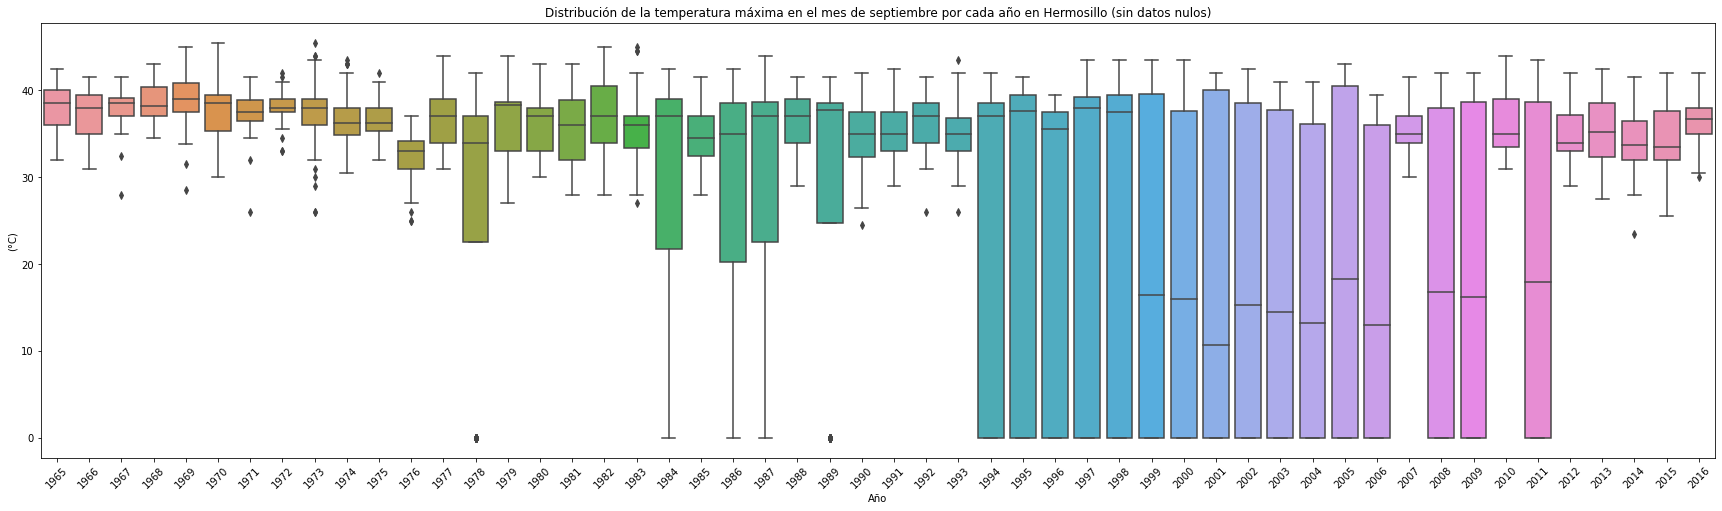

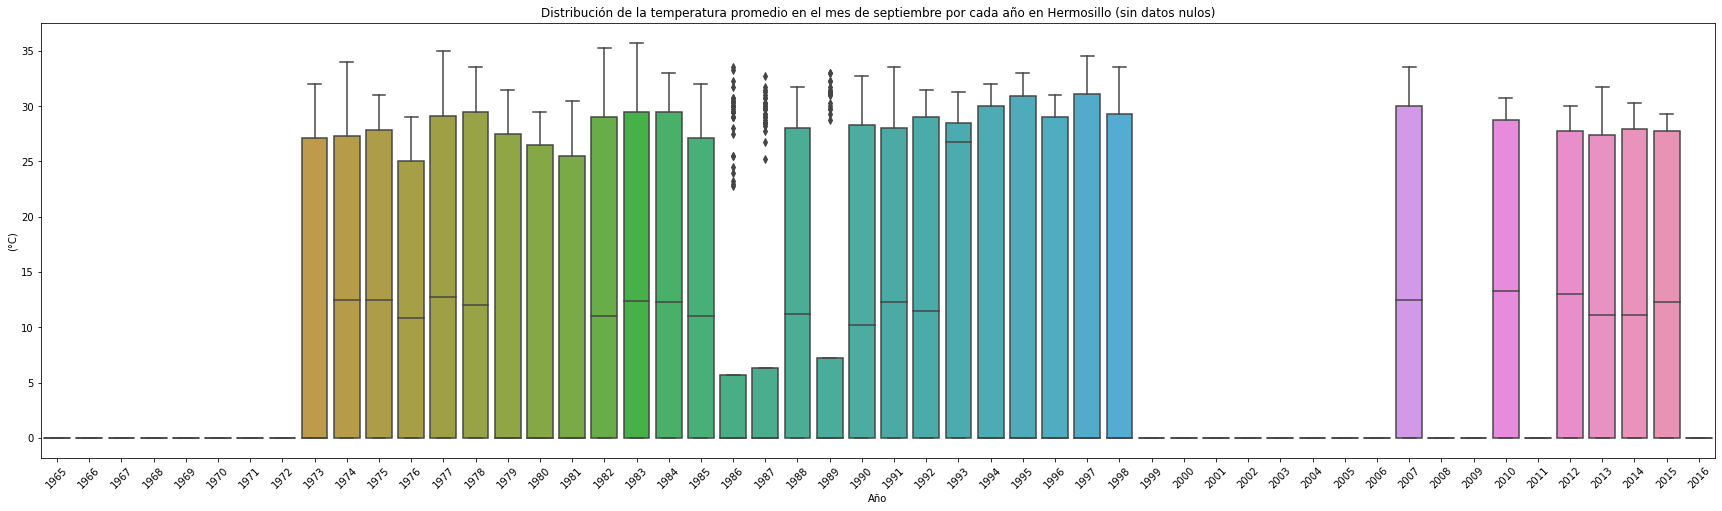

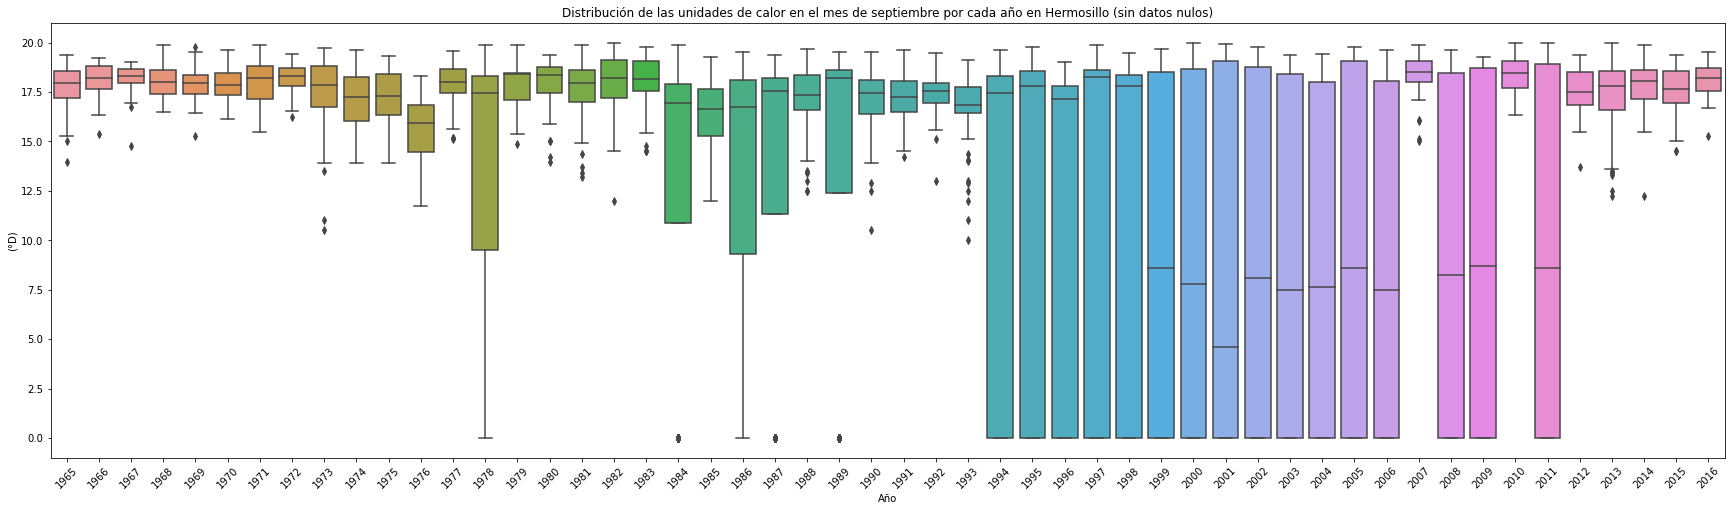

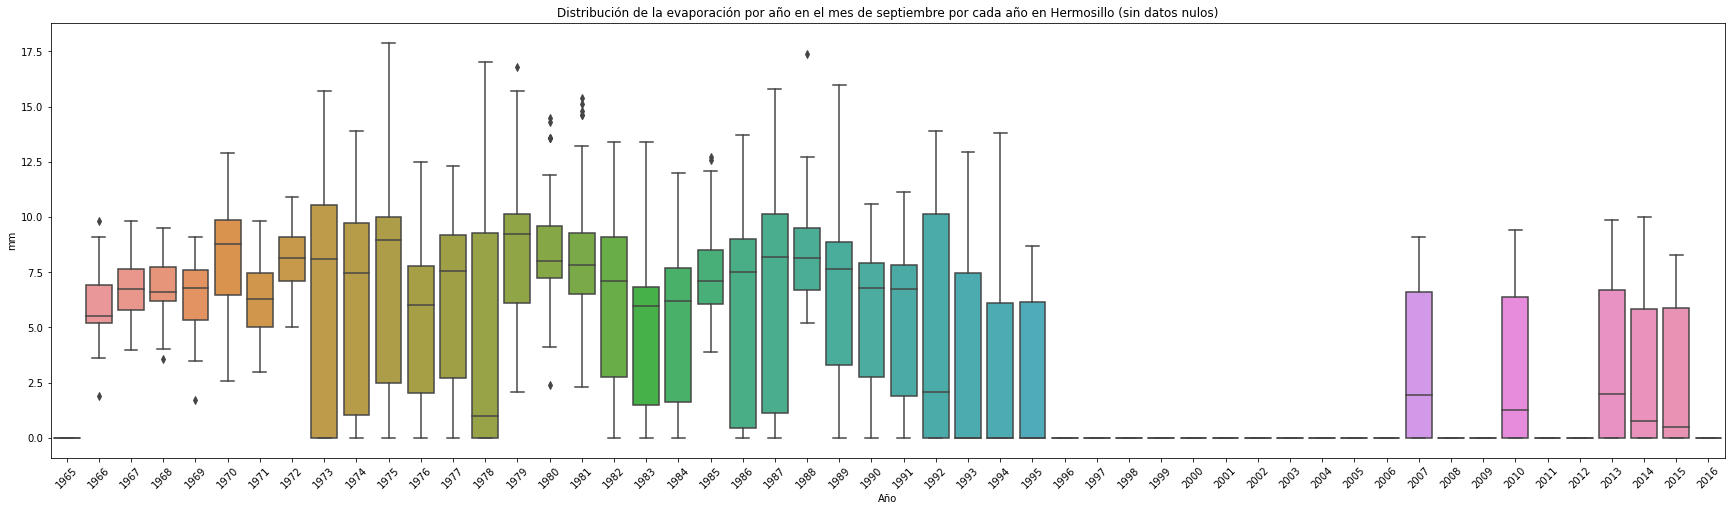

In [41]:
mes = 'septiembre'
for i in range(6):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Octubre

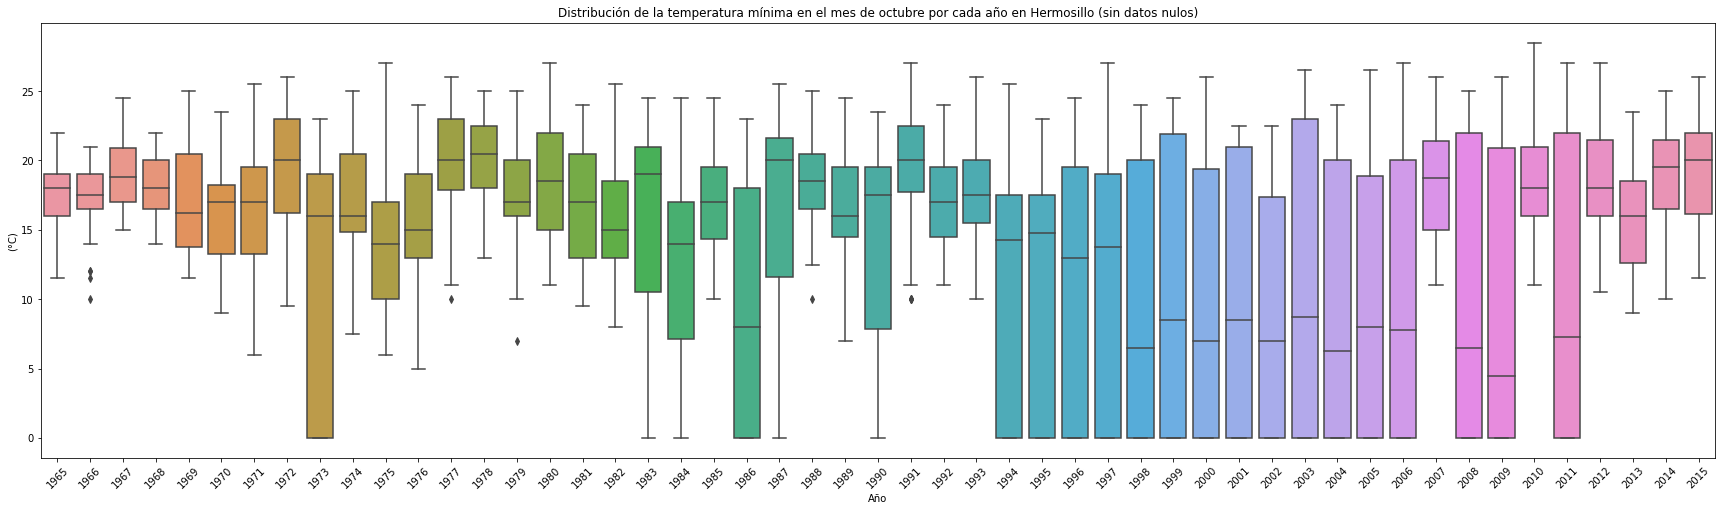

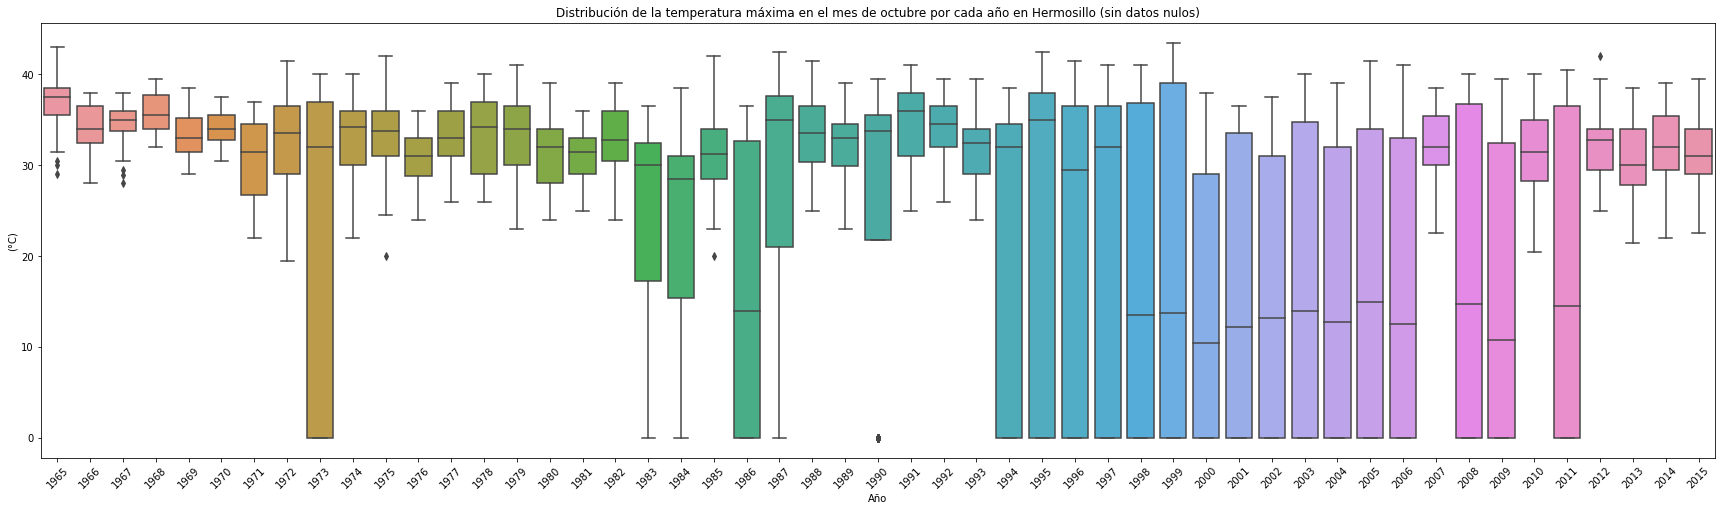

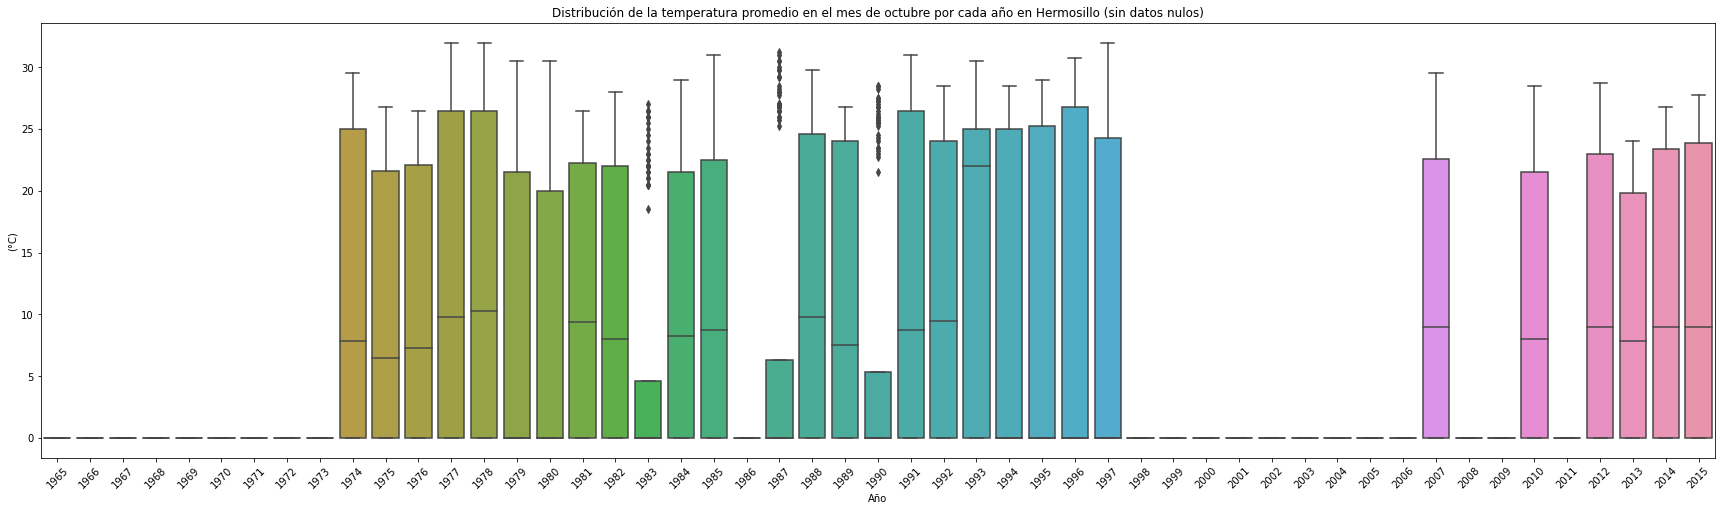

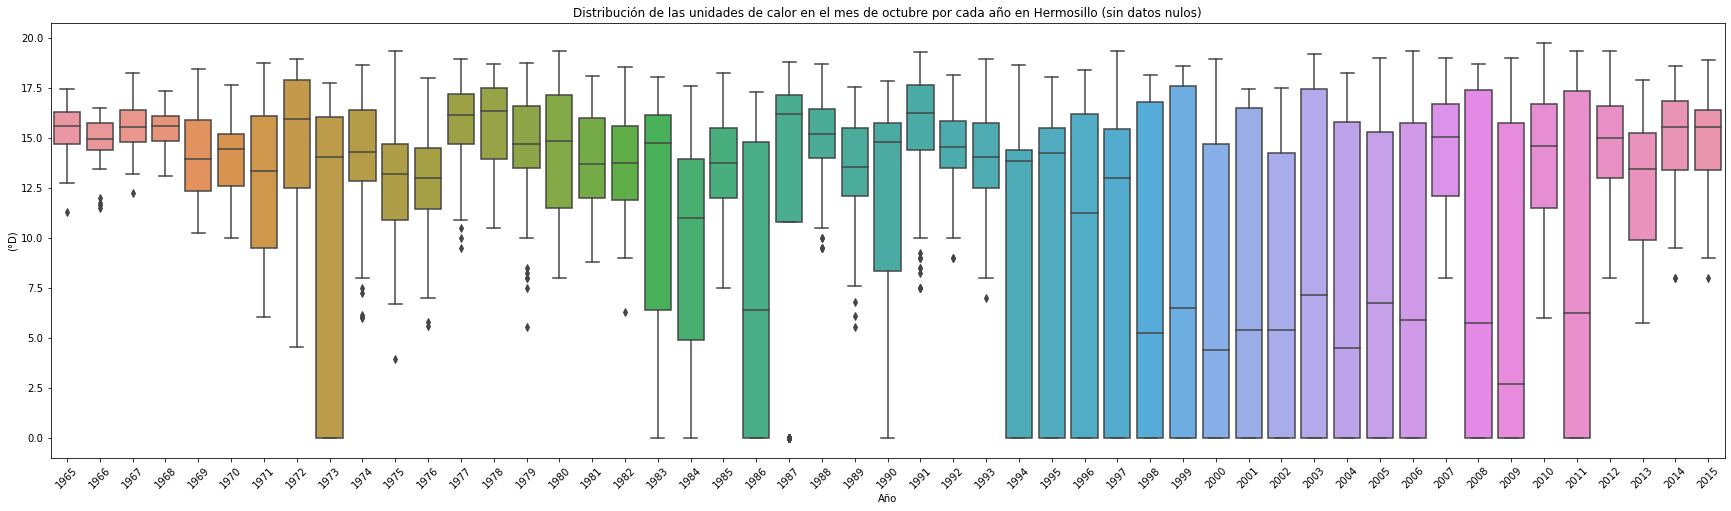

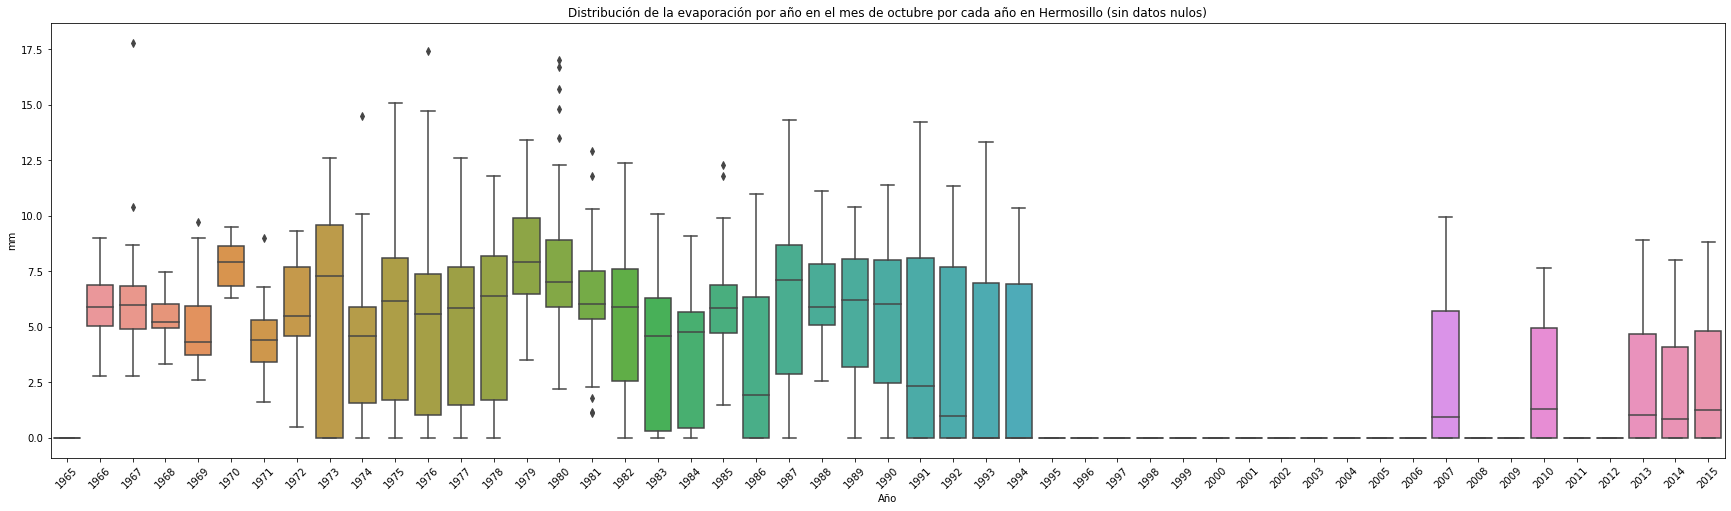

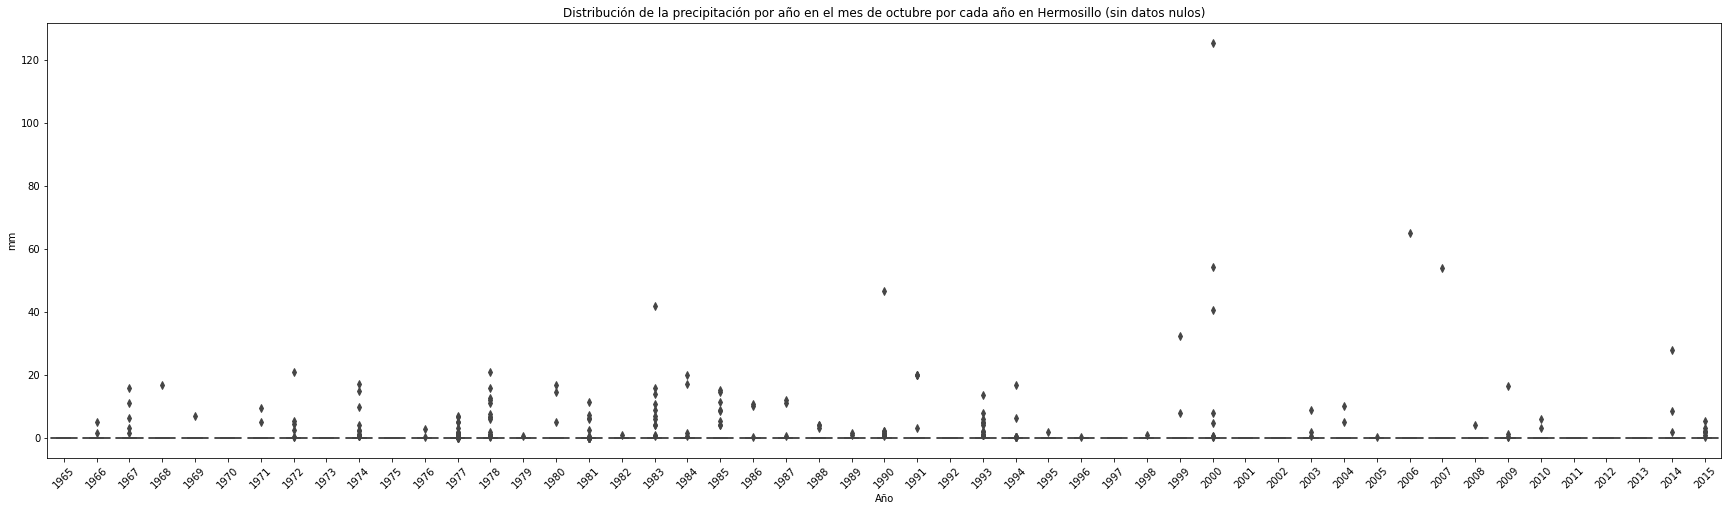

In [42]:
mes = 'octubre'
for i in range(6):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Noviembre

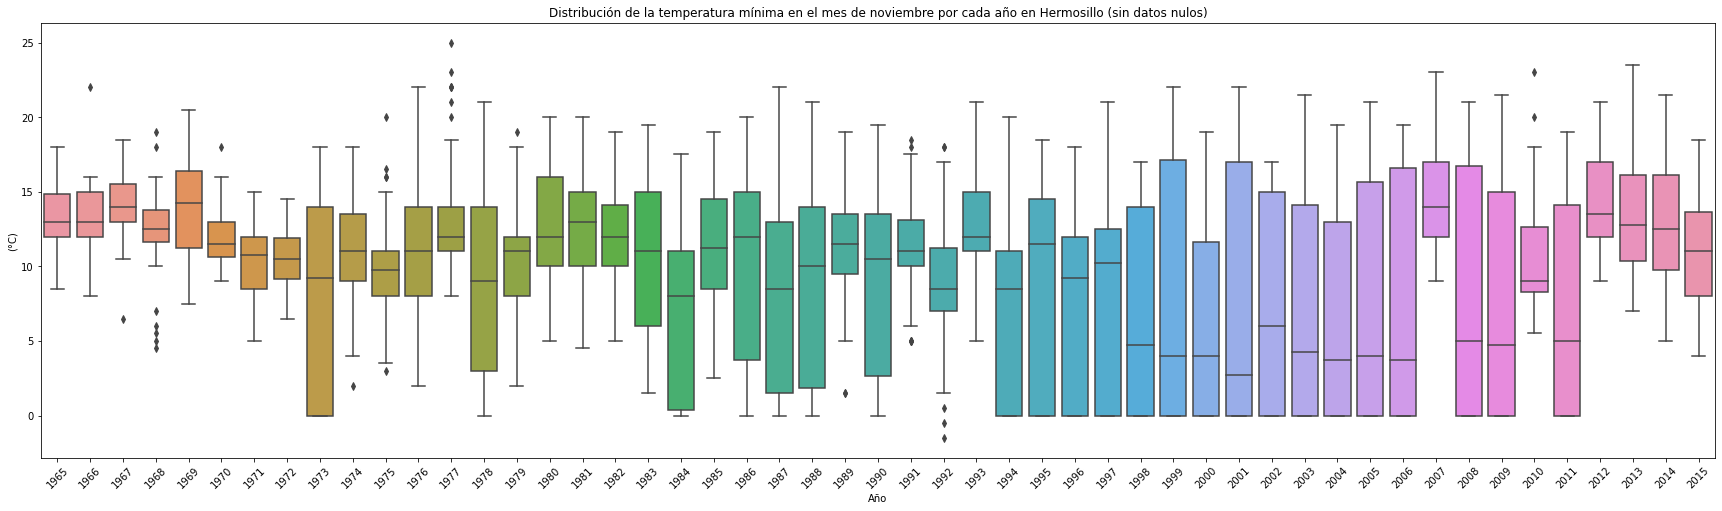

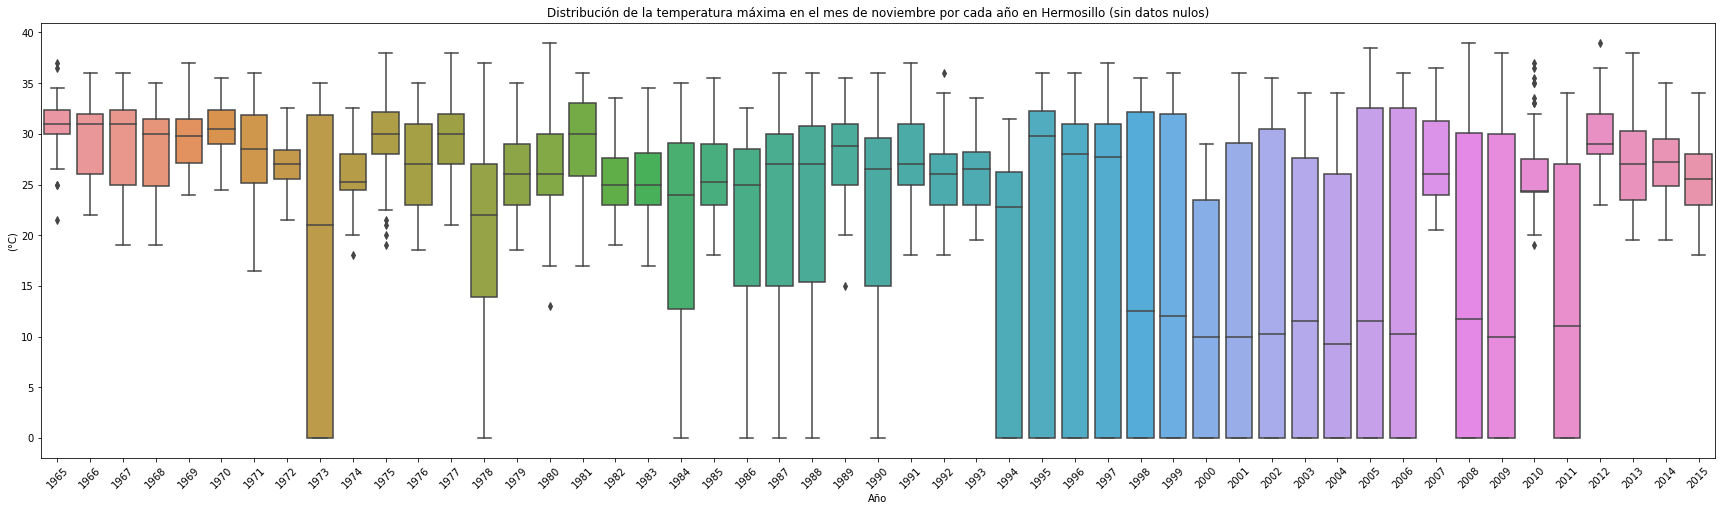

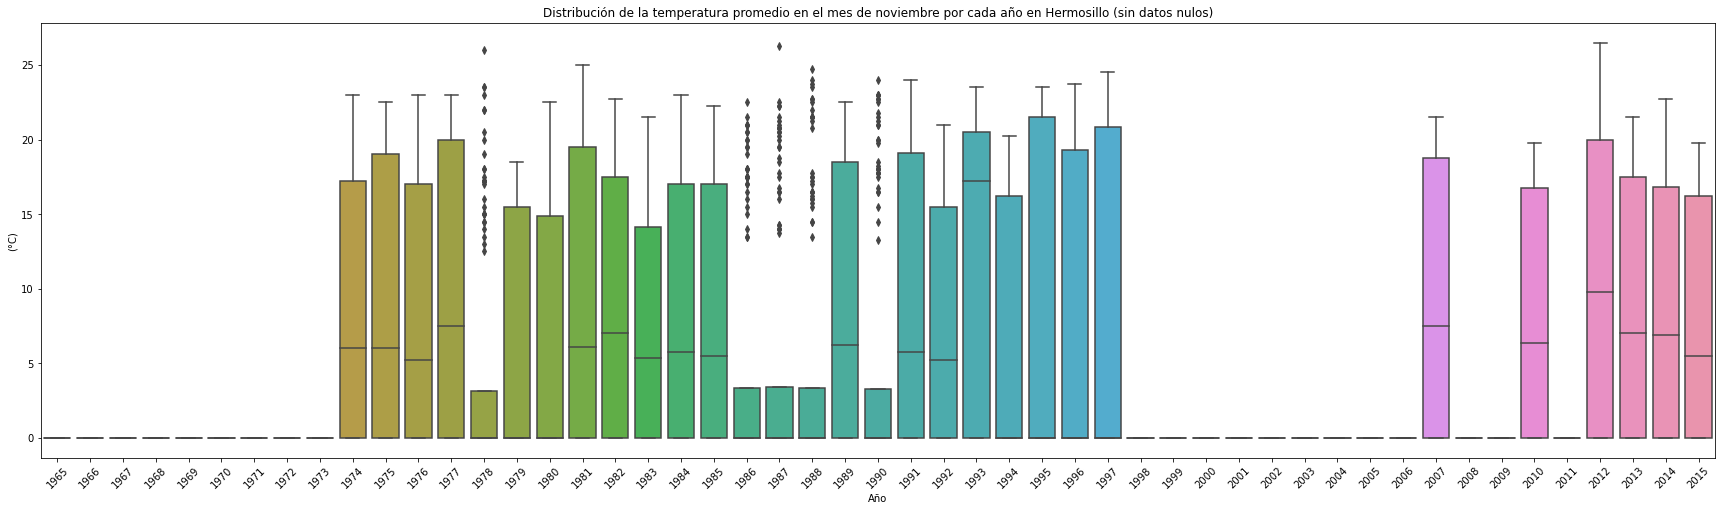

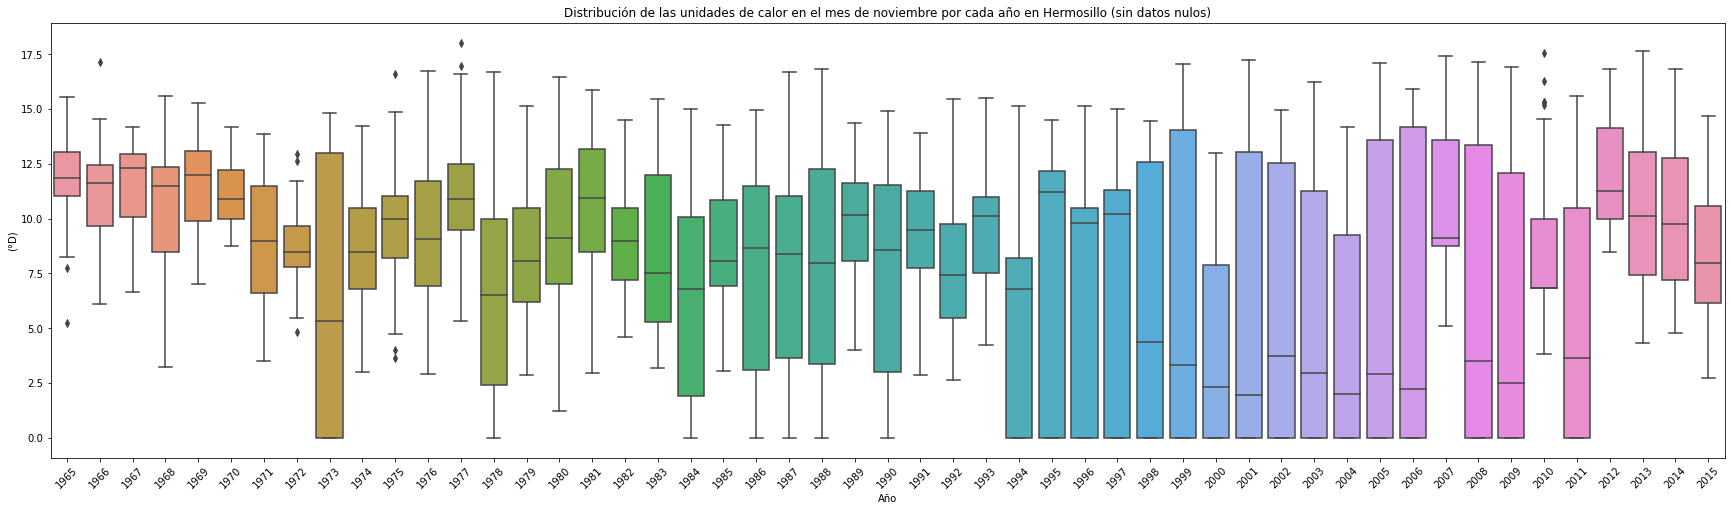

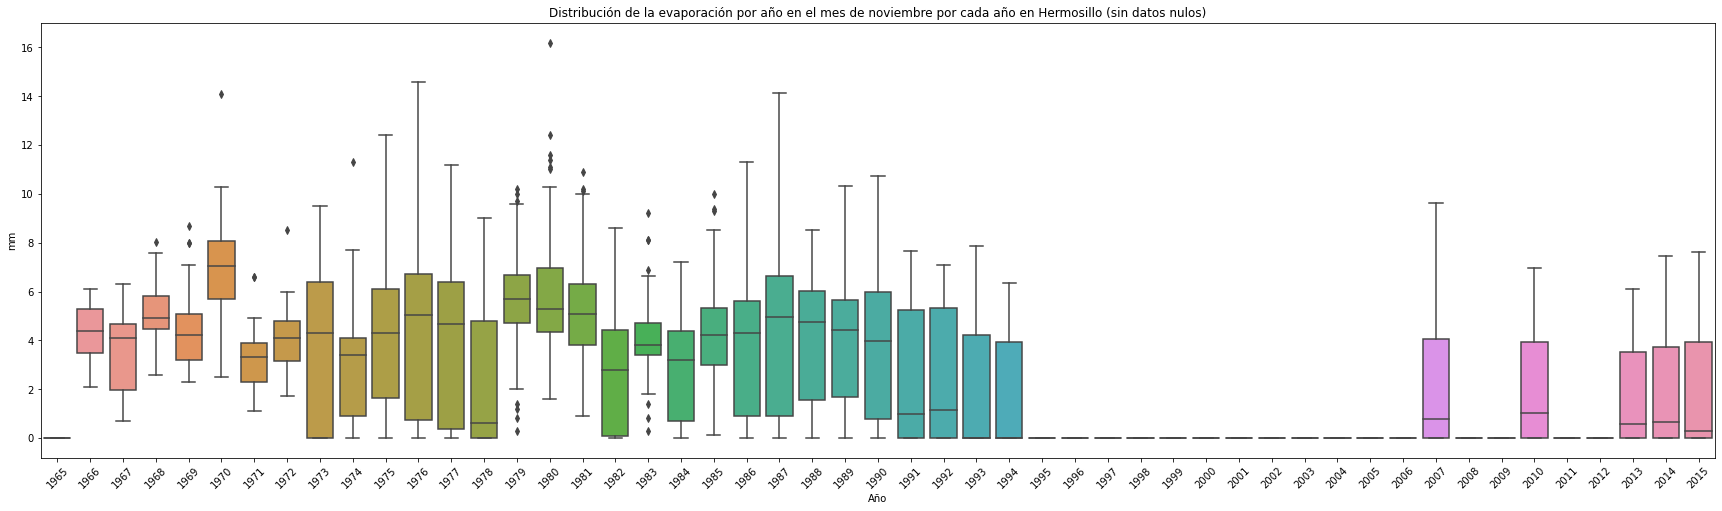

In [43]:
mes = 'noviembre'
for i in range(6):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Diciembre

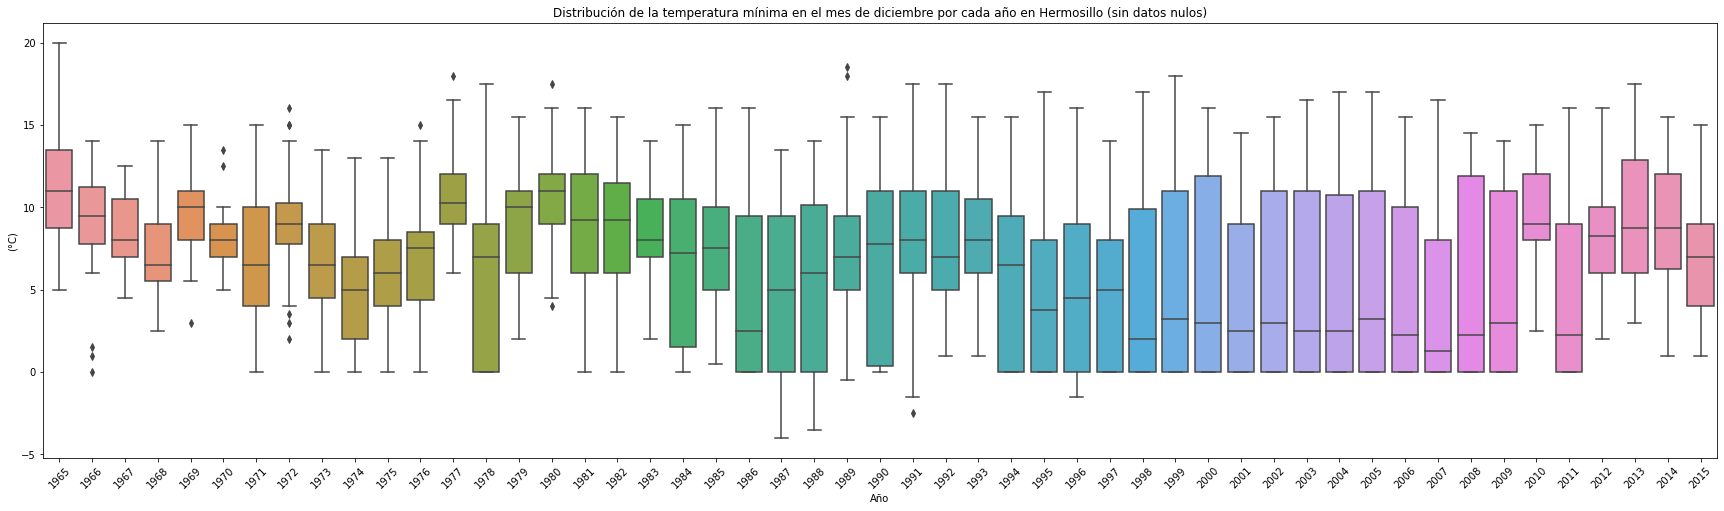

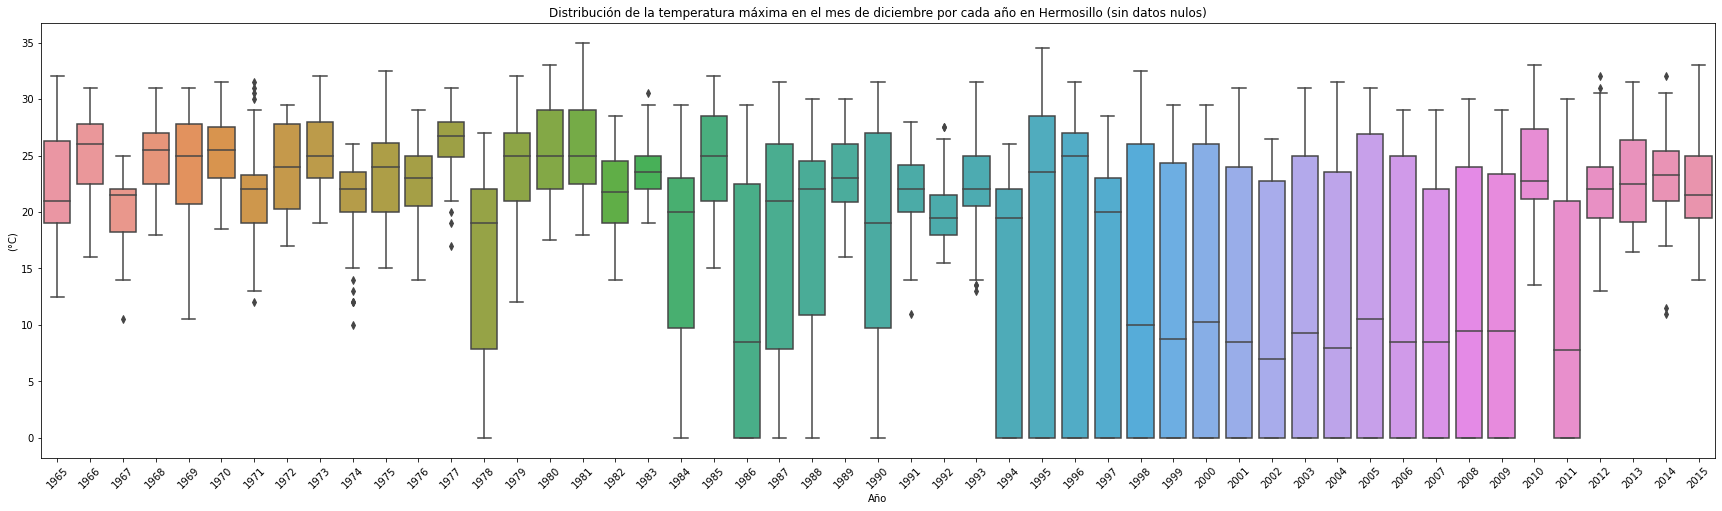

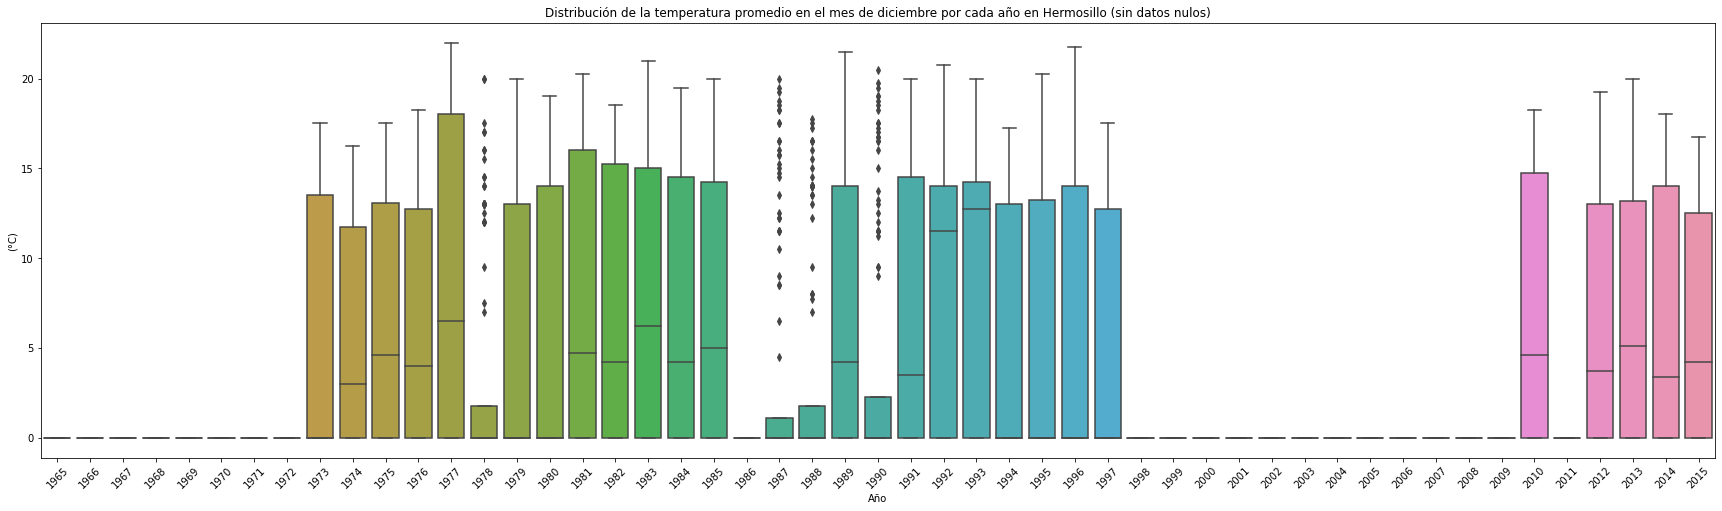

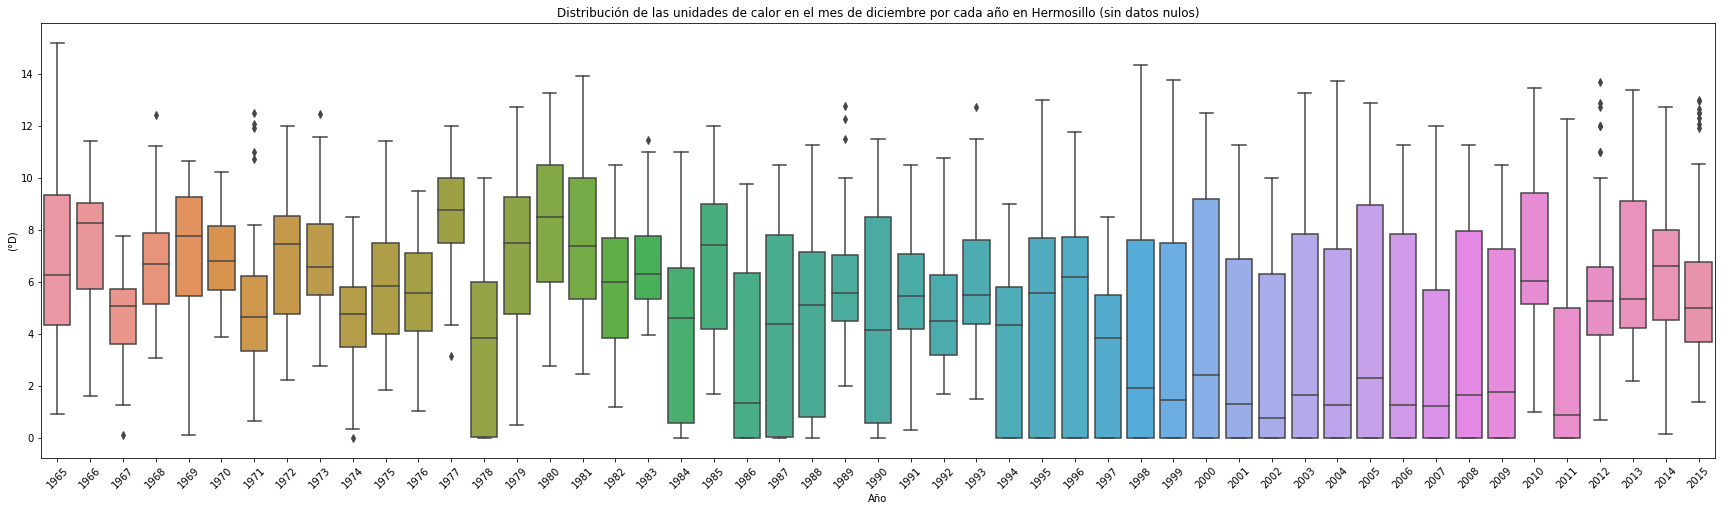

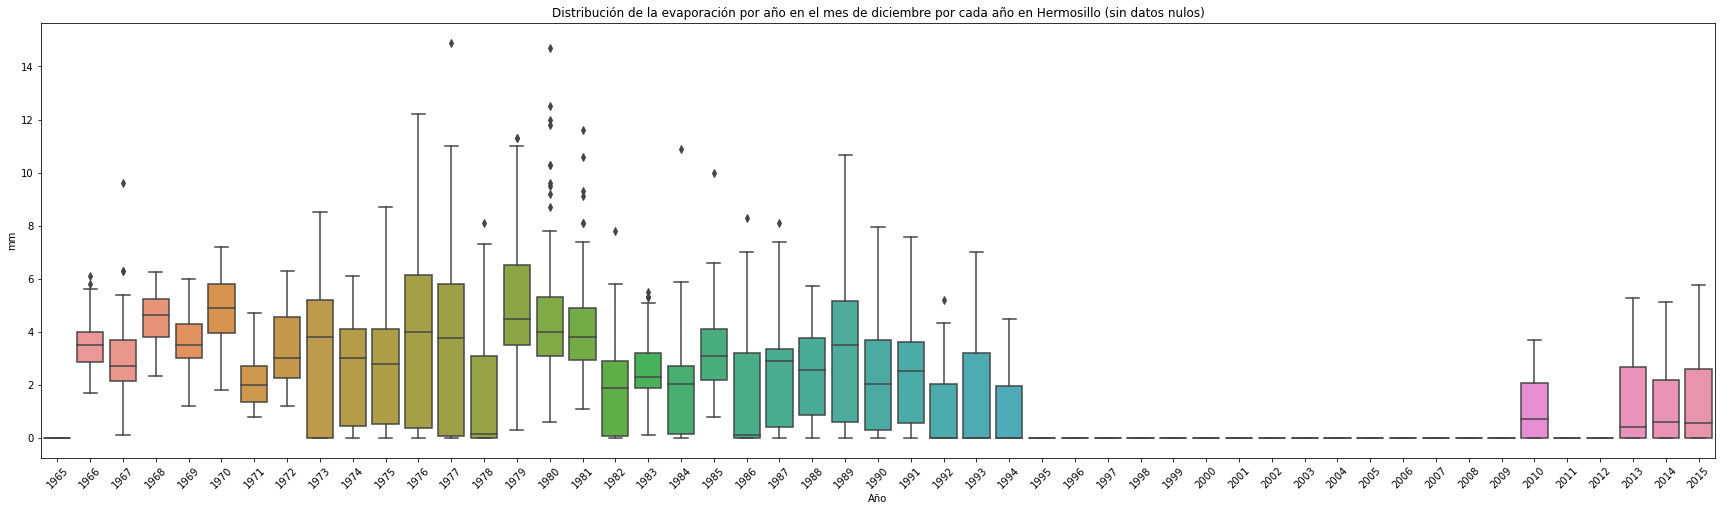

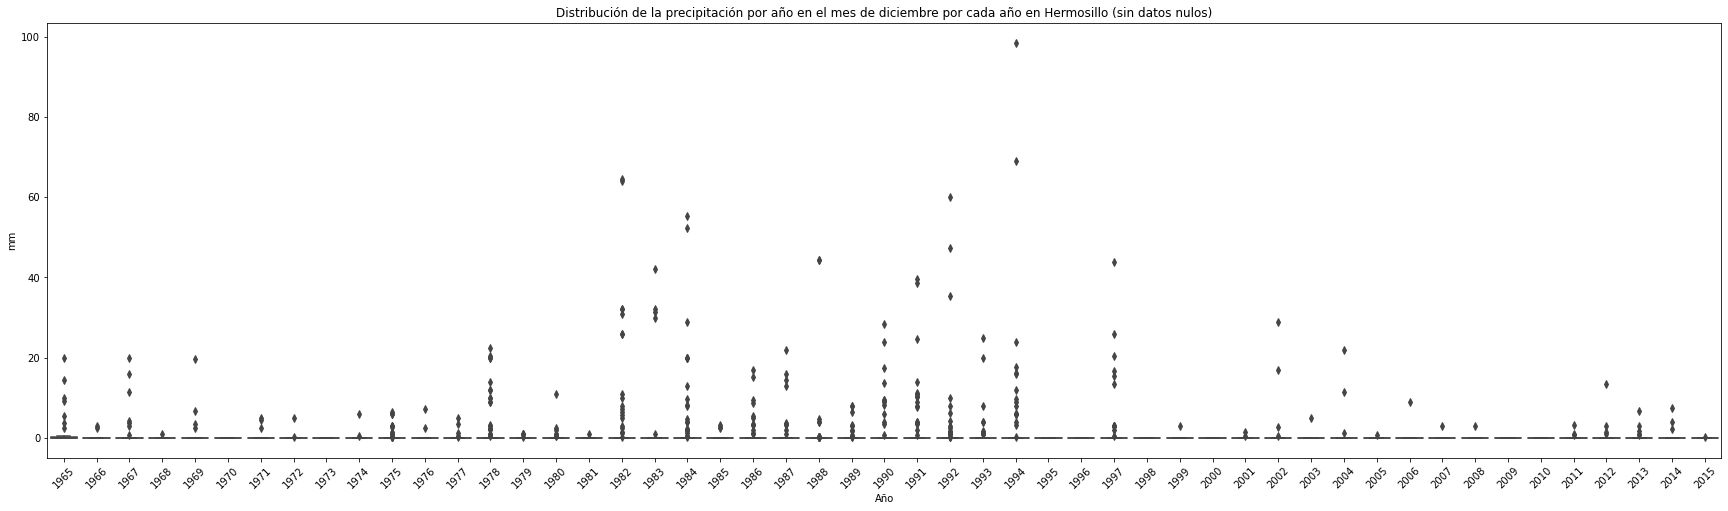

In [44]:
mes = 'diciembre'
for i in range(6):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

### Distribución de las variables en cada mes

In [45]:
def distribucionPorMesTotal(df, variable, titulo, etiqueta_x, etiqueta_y):
    plt.figure(figsize = (30,8))
    g = sns.boxplot(x=df.Fecha.dt.month, y=variable, data=df)
    _ = g.set(title=titulo, xlabel=etiqueta_x, ylabel=etiqueta_y)
    g.set_xticklabels(['enero','febrero','marzo','abril','mayo','junio','julio',
                           'agosto','septiembre','octubre','noviembre','diciembre'])

titulos = ['Distribución de la temperatura mínima',
           'Distribución de la temperatura máxima',
           'Distribución de la temperatura promedio',
           'Distribución de las unidades de calor',
           'Distribución de la evaporación',
           'Distribución de la precipitación'
       ]
ylabels = ['(°C)','(°C)','(°C)','(°D)', 'mm', 'mm']
variables = df.columns[4:10]

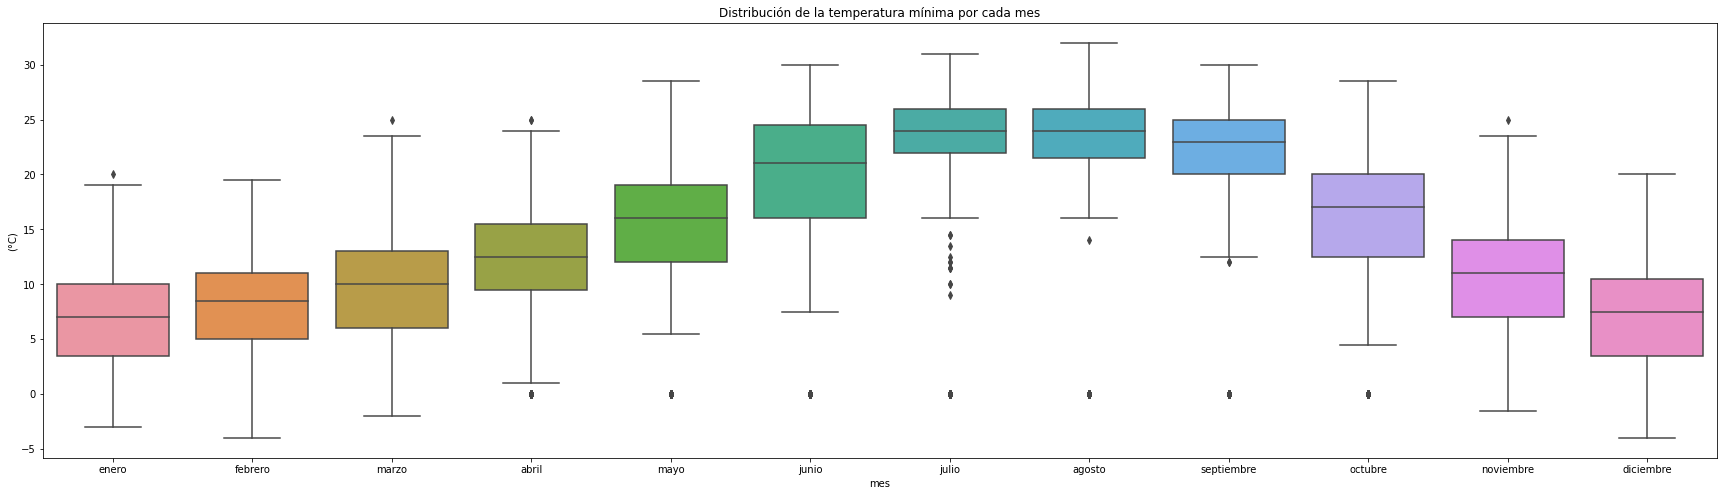

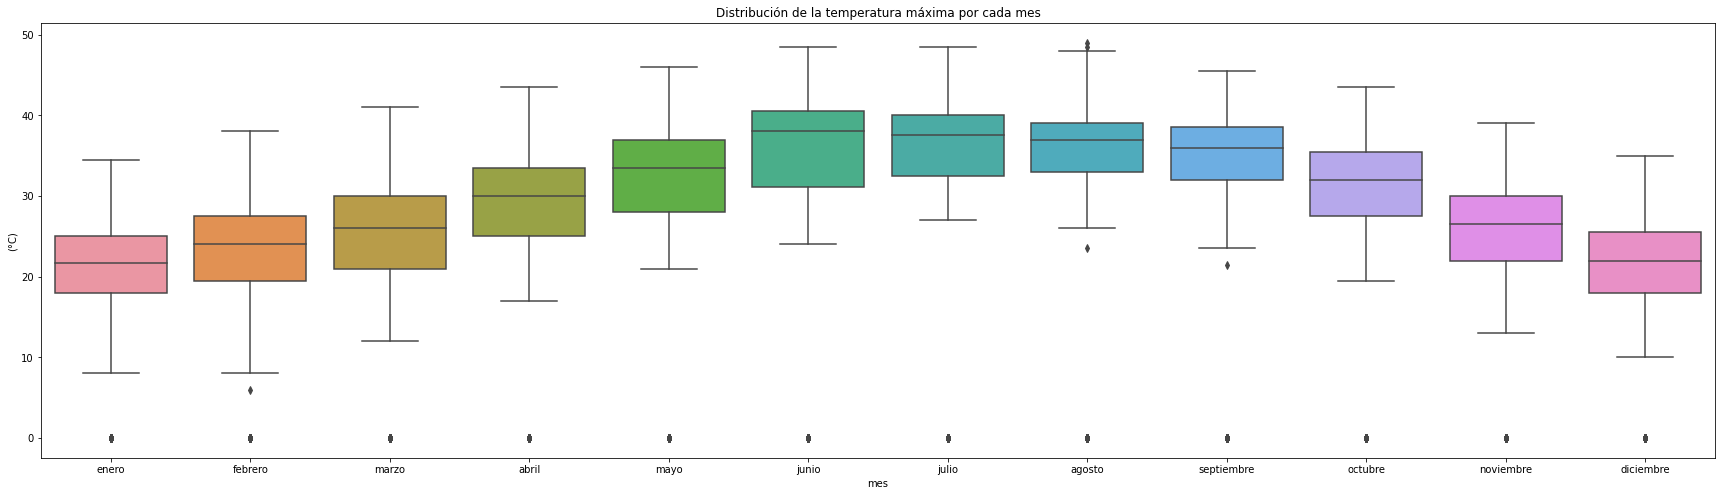

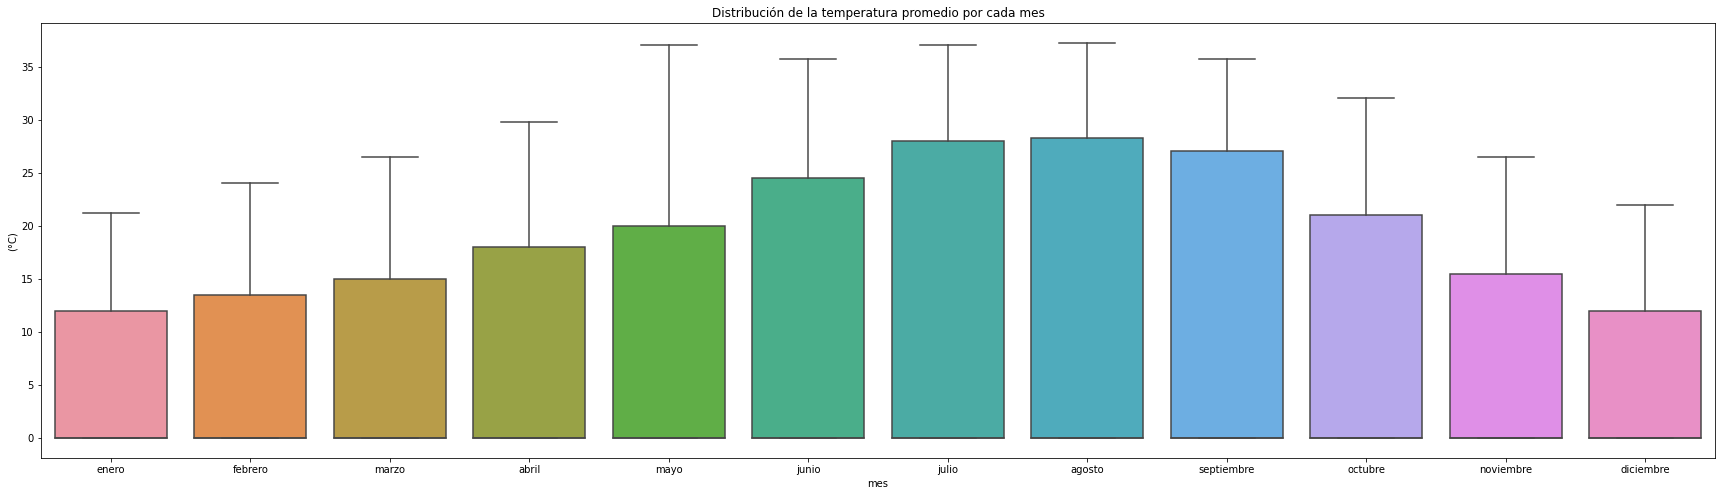

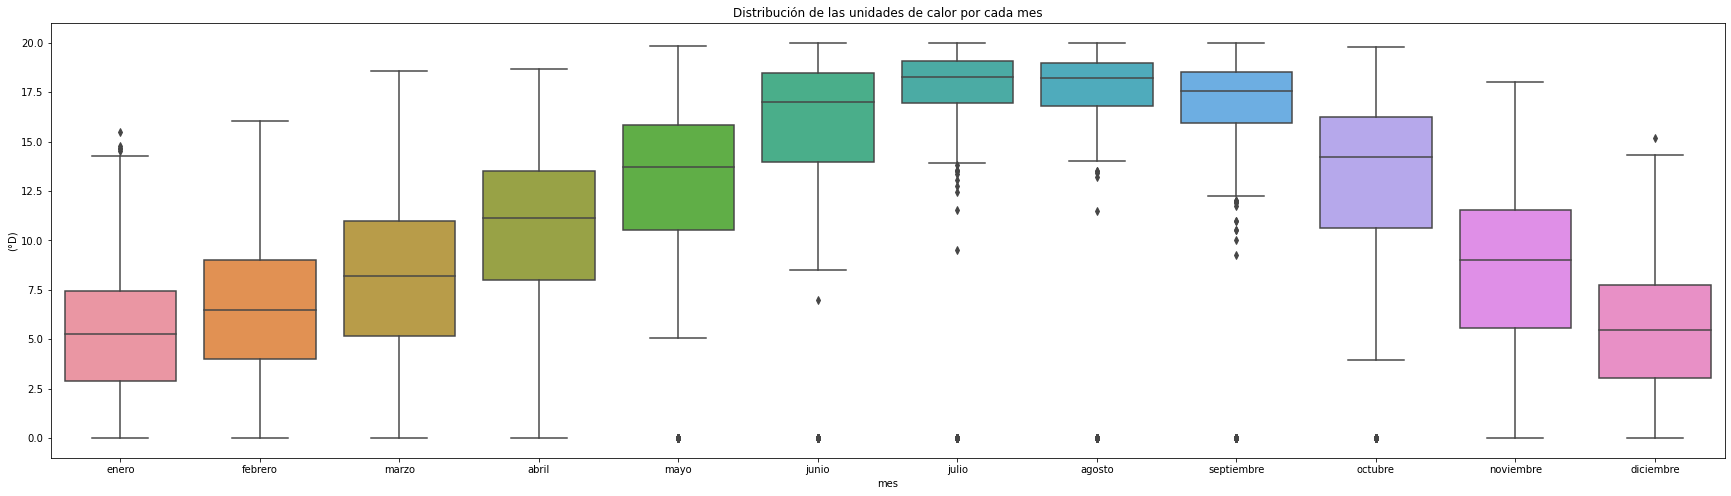

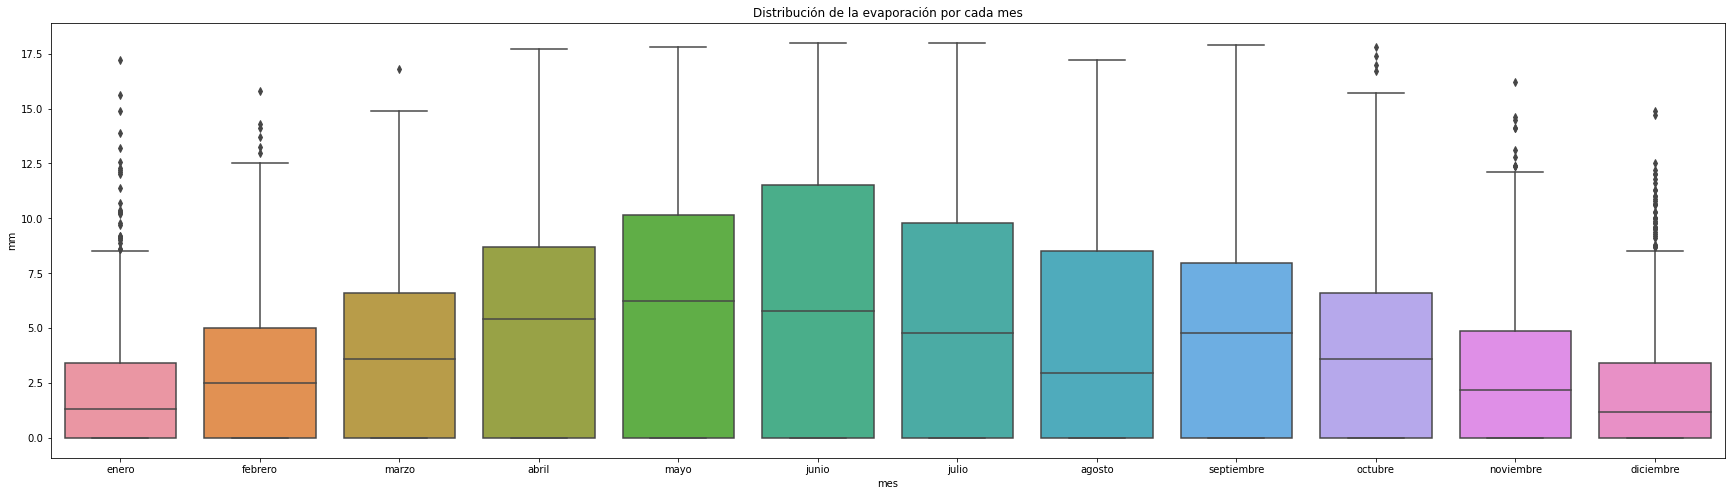

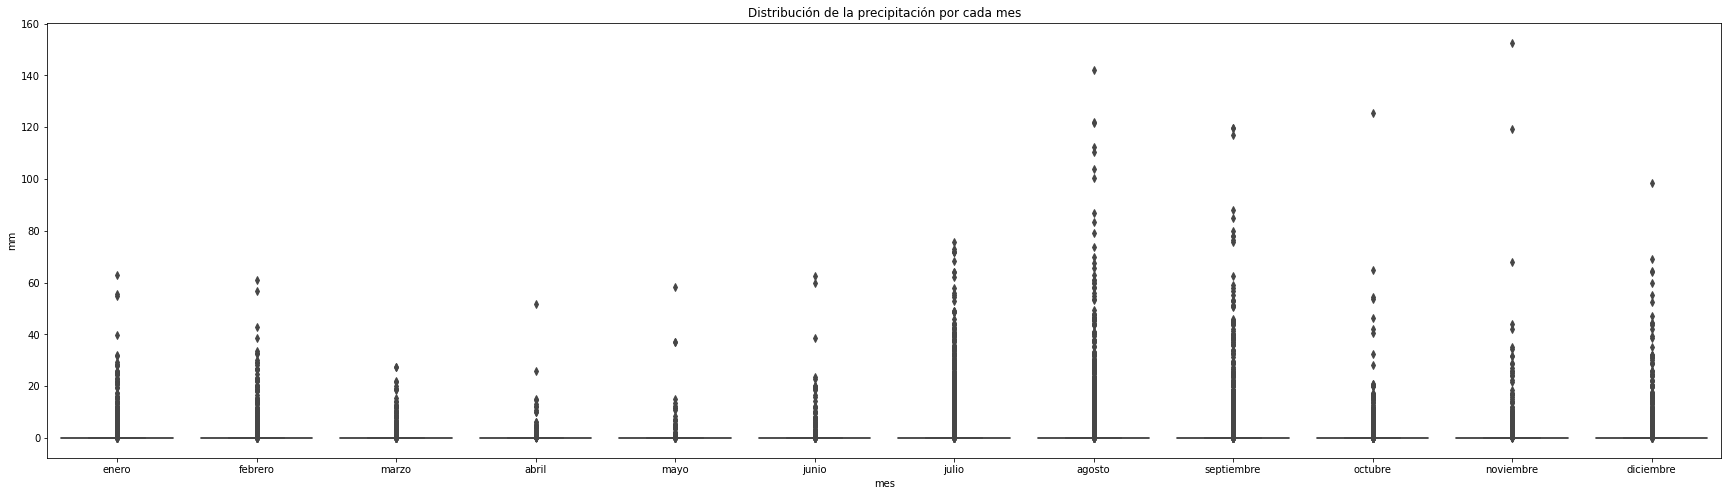

In [46]:
for i in range(6):
    distribucionPorMesTotal(df, variables[i], f"{titulos[i]} por cada mes", 'mes', ylabels[i])

### Series de tiempo

In [47]:
df_medias_por_dia = df.groupby(['Fecha']).mean().reset_index().sort_values('Fecha')
df_medias_por_dia

Fecha  IdEstacion  Tmin  Tmax  Tprom  UCalor  Evap  Precip
0     1965-07-01     26138.0  26.0  40.0    0.0   19.03   0.0     0.0
1     1965-07-02     26138.0  26.0  40.0    0.0   19.03   0.0     0.0
2     1965-07-03     26138.0  26.0  40.0    0.0   19.03   0.0     0.0
3     1965-07-04     26138.0  26.0  40.0    0.0   19.03   0.0     0.0
4     1965-07-05     26138.0  26.0  40.0    0.0   19.03   0.0     0.0
...          ...         ...   ...   ...    ...     ...   ...     ...
18715 2016-09-26     26139.0  24.0  36.0    0.0   18.09   0.0     5.2
18716 2016-09-27     26139.0  21.0  35.5    0.0   16.75   0.0     0.0
18717 2016-09-28     26139.0  22.0  35.0    0.0   17.13   0.0     0.0
18718 2016-09-29     26139.0  24.0  37.5    0.0   18.21   0.0     0.0
18719 2016-09-30     26139.0  24.5  37.0    0.0   18.37   0.0     0.0

[18720 rows x 8 columns]

#### Temperaturas

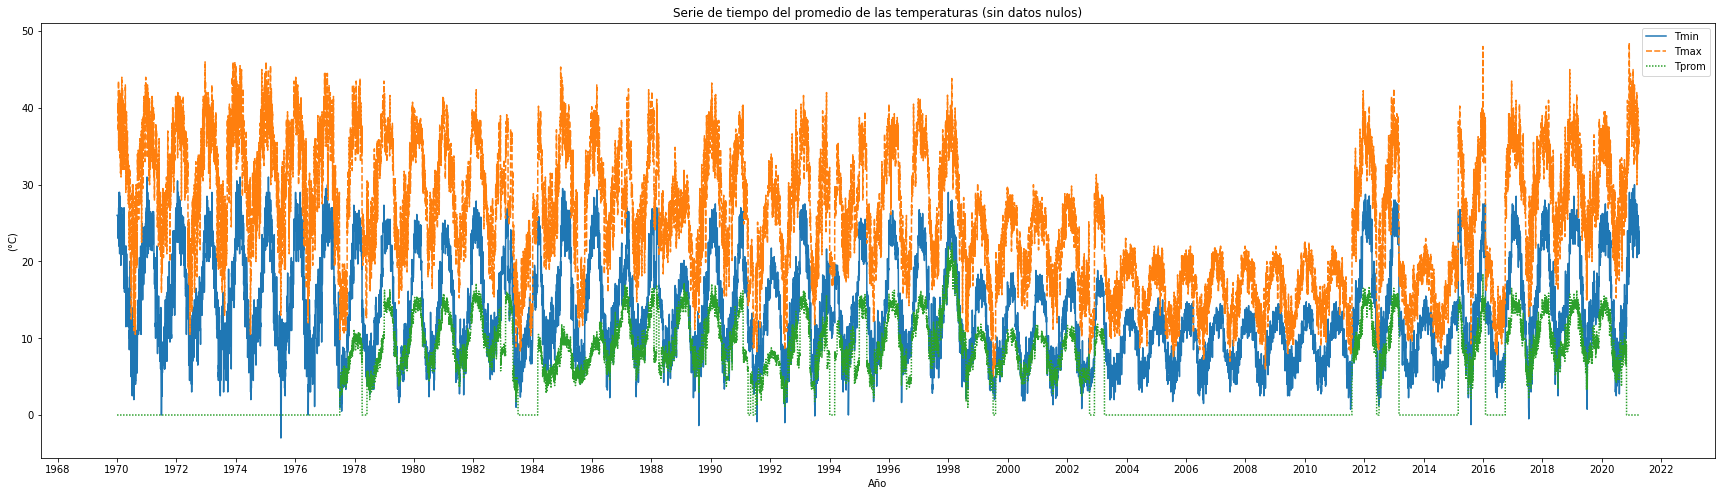

In [48]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(30, 8))
sns.lineplot(data = df_medias_por_dia.iloc[:,2:5]).set(title='Serie de tiempo del promedio de las temperaturas (sin datos nulos)', xlabel='Año', ylabel='(°C)')
# Define the date format
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.YearLocator(2))

#### Unidades de calor

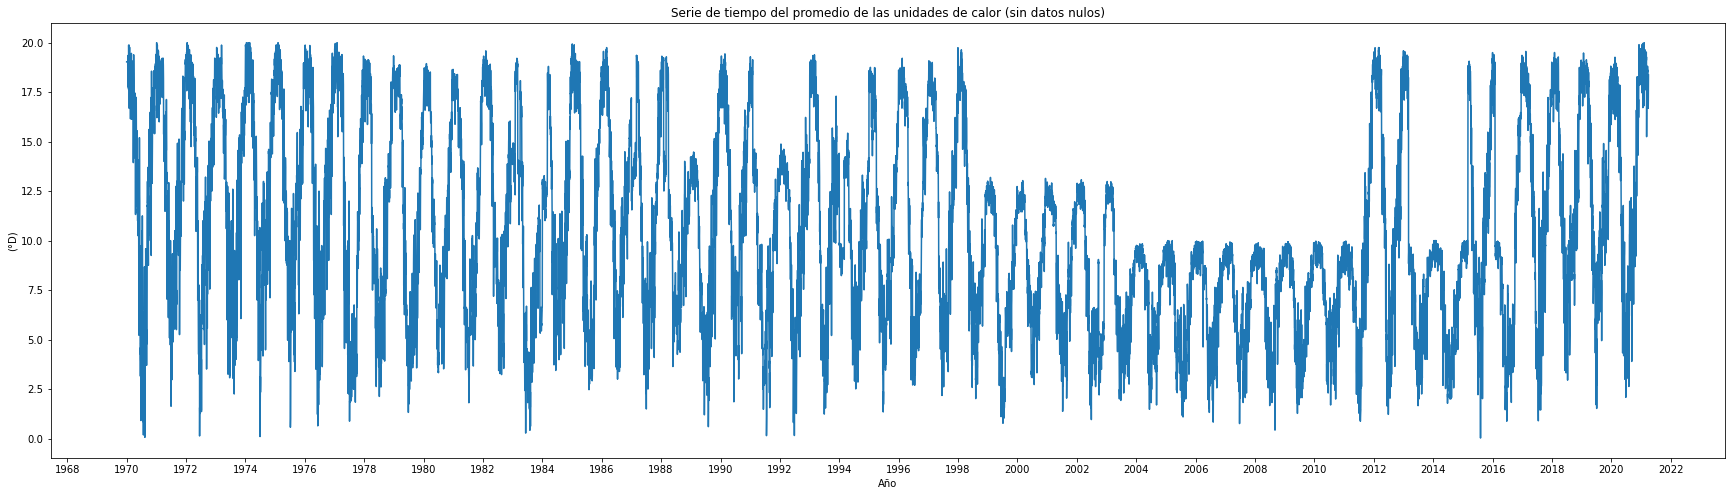

In [49]:
fig, ax = plt.subplots(figsize=(30, 8))
sns.lineplot(data = df_medias_por_dia.iloc[:,5]).set(title='Serie de tiempo del promedio de las unidades de calor (sin datos nulos)', xlabel='Año', ylabel='(°D)')
# Define the date format
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.YearLocator(2))

#### Evaporación y precipitación

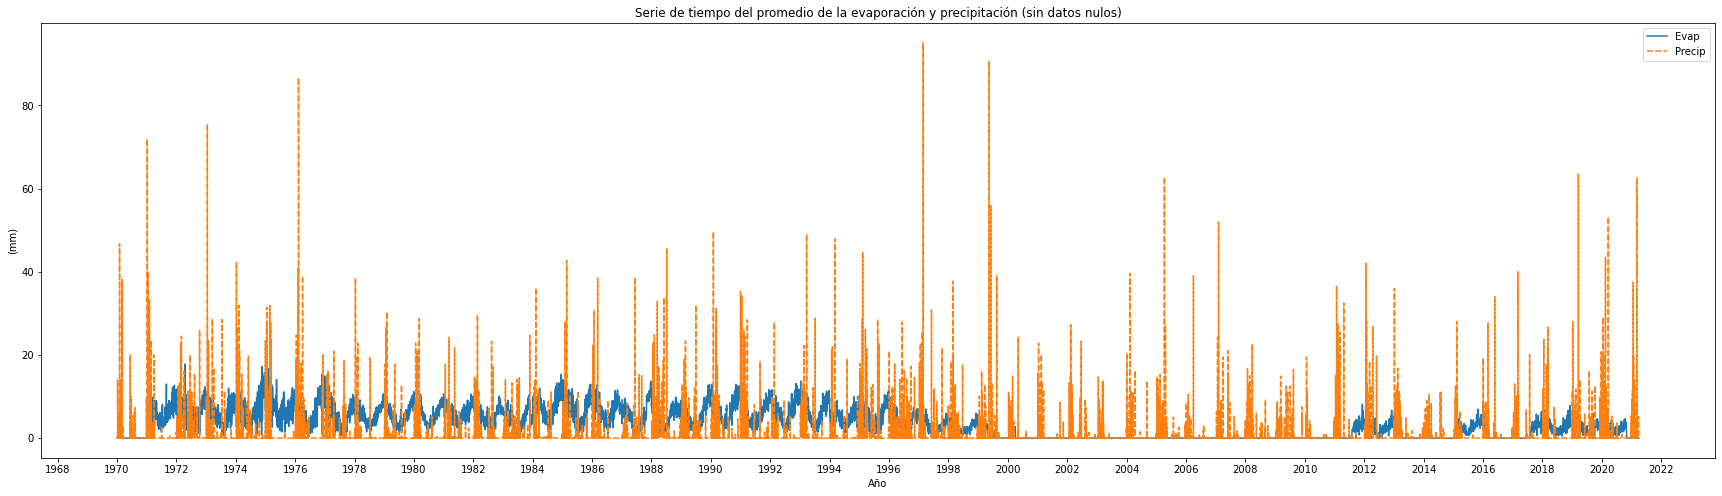

In [50]:
fig, ax = plt.subplots(figsize=(30, 8))
sns.lineplot(data = df_medias_por_dia.iloc[:,6:8]).set(title='Serie de tiempo del promedio de la evaporación y precipitación (sin datos nulos)', xlabel='Año', ylabel='(mm)')
# Define the date format
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.YearLocator(2))

# Detección de anomalías

## Análisis visual

En las siguientes gráficas se muestran las mediciones de estaciones metereologicas de Hermosillo

Text(0.5, 0, 'Temperatura Promedio')

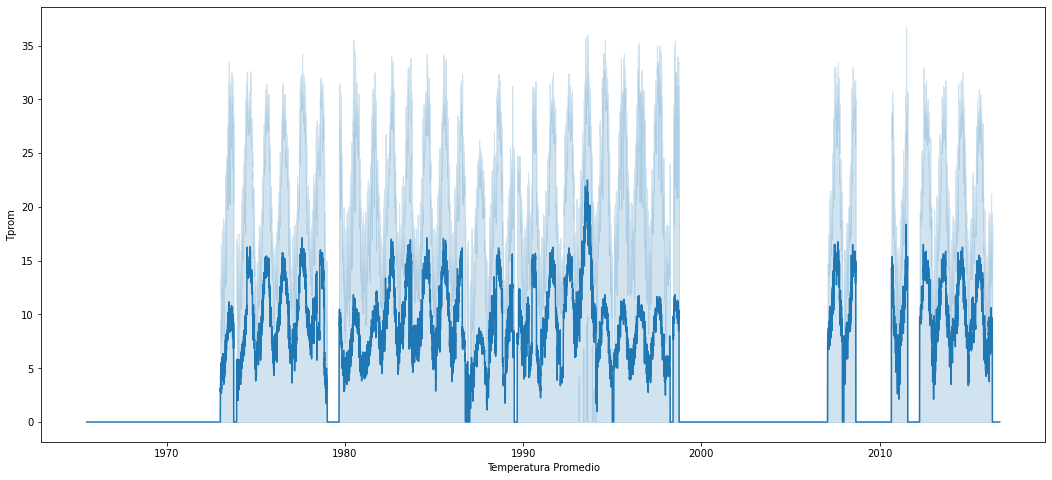

In [51]:
plt.figure(figsize=(18,8))
sns.lineplot(x = 'Fecha', y = 'Tprom', data = df)
plt.xlabel('Temperatura Promedio')

Text(0.5, 0, 'Temperatura Maxima')

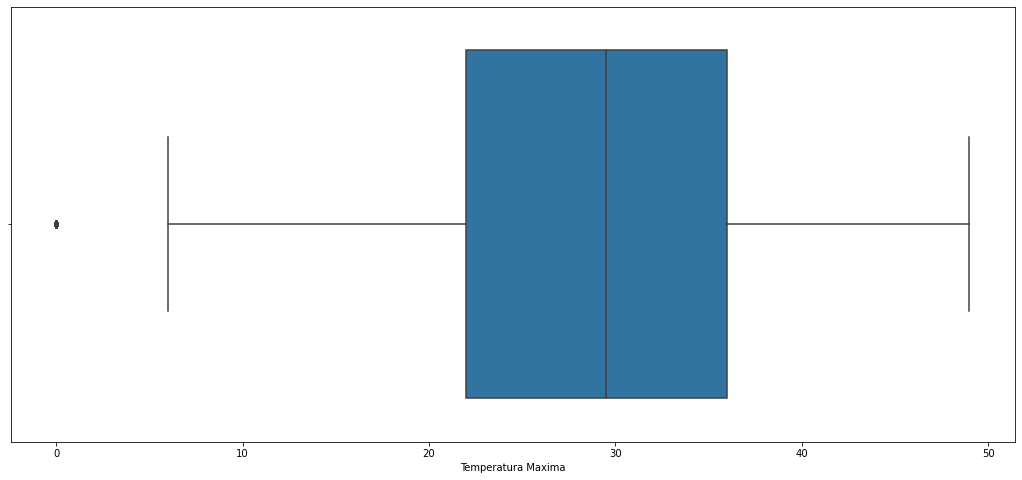

In [52]:
plt.figure(figsize = (18,8))
sns.boxplot(x=df.Tmax)
plt.xlabel('Temperatura Maxima')

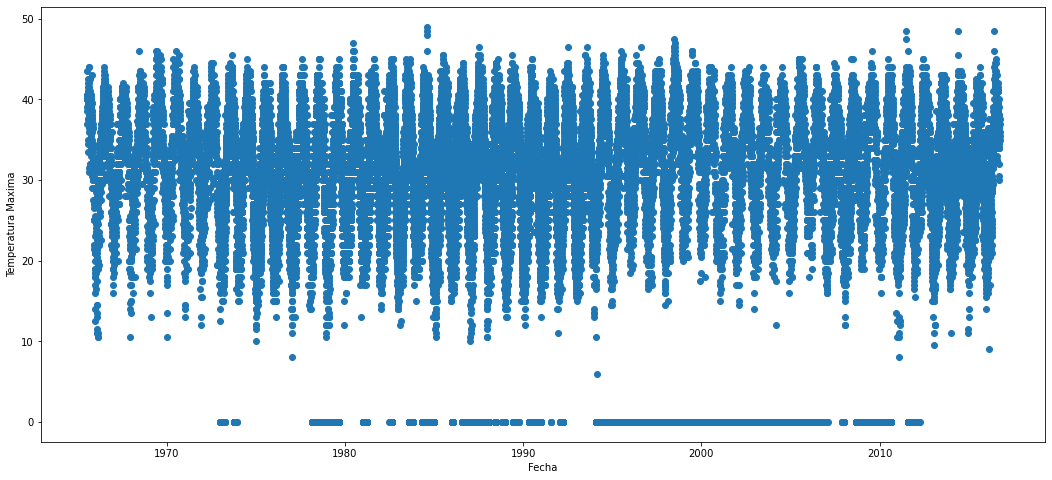

In [53]:
plt.figure(figsize = (18,8))
plt.scatter(df.Fecha, df.Tmax)
plt.xlabel('Fecha')
plt.ylabel('Temperatura Maxima');

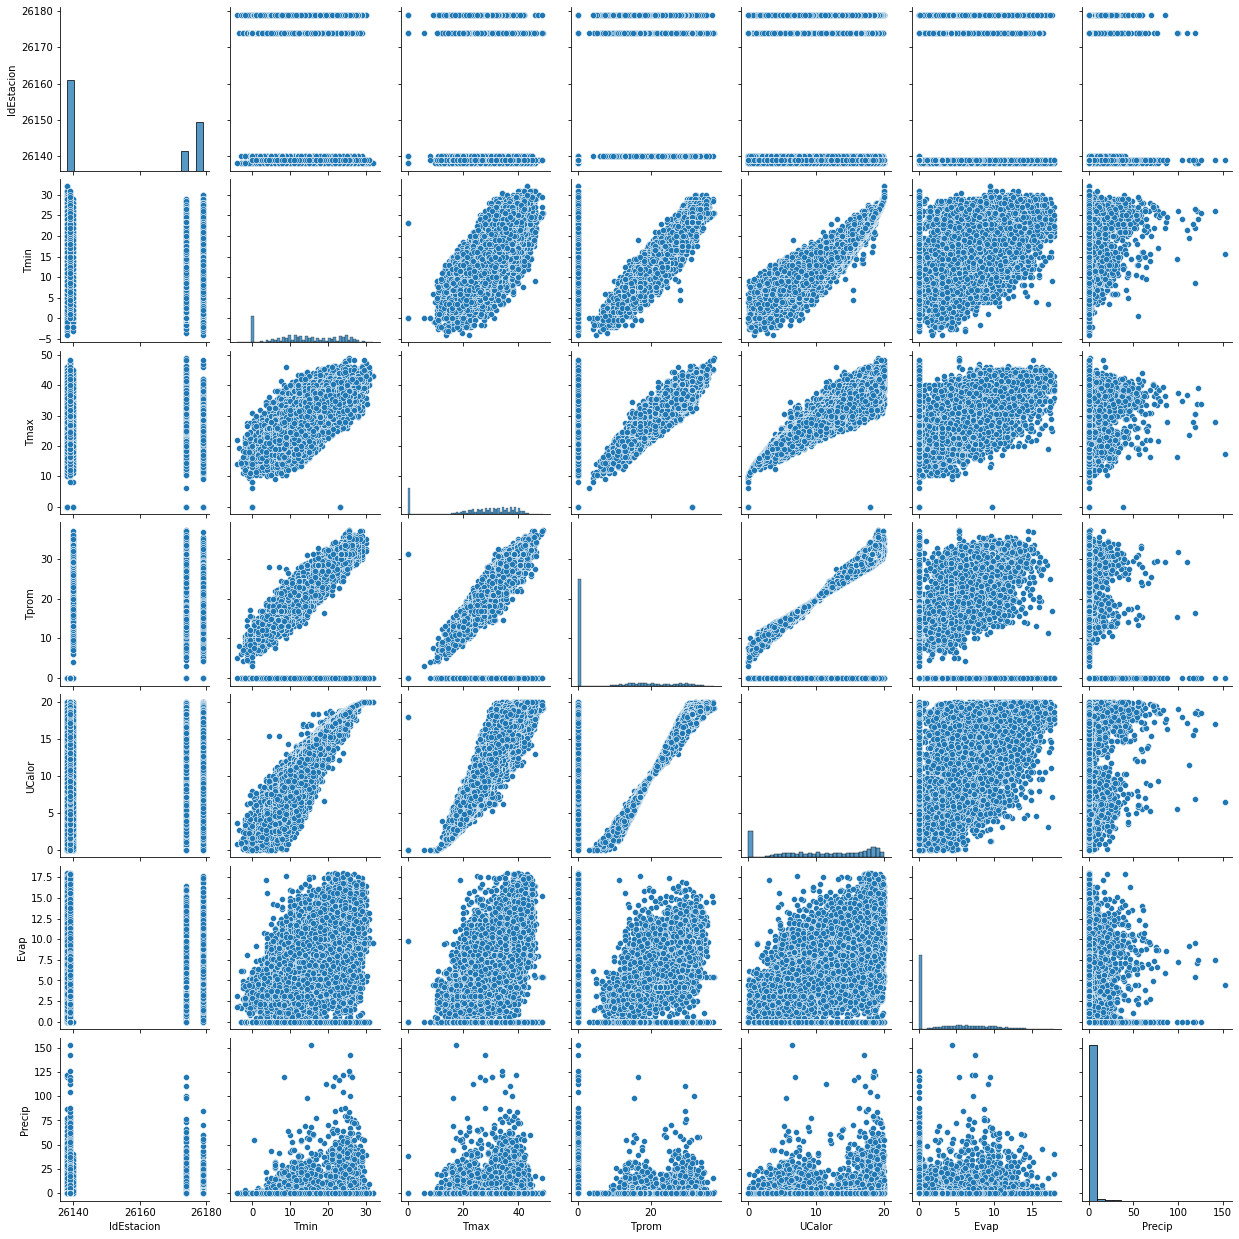

In [54]:
sns.pairplot(df, height= 2.5)

## Local Outlier Factor Method(LOF)

In [55]:
clf = LocalOutlierFactor(n_neighbors=1000, contamination='auto')
X = df[['Tmin', 'Tprom']].values
y_pred = clf.fit_predict(X)

In [56]:
plt.figure(figsize=(12,12))
# plot the level sets of the decision function

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c = 'blue',
                edgecolor = 'k', s = 30)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c = 'red',
                edgecolor = 'k', s = 30)
#plt.axis('Tprom')
plt.xlabel('Temperatura Mínima');
plt.ylabel('Temperatura Promedio');
plt.show()

## Z-Score

In [57]:
def out_zscore(data):
    #global outliers,zscore
    outliers = []
    zscore = []
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score= (i - mean)/std 
        zscore.append(z_score)
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return print("Total number of outliers in are",len(outliers))

In [58]:
for c in df.columns[4:-1]:
    print(f'Variable {c}')
    out_zscore(df[c])
    

Variable Tmin
Total number of outliers in are 0
Variable Tmax
Total number of outliers in are 0
Variable Tprom
Total number of outliers in are 0
Variable UCalor
Total number of outliers in are 0
Variable Evap
Total number of outliers in are 73
Variable Precip
Total number of outliers in are 733
